In [38]:
# Loading training and test data

import torch
data_tr = torch.load("training-test-data/training_data.txt")
target_tr = torch.load("training-test-data/training_targets.txt")
data_test = torch.load("training-test-data/test_data.txt")
target_test = torch.load("training-test-data/test_targets.txt")

num_samples = 512 # number of training samples
num_samples_test = 100 # number of test samples
new_dim1 = 32 * 1 # first dimension
new_dim2 = 32 * 1 # second dimension
old_dim = 32 # CIFAR original dimension


In [40]:
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

# Two-layer linear convolutional neural network
output_channels = 1
class Net(nn.Module):
    def __init__(self, ker_size1, ker_size2, output_channels):
        super(Net, self).__init__()
        self.ker_size1 = ker_size1
        self.ker_size2 = ker_size2
        self.output_channels = output_channels
        self.conv1 = nn.Conv2d(3, output_channels, kernel_size=(self.ker_size1, self.ker_size2), bias=False) 
        self.fc1 = nn.Linear(int(new_dim1 * new_dim2 * output_channels), 1, bias=False)


    def forward(self, x):
        y1 = F.pad(x, (0,self.ker_size2-1,0,self.ker_size1-1), mode='circular') # Circular padding 
        y1 = self.conv1(y1)
        # y1 = F.relu(y1) # ReLU activations
        y1 = y1.reshape(y1.size(0), -1)
        y1 = self.fc1(y1) 
        return y1

    def initialize(self, initialization_scale, ker_size1):
        print("init")
        self.fc1.weight.data.mul_(initialization_scale)
        self.conv1.weight.data.mul_(initialization_scale)


output = torch.zeros((num_samples, 1))
output = output.float()
output_test = torch.zeros((num_samples_test, 1))
output_test = output.float()


# Batch gradient descent
def train_minibatch(network, optimizer):
    minibatch_size = 32
    num_batch = int(num_samples/minibatch_size)
    for i in range(num_batch):
        network.train()
        optimizer.zero_grad()
        start_index = i * minibatch_size
        end_index = start_index + minibatch_size
        output = network(data_tr[start_index:end_index])
        loss = torch.sum(torch.exp(-1 * torch.mul(output.flatten(), target_tr[start_index:end_index]))) / minibatch_size
        loss.backward()
        optimizer.step()

# Evaluate training data loss
def train_eval(network):
    network.eval()
    train_loss = 0
    correct = 0
    with torch.no_grad():
        output = network(data_tr)
        train_loss = torch.sum(torch.exp(-1 * torch.mul(output.flatten(), target_tr)))
        pred = output.apply_(lambda x: 1 if x > 0 else -1)
        correct += pred.eq(target_tr.data.view_as(pred)).sum()
    train_loss /= num_samples
    print('\nTrain set: Avg. loss: {:.9f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    train_loss, correct, num_samples,
    100. * correct / num_samples))
    return train_loss

def test(network):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        output_test = network(data_test)
        test_loss = torch.sum(torch.exp(-1 * torch.mul(output_test.flatten(), target_test)))
        pred = output_test.apply_(lambda x: 1 if x > 0 else -1)
        correct += pred.eq(target_test.data.view_as(pred)).sum()
    test_loss /= num_samples_test
    accuracy = 100. * correct / num_samples_test
    losses = test_loss
    return (accuracy, losses)

from matplotlib.colors import LogNorm


# Get the information about beta
def extract_info(network, show_photo): 

  # Compute beta for linear CNNs
    betas = []
    
    print("new")
  
  # Compute margin
    with torch.no_grad():
        network.eval()
        output_np = np.ndarray.flatten(network(data_tr).data.numpy())
        target_np = np.ndarray.flatten(target_tr.data.numpy())
        margins = [target_np[i] * output_np[i] for i in range(num_samples)]
        min_margin = min(margins) # get the minimum margin for any datapoint 
        
    for c in range(3):
        beta_test = np.zeros((new_dim1,new_dim2))
        for i in range(new_dim1):
            for j in range(new_dim2):
                tempimg = torch.zeros((1,3,new_dim1, new_dim2))
                tempimg[0,c,i,j]=1
                beta_test[i,j] = network(tempimg)  
        betas.append(beta_test / min_margin)

    # Compute R(beta)
    w1 = network.conv1.weight.detach().numpy()
    w2 = network.fc1.weight.detach().numpy()
    w1_norm_sq = np.sum(np.square(w1))
    w2_norm_sq = np.sum(np.square(w2))
    print(w1_norm_sq, w2_norm_sq)
    Rbeta = (np.sum(np.square(w1)) + np.sum(np.square(w2))) * np.sqrt(new_dim1 * new_dim2)
    Rbeta = Rbeta / min_margin
    
    print("Rbeta: " + str(Rbeta))

    if show_photo:
        sns.set_context("paper",font_scale=3,rc={"lines.linewidth":1})
        fig, axs = plt.subplots(2, 3, figsize=(20,10))
        for c in range(3):
            axs[0, c].imshow(np.absolute(betas[c]),cmap='gray')
            axs[1, c].imshow(np.absolute(np.fft.fft2(betas[c], norm='ortho')), cmap='gray', norm=LogNorm(vmin=0.0001, vmax=0.08))
        plt.show()
    return (Rbeta, betas)


In [41]:
# Train and extract info about beta
import seaborn as sns
n_epochs = 100000
momentum = 0.3
initialization_scale = 0.001

learning_rate_start = 0.005


from tqdm import tqdm_notebook as tqdm
def experiment(ker_size1, ker_size2, output_channels):
    network = Net(ker_size1, ker_size2, output_channels)
    network.initialize(initialization_scale, ker_size1)
    optimizer =  optim.SGD(network.parameters(), lr=learning_rate_start, momentum=momentum)
    print("Before training:")
    train_eval(network)
    print("Start training:")
    for epoch in tqdm(range(1, n_epochs + 1)):
        train_minibatch(network, optimizer)
        if epoch % 100 == 0:
            loss = train_eval(network)
            if loss <= 0.000001: # stop at 10^-6 loss 
                break

        if epoch % 1000 == 0:
            print(test(network))

        if epoch == 200 == 0:
            optimizer =  optim.SGD(network.parameters(), lr=0.01, momentum=momentum)

        if epoch == 500:
            optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=momentum)

        if epoch == 1000:
            optimizer = optim.SGD(network.parameters(), lr=0.05, momentum=momentum)

        if epoch == 1200:
            optimizer = optim.SGD(network.parameters(), lr=0.1, momentum=momentum)

        if epoch == 1500:
            optimizer = optim.SGD(network.parameters(), lr=0.5, momentum=momentum)

        if epoch == 2000:
            optimizer = optim.SGD(network.parameters(), lr=1, momentum=momentum)

        if epoch == 3000:
            optimizer = optim.SGD(network.parameters(), lr=2, momentum=momentum)

        if epoch == 4000:
            optimizer = optim.SGD(network.parameters(), lr=4, momentum=momentum)

        if epoch == 4500:
            optimizer = optim.SGD(network.parameters(), lr=10, momentum=momentum)

        if epoch == 5000:
            optimizer = optim.SGD(network.parameters(), lr=20, momentum=momentum)




    print("After training:")
    train_eval(network)
    (accuracy, losses) = test(network)
    print(accuracy, losses)

    (rk, beta) = extract_info(network, True)
    return (rk, beta)


In [42]:


import pandas as pd
        

# Cout = [1, 2, 3, 4]
T = 10

Cout = [1, 2, 3, 4, 8]

def run_experiment_series(k):
    pairs = []
    for c in Cout:
        pairs.append((k, c))
    betas = []
    rbetas = []
    for (k, output_channels) in pairs:
        for t in range(T):
            print(k, output_channels)
            (Rbeta, beta) = experiment(k, k, output_channels)
            rbetas.append(Rbeta)
            betas.append(beta)

    # Write betas
    for i in range(len(pairs)):
        rbetas_to_write = []
        for t in range(T):
            index = i *T + t
            rbetas_to_write.append(rbetas[index])
            beta_array = betas[index]
            for j in range(3):
                beta = beta_array[j]
                name = "experiments-data/" + "beta" + str(pairs[i]) + "inputchannel" + str(j) + str(t) + ".csv"
                print(str(pairs[i]))
                pd.DataFrame(beta).to_csv(name, header=False, index=False)
        name = "experiments-data/" + "rbeta" + str(pairs[i]) + "inputchannel" + ".csv"
        pd.DataFrame(rbetas_to_write).to_csv(name, header=False, index=False)
    

1 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 232/512 (45%)

Start training:


<ipython-input-41-7856f034cddc>:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(1, n_epochs + 1)):


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.253014177, Accuracy: 492/512 (96%)


Train set: Avg. loss: 0.073619477, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.034472171, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020752138, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014275601, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008329852, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005686518, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004240409, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003343178, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002738528, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1199e+09))

Train set: Avg. loss: 0.001361952, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000878779, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000495685, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000338451, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000254371, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106781, A

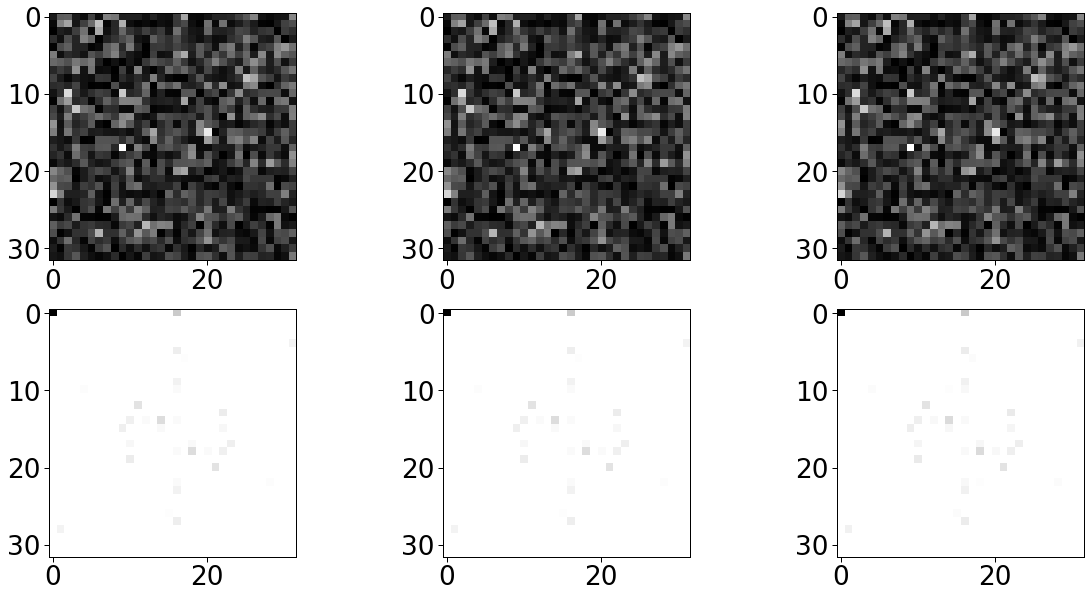

1 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 214/512 (42%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.250131518, Accuracy: 492/512 (96%)


Train set: Avg. loss: 0.073084600, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.034313563, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020684402, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014239921, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008315963, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005679505, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004236259, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003340481, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002736647, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1233e+09))

Train set: Avg. loss: 0.001361439, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000878550, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000495608, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000338414, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000254349, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106777, A

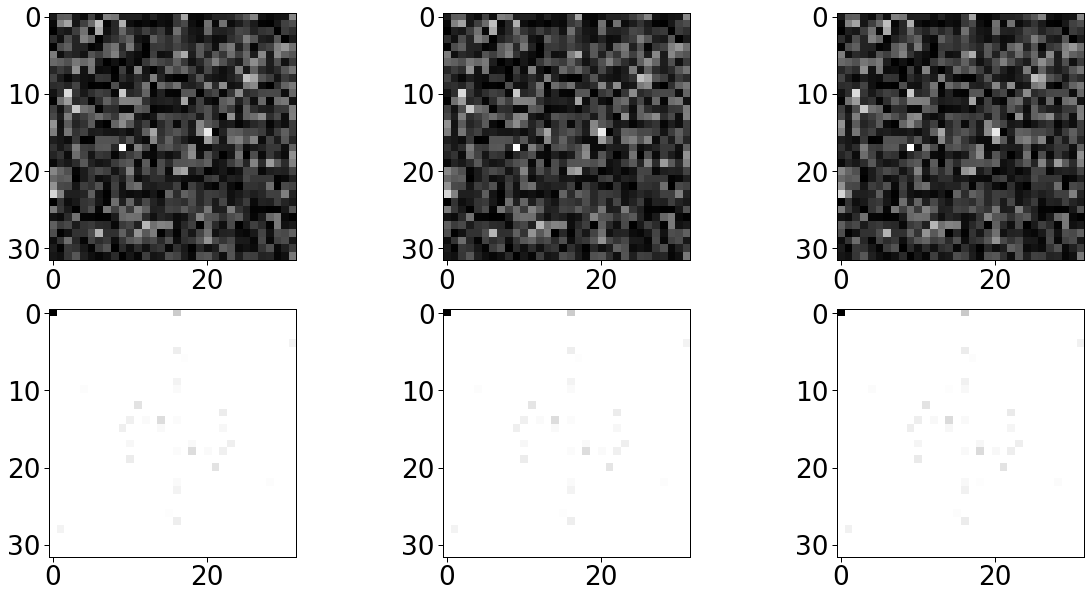

1 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 317/512 (62%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.258913636, Accuracy: 491/512 (96%)


Train set: Avg. loss: 0.074713573, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.034795519, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020889869, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014348062, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008358055, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005700855, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004248876, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003348710, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002742381, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1122e+09))

Train set: Avg. loss: 0.001363018, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000879248, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000495849, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000338531, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000254417, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106790, A

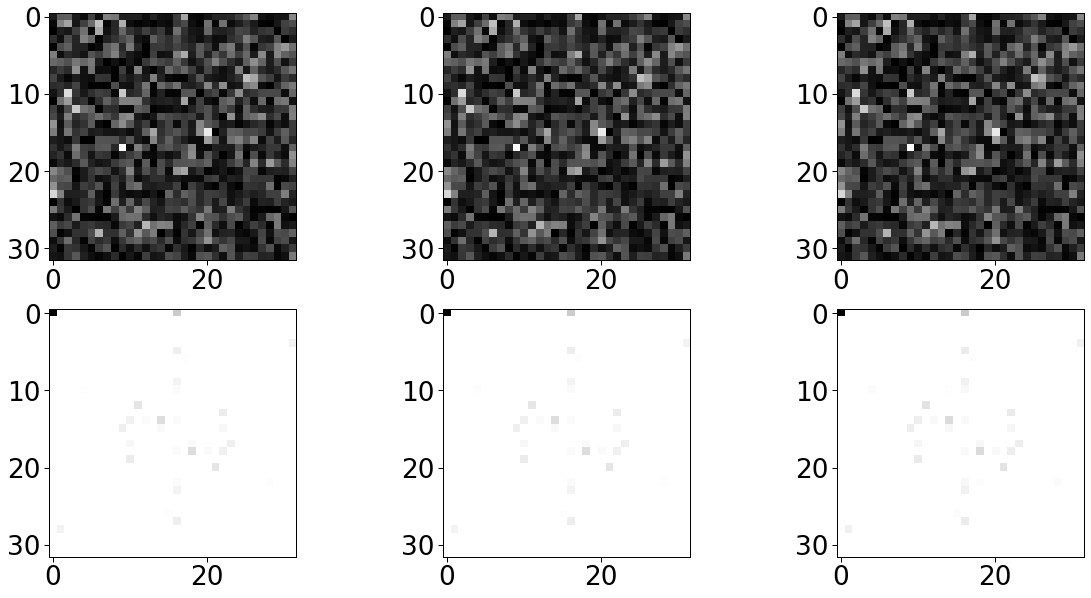

1 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 239/512 (47%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.260006338, Accuracy: 491/512 (96%)


Train set: Avg. loss: 0.074914992, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.034854591, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020914894, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014361193, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008363158, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005703420, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004250395, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003349690, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002743053, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1128e+09))

Train set: Avg. loss: 0.001363205, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000879333, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000495878, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000338545, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000254425, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106792, A

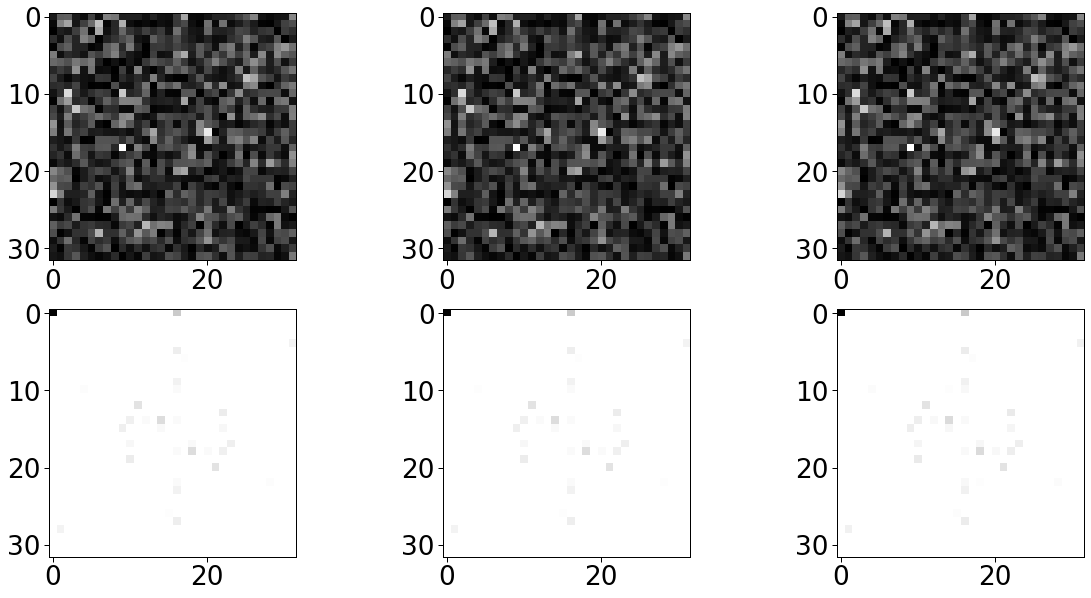

1 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 283/512 (55%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.252602786, Accuracy: 492/512 (96%)


Train set: Avg. loss: 0.073544040, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.034450062, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020742718, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014270653, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008327953, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005685559, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004239839, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003342812, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002738266, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1222e+09))

Train set: Avg. loss: 0.001361878, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000878746, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000495674, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000338446, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000254368, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106780, A

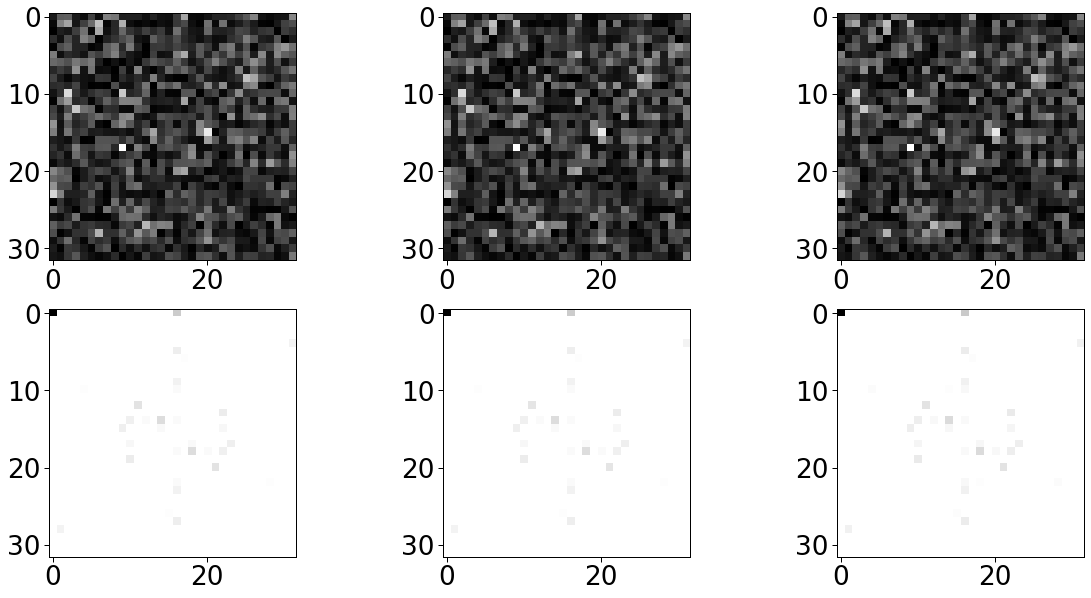

1 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 220/512 (43%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.242012545, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071571521, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033861168, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020490425, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014137512, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008275952, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005659179, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004224231, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003332631, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002731169, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1338e+09))

Train set: Avg. loss: 0.001359915, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000877881, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000495376, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000338300, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000254282, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106764, A

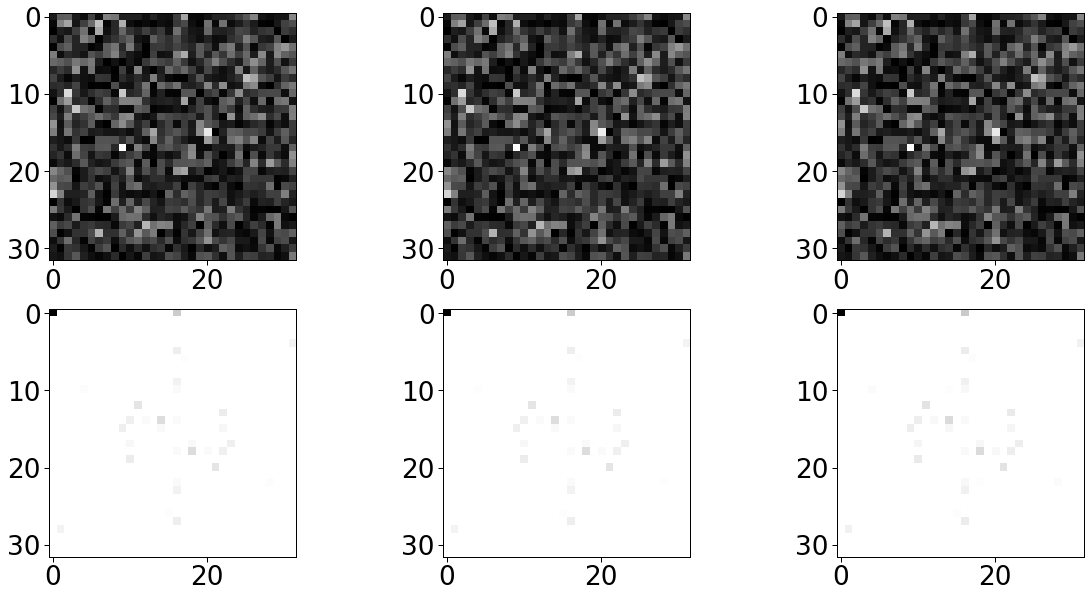

1 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 292/512 (57%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.244810522, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.072094284, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.034018140, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020557866, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014173167, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008289919, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005666255, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004228416, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003335365, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002733067, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1305e+09))

Train set: Avg. loss: 0.001360448, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000878117, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000495459, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000338341, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000254306, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106769, A

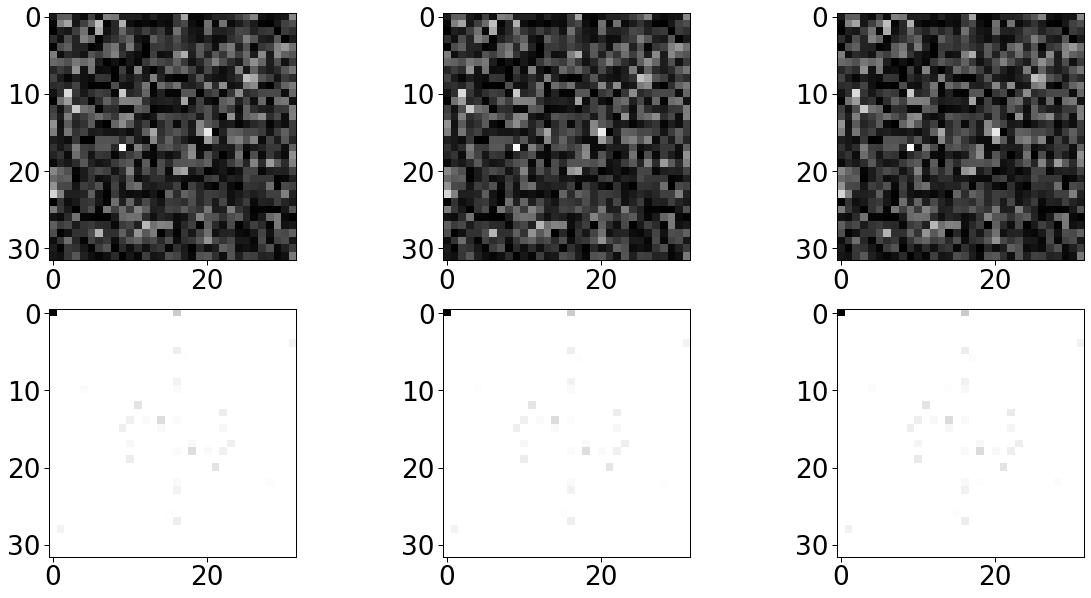

1 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 223/512 (44%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.244549483, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.072046585, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.034003999, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020551857, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014170012, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008288684, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005665649, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004228061, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003335132, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002732909, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1302e+09))

Train set: Avg. loss: 0.001360403, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000878096, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000495452, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000338337, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000254304, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106768, A

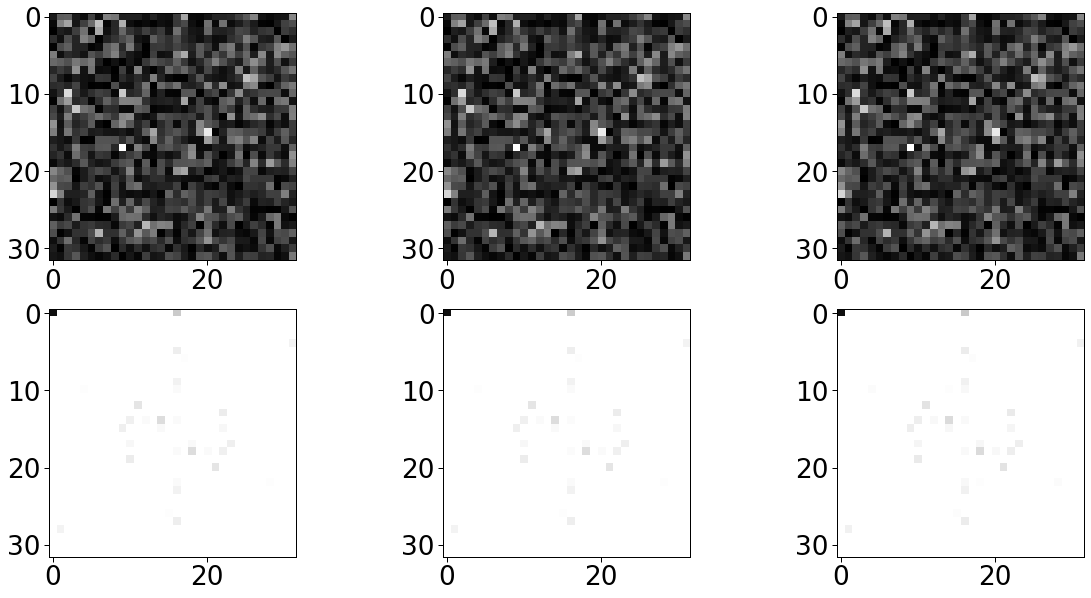

1 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 228/512 (45%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.264515847, Accuracy: 491/512 (96%)


Train set: Avg. loss: 0.075747401, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.035098530, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021018397, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014415461, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008384147, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005714081, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004256684, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003353781, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002745910, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1079e+09))

Train set: Avg. loss: 0.001363988, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000879684, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000495996, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000338603, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000254460, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106798, A

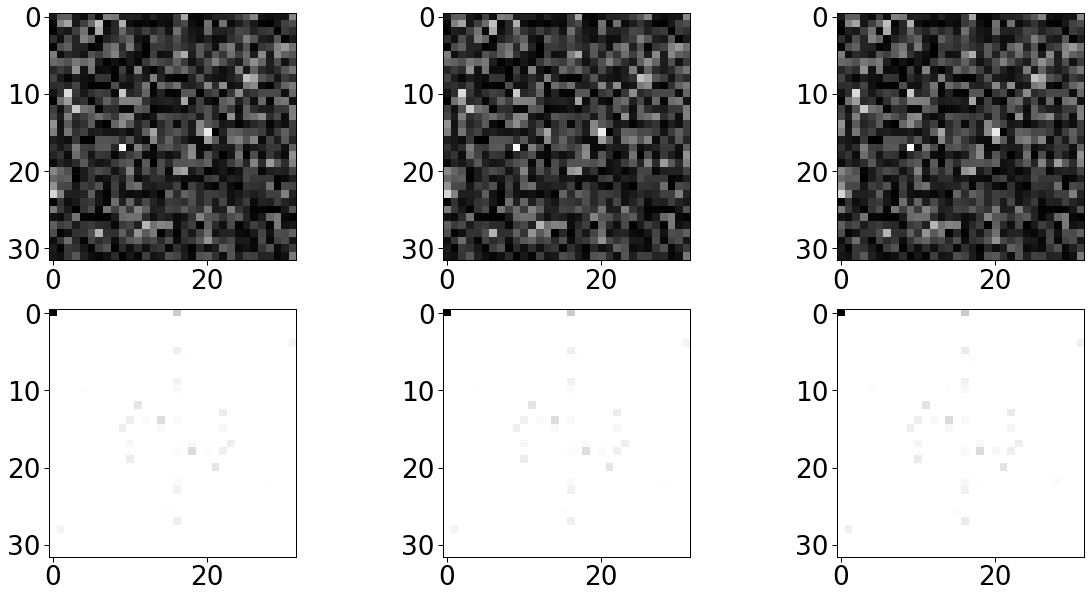

1 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 242/512 (47%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.240535557, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071295954, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033778470, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020454874, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014118707, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008268595, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005655405, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004221998, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003331171, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002730156, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1355e+09))

Train set: Avg. loss: 0.001359637, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000877759, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000495334, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000338280, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000254270, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106762, A

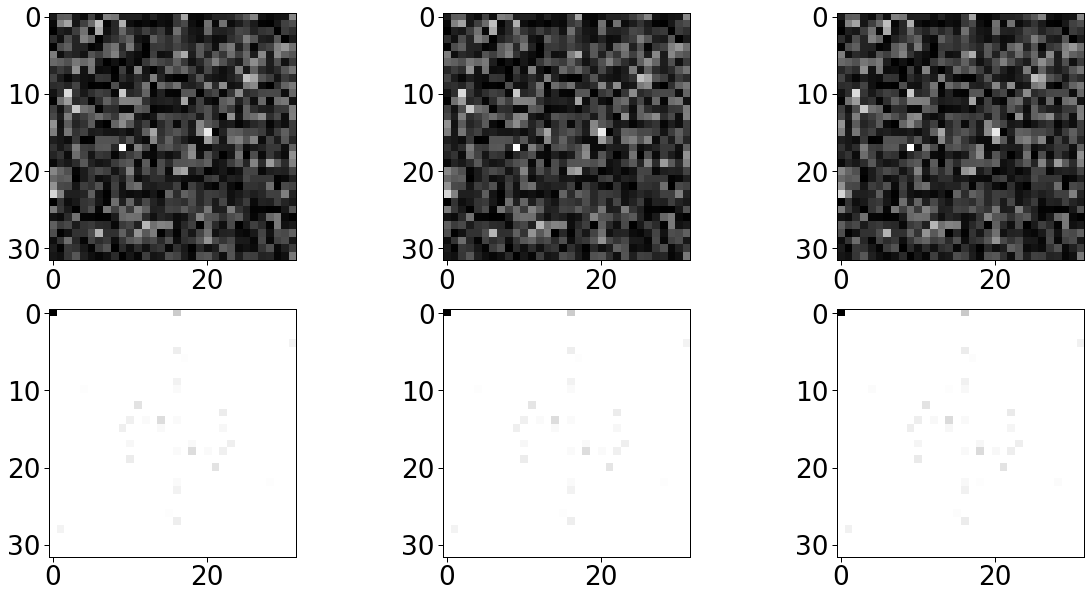

1 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 209/512 (41%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.241443679, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071438633, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033802606, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020453451, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014110204, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008257827, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005645392, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004213044, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003323197, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002722989, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1121e+09))

Train set: Avg. loss: 0.001355101, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000874418, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000493168, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000336666, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000252981, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106140, A

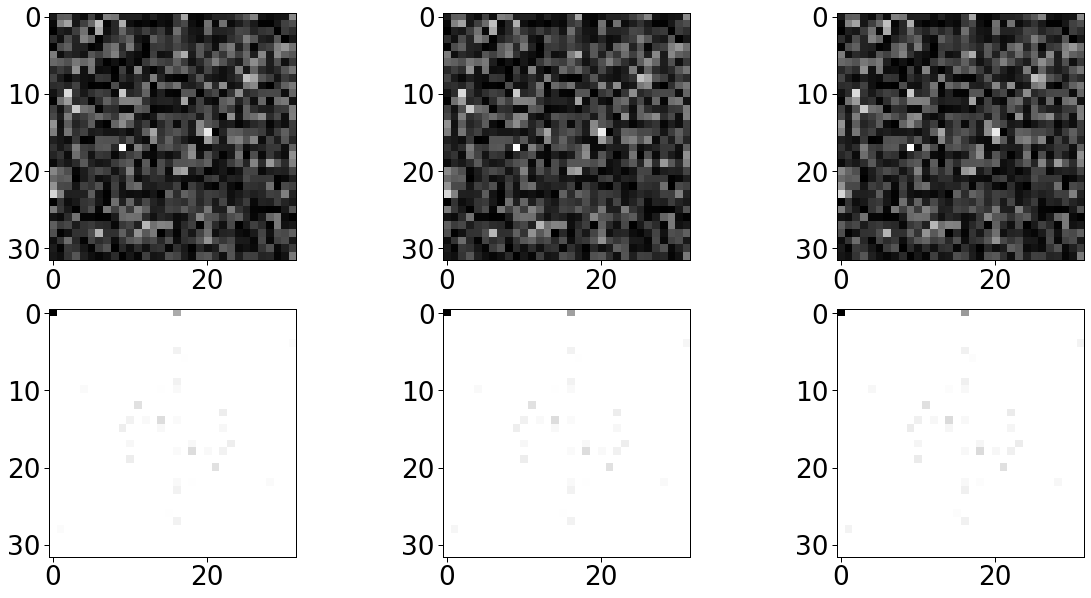

1 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 247/512 (48%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.246915415, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.072415128, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.034065150, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020547988, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014148481, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008261872, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005640964, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004206205, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003315779, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002715656, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.0751e+09))

Train set: Avg. loss: 0.001349678, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000870312, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000490486, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000334681, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000251409, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000105412, A

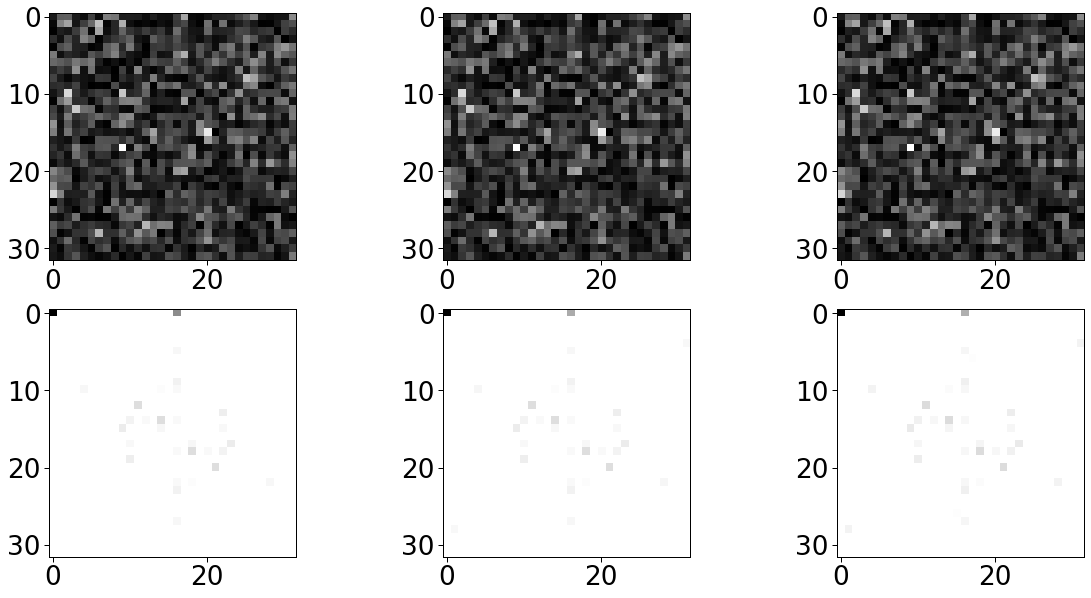

1 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 298/512 (58%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.243533373, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071840763, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033930991, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020513413, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014145055, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008274431, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005655696, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004220354, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003328806, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002727542, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1171e+09))

Train set: Avg. loss: 0.001357356, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000875932, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000494076, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000337322, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000253496, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106380, A

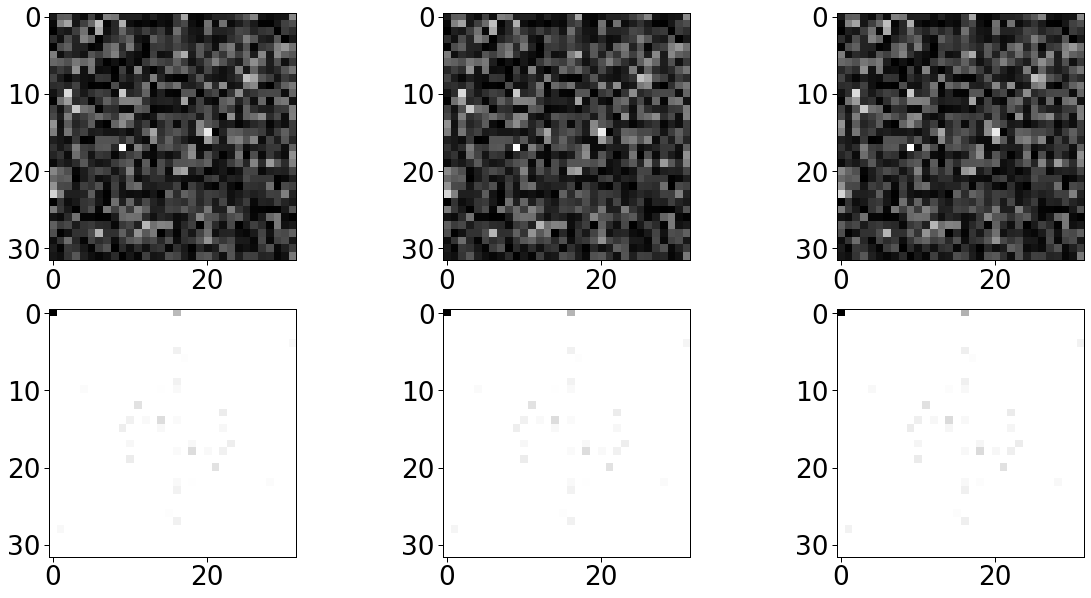

1 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 225/512 (44%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.244178101, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071887664, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033896502, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020469105, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014102674, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008240135, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005627682, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004196906, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003308726, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002710009, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.0702e+09))

Train set: Avg. loss: 0.001347011, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000868583, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000489500, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000333996, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000250884, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000105186, A

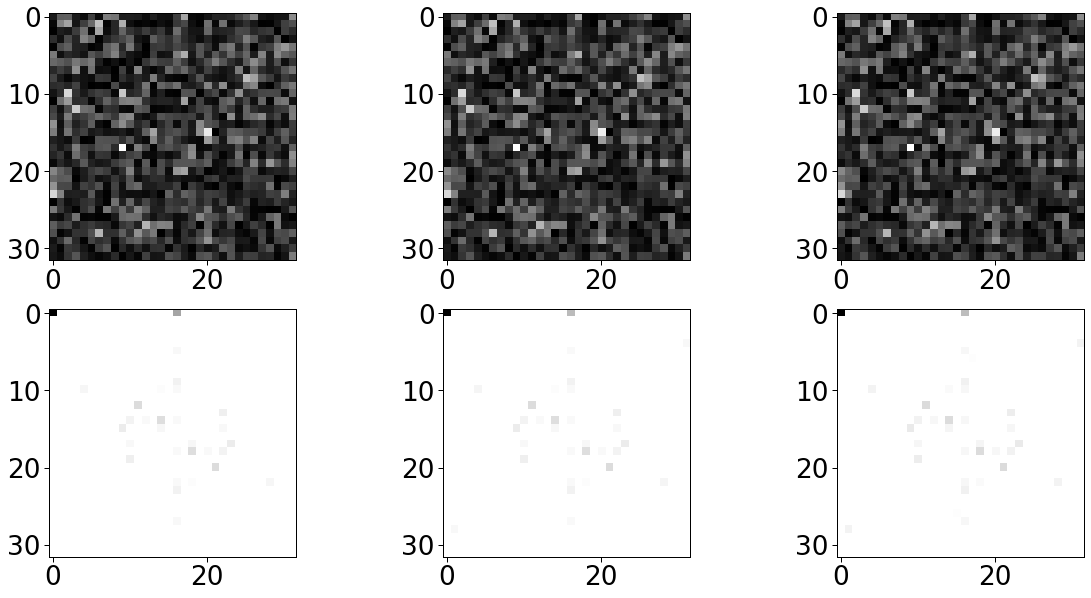

1 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 325/512 (63%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.241694033, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071481578, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033813026, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020456430, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014110848, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008257202, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005644541, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004212199, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003322405, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002722268, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1088e+09))

Train set: Avg. loss: 0.001354618, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000874064, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000492936, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000336494, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000252844, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106076, A

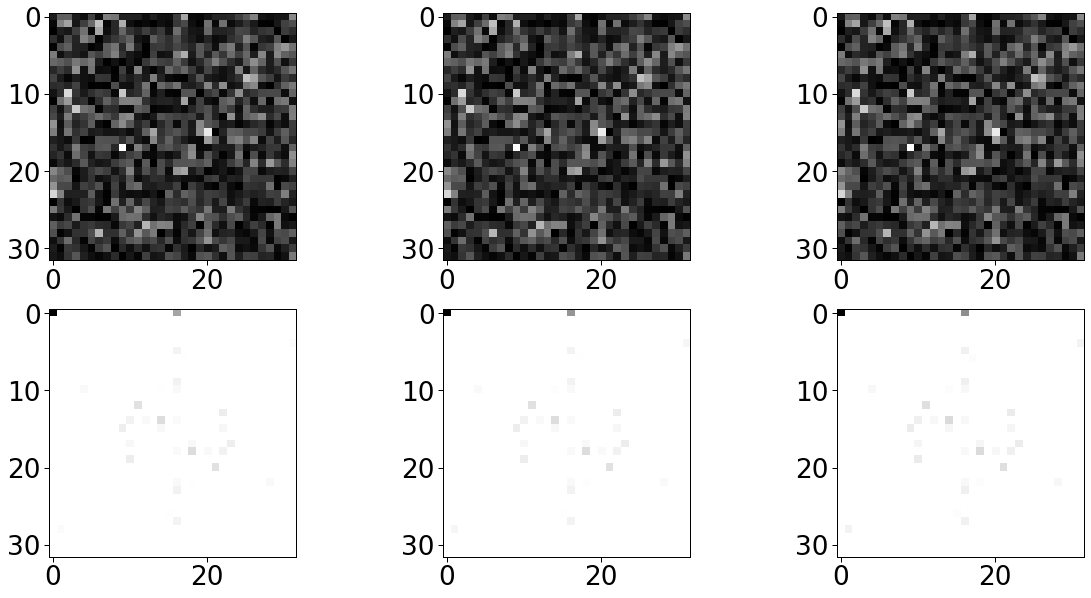

1 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 253/512 (49%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.242138147, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071588390, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033861846, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020487936, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014134345, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008272944, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005656519, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004221916, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003330605, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002729372, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1279e+09))

Train set: Avg. loss: 0.001358798, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000877054, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000494839, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000337896, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000253958, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106605, A

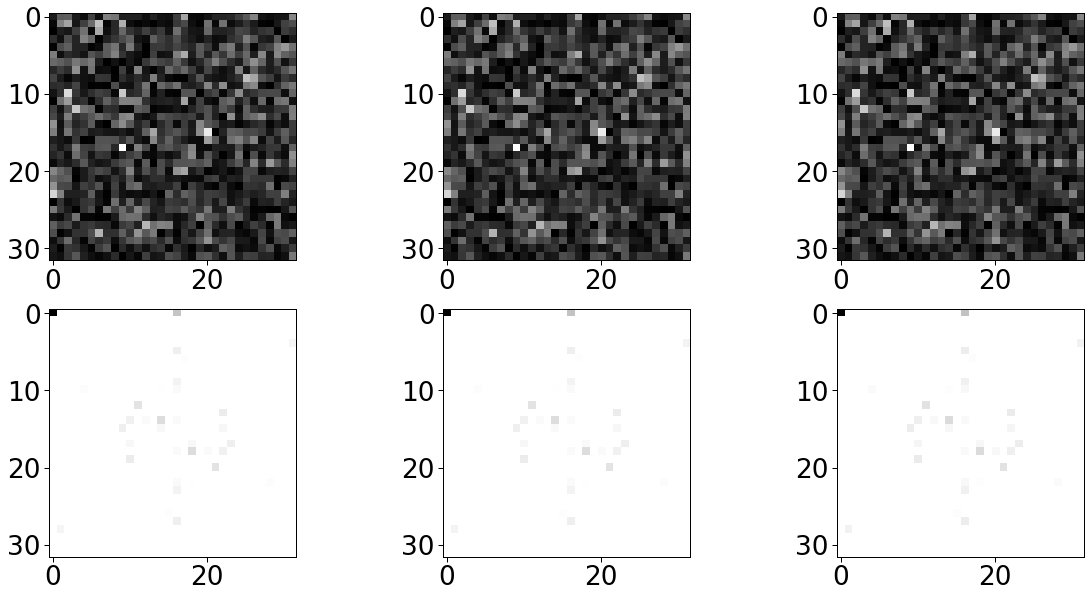

1 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 219/512 (43%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.244992197, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.072114460, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.034014892, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020550707, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014165597, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008283281, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005660681, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004223656, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003331216, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002729401, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1189e+09))

Train set: Avg. loss: 0.001358156, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000876436, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000494368, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000337528, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000253655, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106452, A

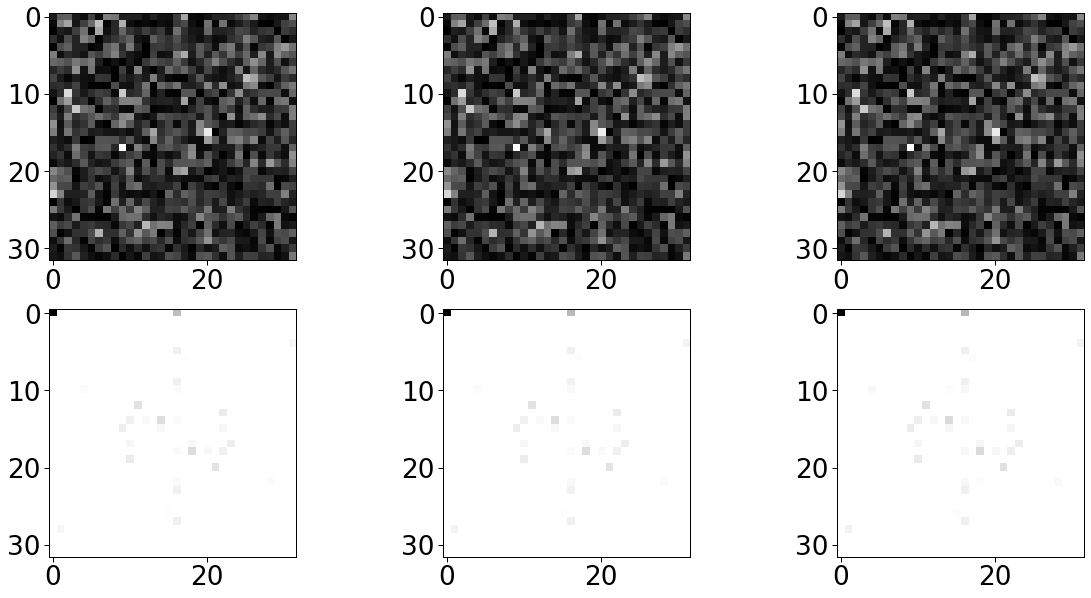

1 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 269/512 (53%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.252154976, Accuracy: 492/512 (96%)


Train set: Avg. loss: 0.073451281, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.034414962, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020722955, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014257103, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008319606, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005679474, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004234997, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003338779, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002734798, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1125e+09))

Train set: Avg. loss: 0.001359859, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000877298, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000494741, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000337754, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000253814, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106512, A

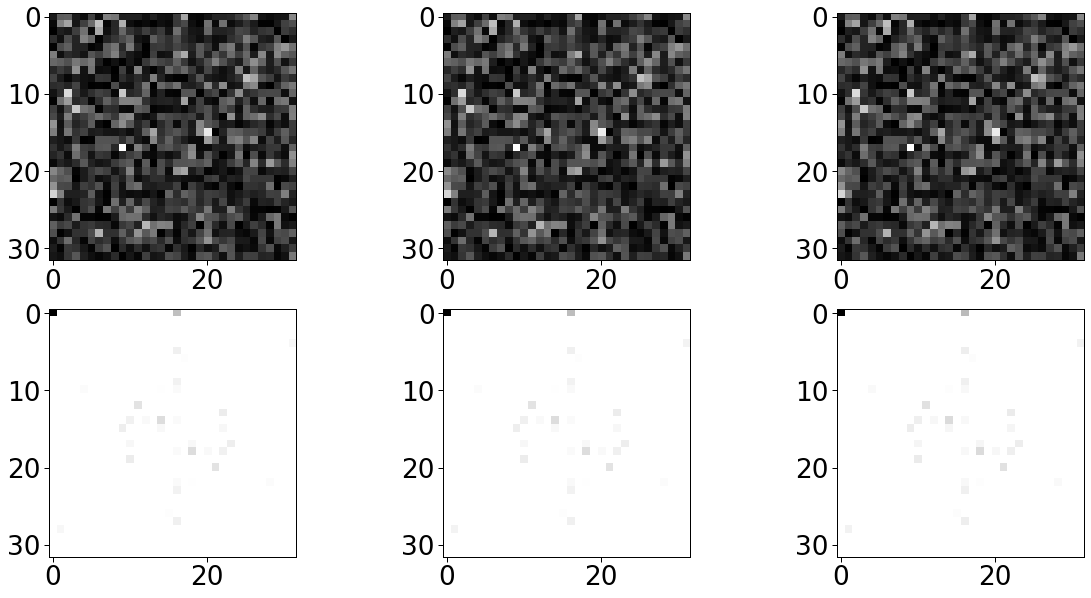

1 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 243/512 (47%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.244587734, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.072010651, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033963822, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020516321, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014139311, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008265337, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005646863, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004212398, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003321701, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002721161, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.0954e+09))

Train set: Avg. loss: 0.001353344, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000873003, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000492201, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000335939, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000252397, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000105862, A

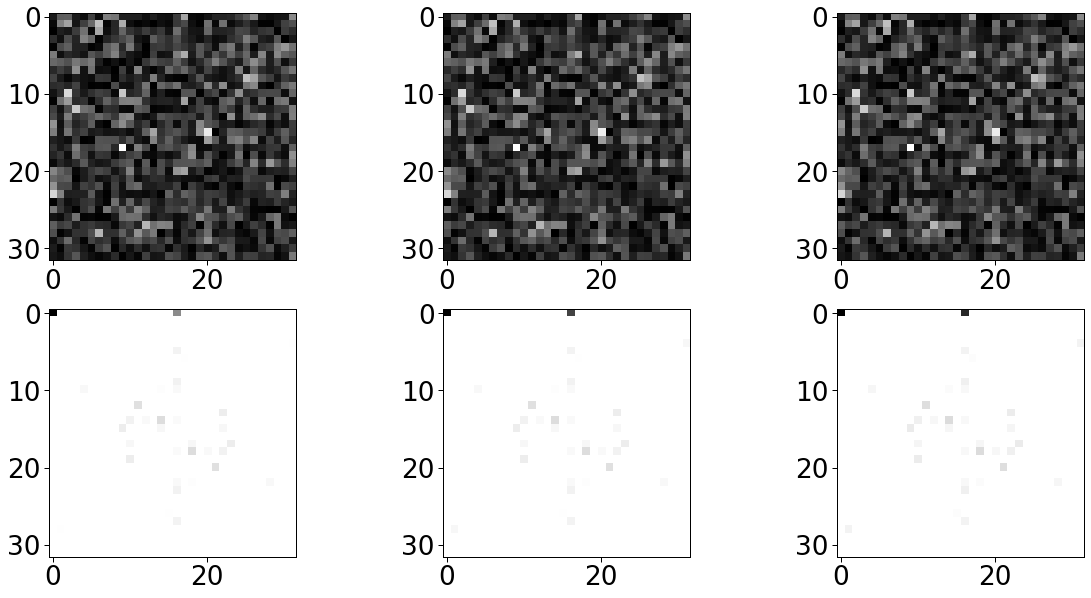

1 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 258/512 (50%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.245610148, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.072227865, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.034047253, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020563552, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014171749, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008285056, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005661179, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004223669, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003331040, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002729140, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1176e+09))

Train set: Avg. loss: 0.001357869, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000876193, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000494196, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000337396, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000253548, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106399, A

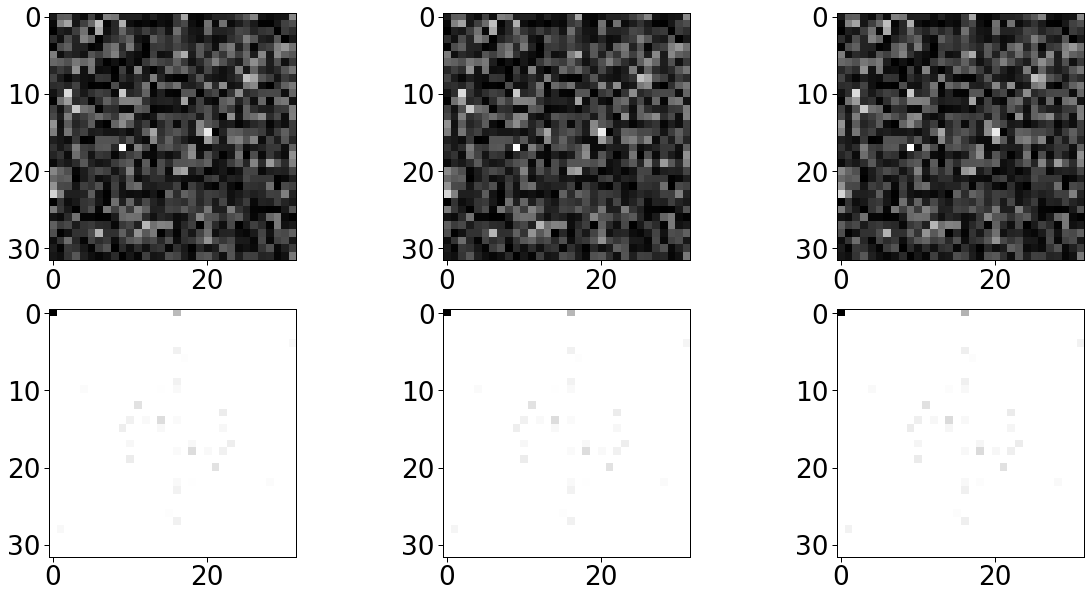

1 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 209/512 (41%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.240575016, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071297854, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033775132, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020450998, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014115024, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008265602, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005652947, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004219902, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003329354, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002728547, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1306e+09))

Train set: Avg. loss: 0.001358639, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000877023, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000494857, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000337923, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000253984, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106622, A

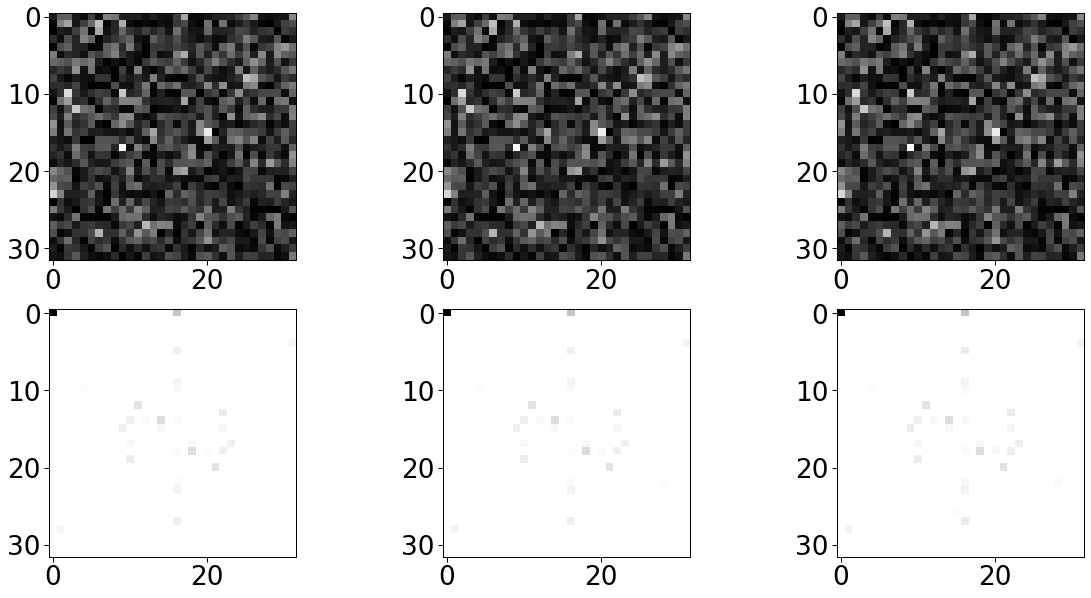

1 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 207/512 (40%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.242492214, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071634024, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033861019, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020478442, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014123365, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008262937, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005647975, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004214566, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003324188, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002723686, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1122e+09))

Train set: Avg. loss: 0.001355277, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000874491, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000493190, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000336674, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000252983, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106139, A

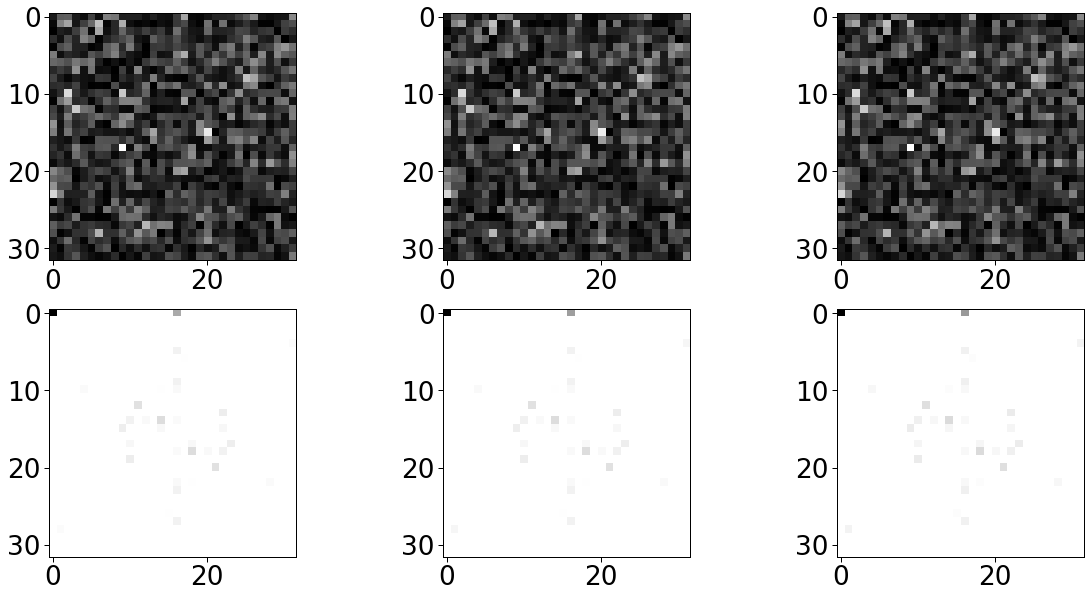

1 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 287/512 (56%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.248599365, Accuracy: 494/512 (96%)


Train set: Avg. loss: 0.072763778, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.034192838, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020617044, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014194123, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008288288, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005659473, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004220474, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003327407, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002725461, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.0979e+09))

Train set: Avg. loss: 0.001355030, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000874009, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000492738, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000336301, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000252672, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000105981, A

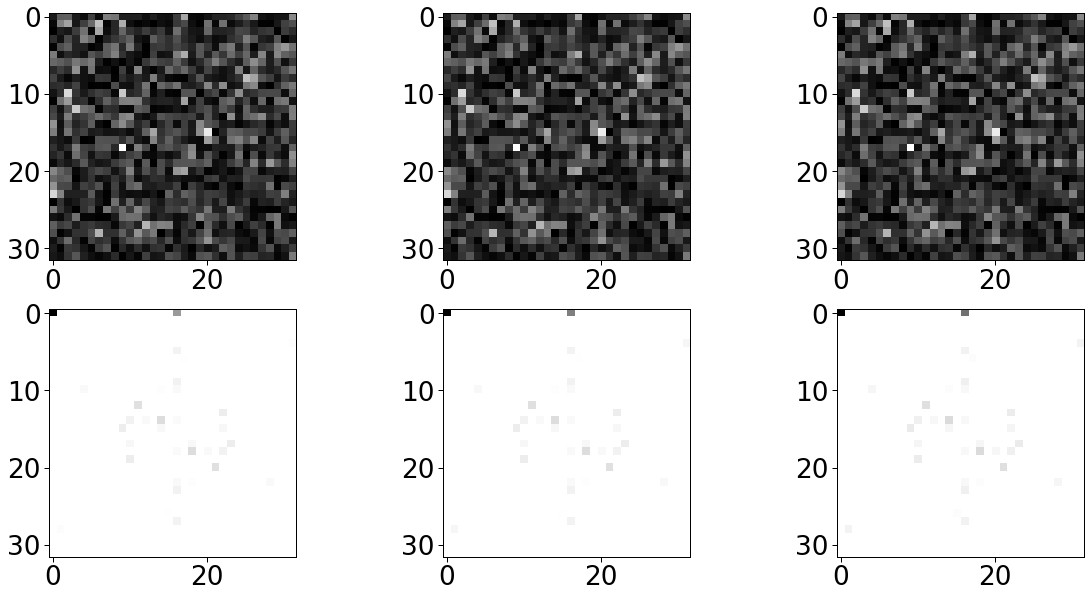

1 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 253/512 (49%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.248441800, Accuracy: 494/512 (96%)


Train set: Avg. loss: 0.072732098, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.034181375, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020610856, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014190028, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008285893, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005657797, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004219162, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003326333, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002724543, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.0928e+09))

Train set: Avg. loss: 0.001354515, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000873646, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000492515, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000336139, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000252546, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000105923, A

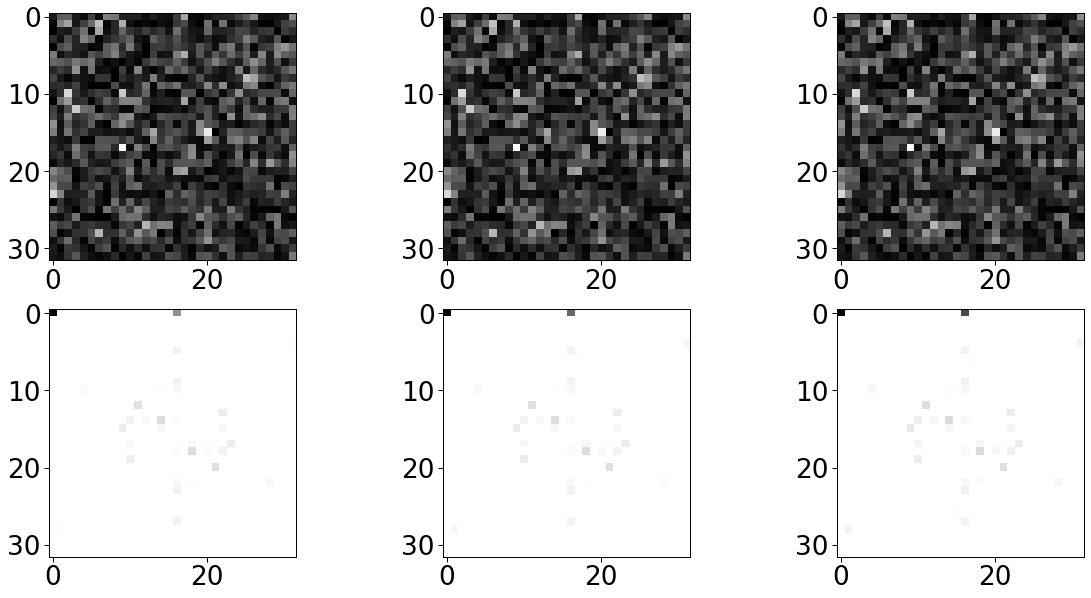

1 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 267/512 (52%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.247025505, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.072476976, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.034111194, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020584546, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014178559, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008283717, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005658065, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004220209, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003327633, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002725916, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1028e+09))

Train set: Avg. loss: 0.001355631, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000874515, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000493096, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000336572, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000252891, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106085, A

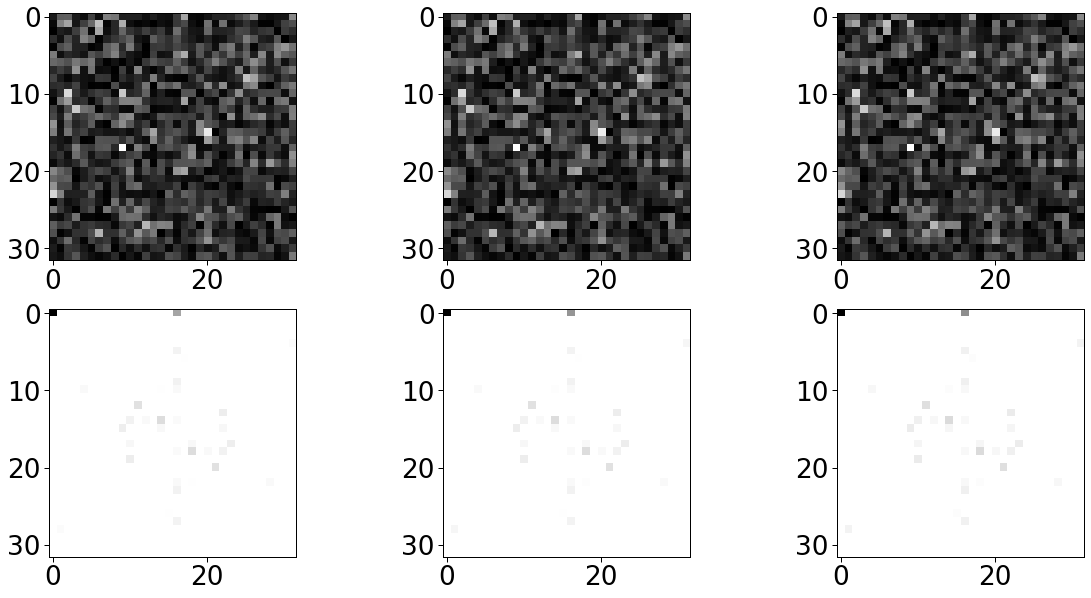

1 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 293/512 (57%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.244202942, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071971580, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033974655, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020535000, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014158302, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008281445, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005660318, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004223812, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003331583, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002729858, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1219e+09))

Train set: Avg. loss: 0.001358613, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000876808, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000494625, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000337725, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000253814, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106531, A

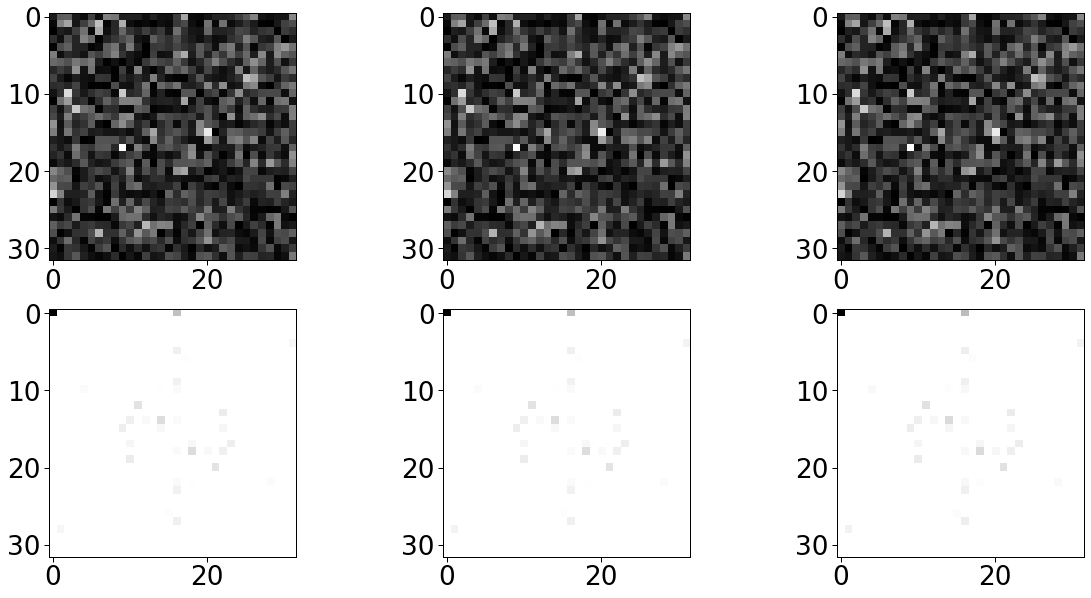

1 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 212/512 (41%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.243001357, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071753383, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033913106, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020510945, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014147106, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008278521, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005659726, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004224053, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003332165, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002730585, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1270e+09))

Train set: Avg. loss: 0.001359327, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000877393, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000495033, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000338038, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000254069, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106657, A

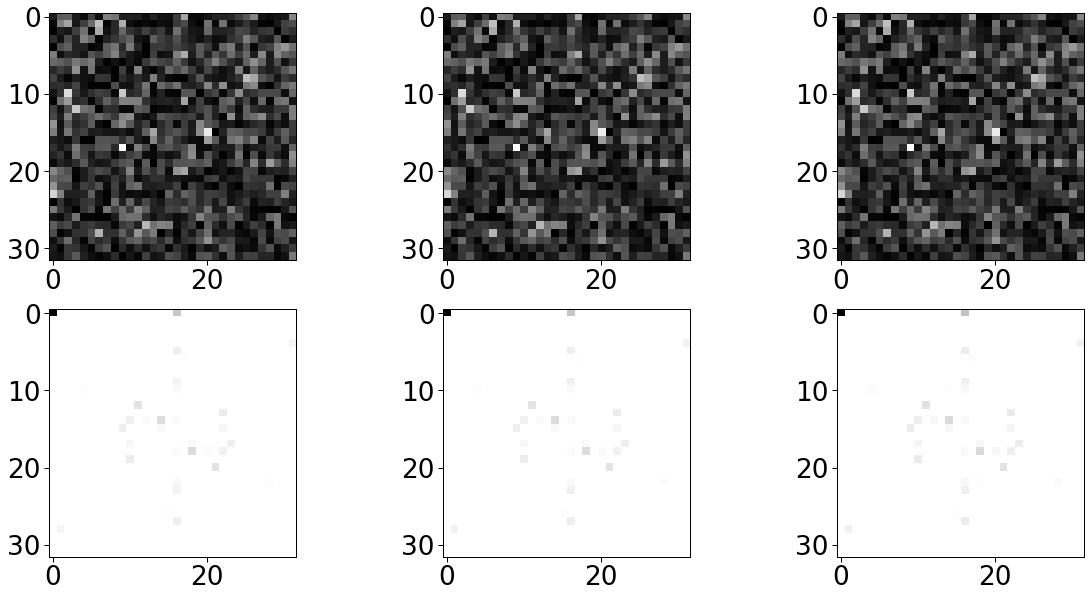

1 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 249/512 (49%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.245629191, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.072210789, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.034027860, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020546399, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014156846, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008273719, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005652070, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004216078, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003324529, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002723442, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1011e+09))

Train set: Avg. loss: 0.001354472, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000873756, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000492649, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000336256, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000252645, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000105976, A

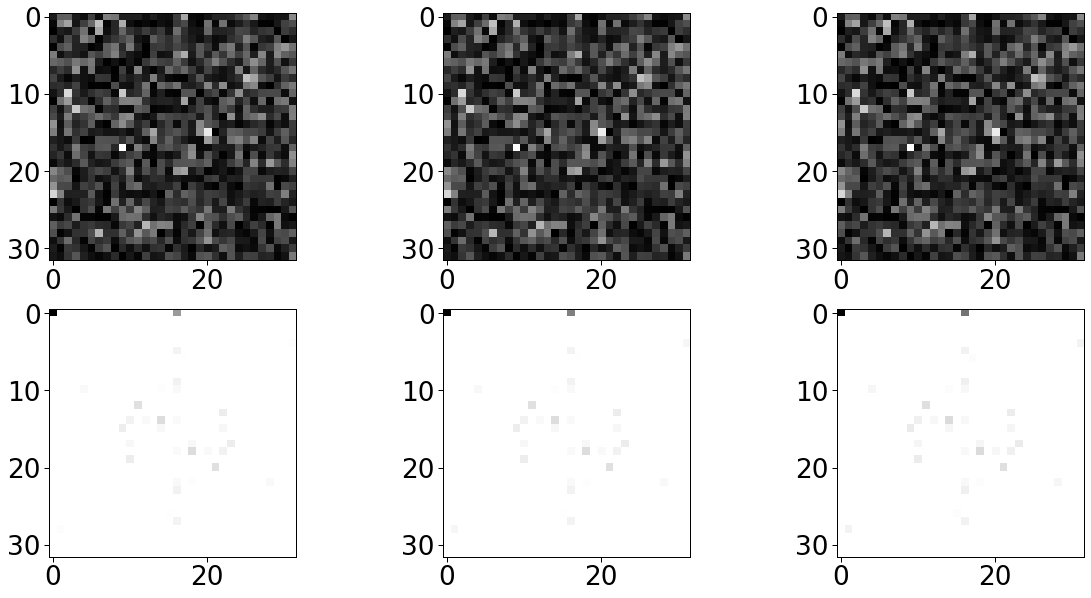

1 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 276/512 (54%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.246211544, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.072334930, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.034075931, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020573784, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014175741, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008285333, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005660520, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004222762, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003330079, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002728197, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1136e+09))

Train set: Avg. loss: 0.001357171, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000875659, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000493839, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000337126, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000253331, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106295, A

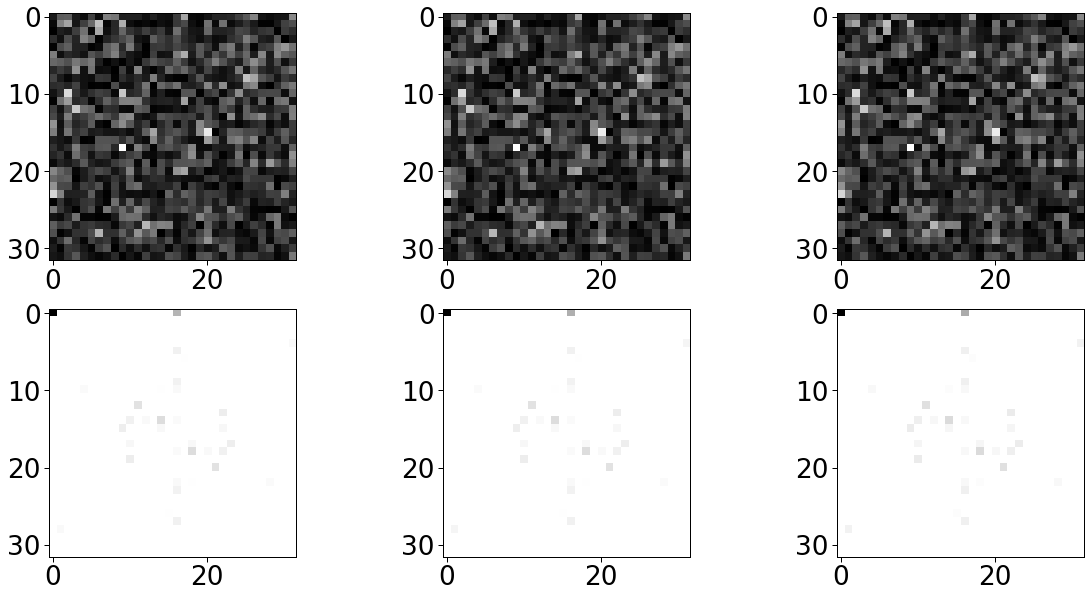

1 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 245/512 (48%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.243736476, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071880370, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033944335, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020520162, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014149231, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008276692, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005657166, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004221472, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003329718, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002728303, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1197e+09))

Train set: Avg. loss: 0.001357775, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000876228, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000494262, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000337458, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000253604, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106430, A

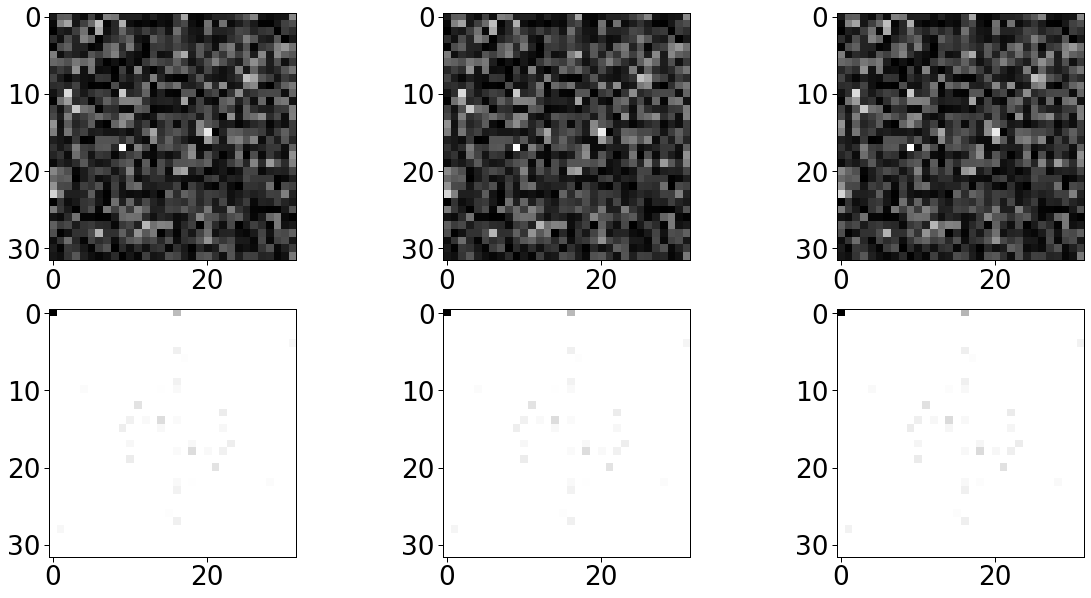

1 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 215/512 (42%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.243757680, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071873590, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033935182, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020511767, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014141954, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008271090, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005652658, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004217701, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003326477, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002725463, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1114e+09))

Train set: Avg. loss: 0.001356065, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000874988, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000493473, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000336874, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000253139, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106209, A

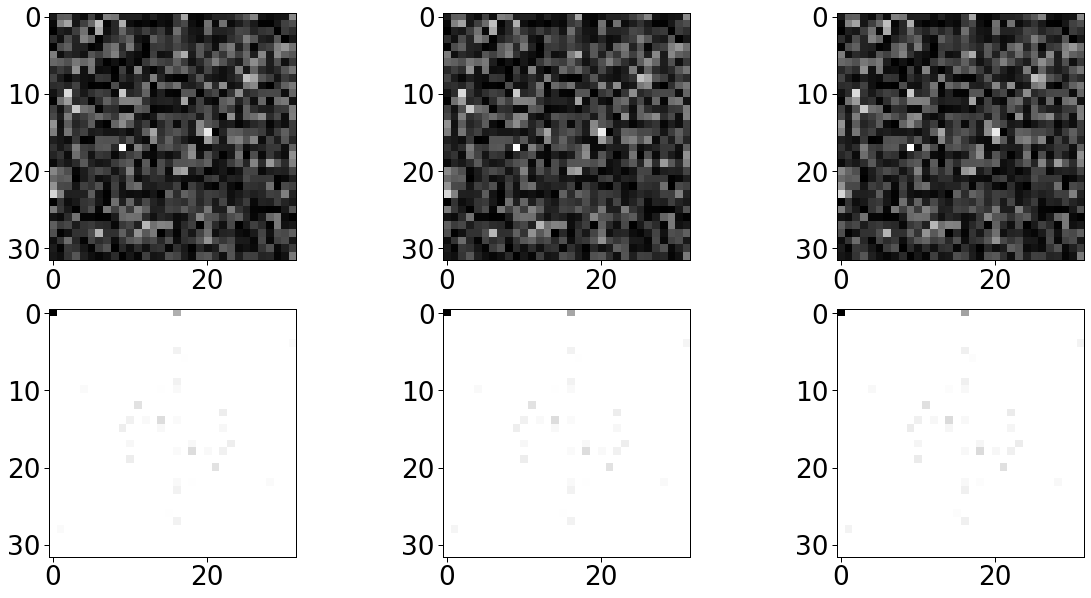

1 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 284/512 (55%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.242100447, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071565256, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033844251, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020473799, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014122556, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008264189, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005649568, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004216149, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003325670, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002725050, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1186e+09))

Train set: Avg. loss: 0.001356187, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000875167, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000493627, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000336999, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000253243, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106262, A

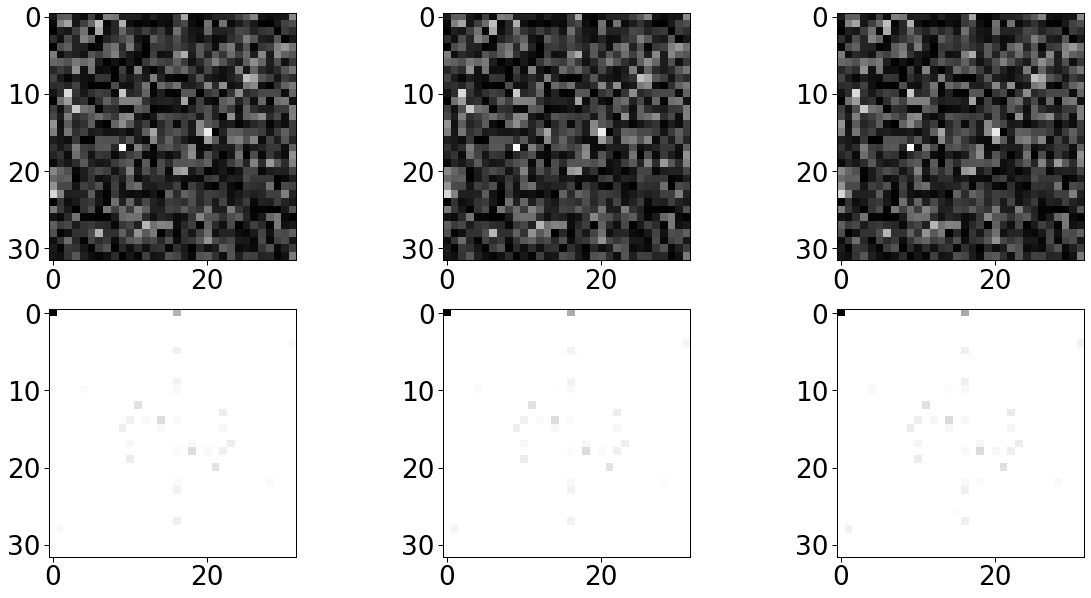

1 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 254/512 (50%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.239319384, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071018547, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033660822, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020383064, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014066902, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008235147, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005630436, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004201968, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003314399, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002715708, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.0976e+09))

Train set: Avg. loss: 0.001351263, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000871794, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000491573, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000335516, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000252082, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000105730, A

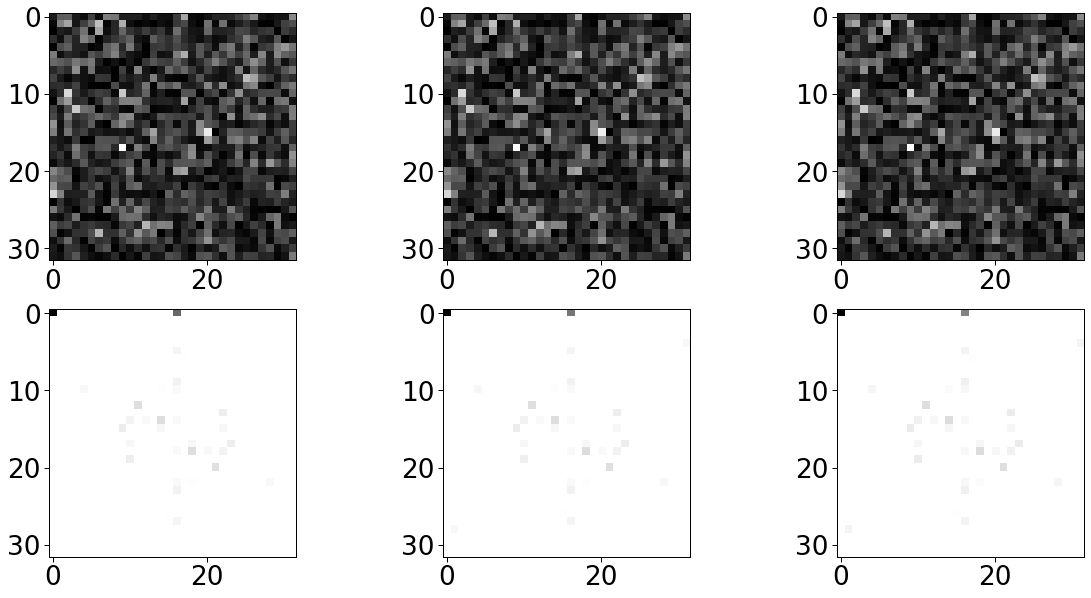

1 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 235/512 (46%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.244503886, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.072030529, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033994257, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020544628, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014164179, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008284458, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005662312, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004225302, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003332766, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002730847, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1234e+09))

Train set: Avg. loss: 0.001359145, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000877178, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000494857, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000337894, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000253949, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106595, A

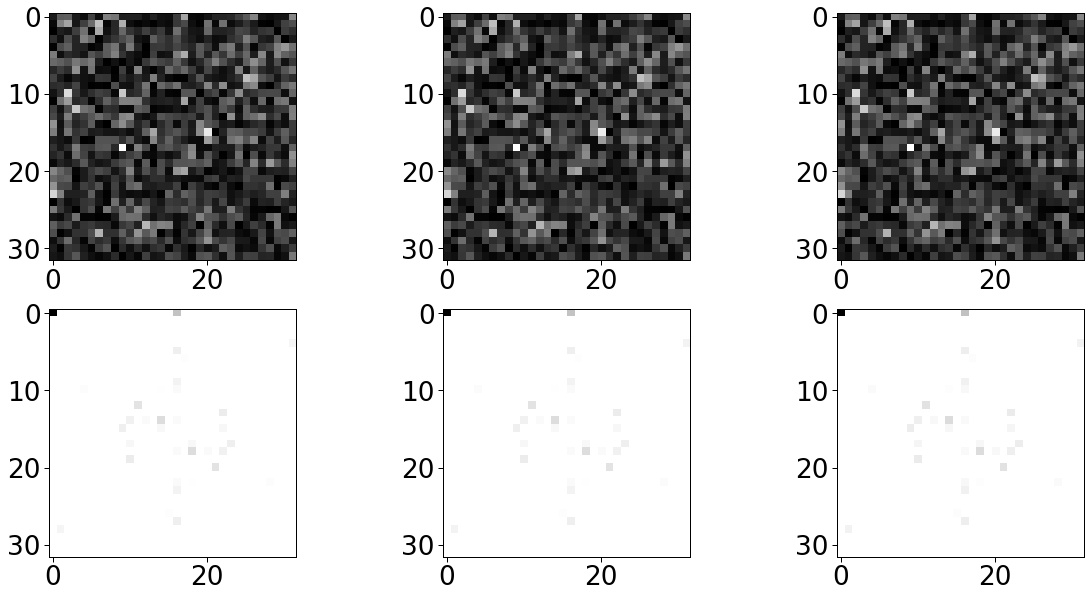

1 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 224/512 (44%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.241419390, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071419686, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033787433, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020441130, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014099961, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008250298, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005639470, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004208160, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003319037, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002719379, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1032e+09))

Train set: Avg. loss: 0.001352966, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000872891, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000492207, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000335964, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000252427, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000105883, A

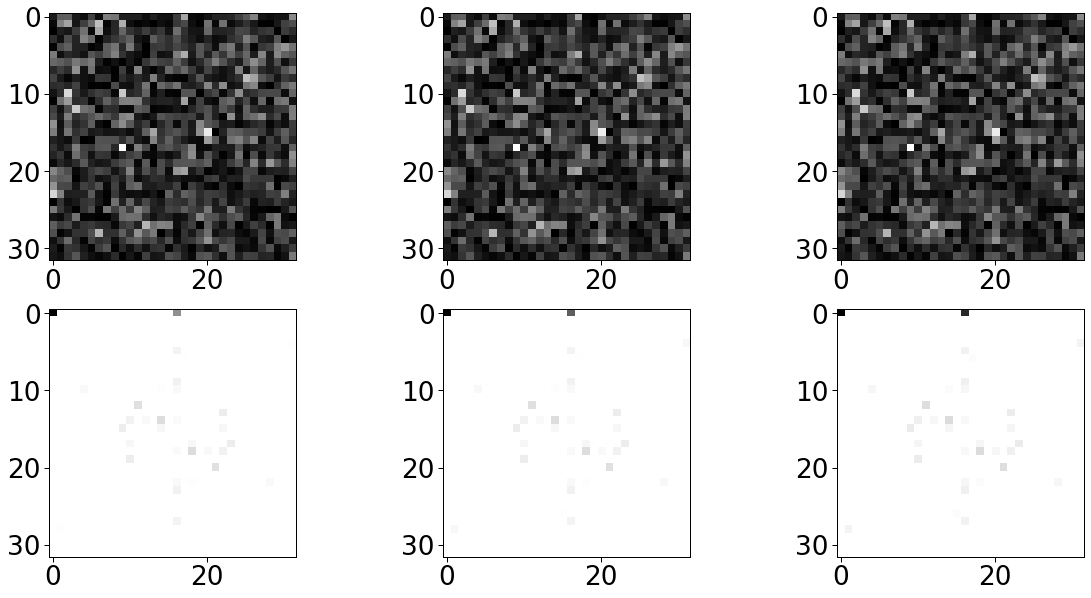

1 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 238/512 (46%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.241112188, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071318135, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033727411, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020397492, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014065485, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008226201, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005620939, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004193139, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003306425, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002708514, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.0742e+09))

Train set: Avg. loss: 0.001346764, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000868553, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000489547, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000334047, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000250933, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000105213, A

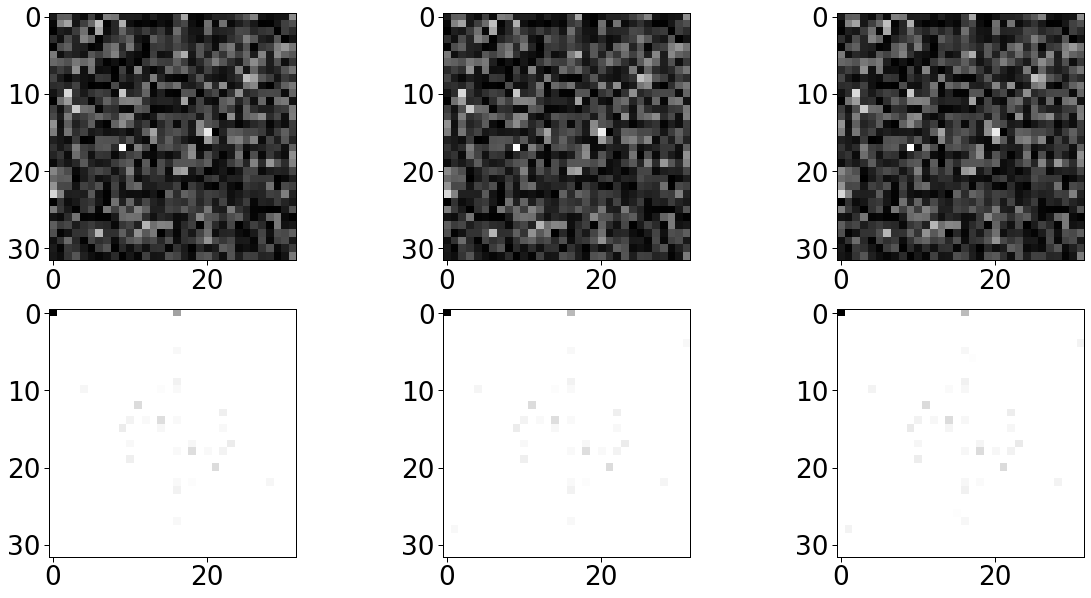

1 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 188/512 (37%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.244995058, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.072055742, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033956740, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020500839, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014123168, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008251555, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005635479, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004202799, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003313453, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002713952, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.0787e+09))

Train set: Avg. loss: 0.001349086, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000869984, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000490329, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000334581, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000251336, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000105384, A

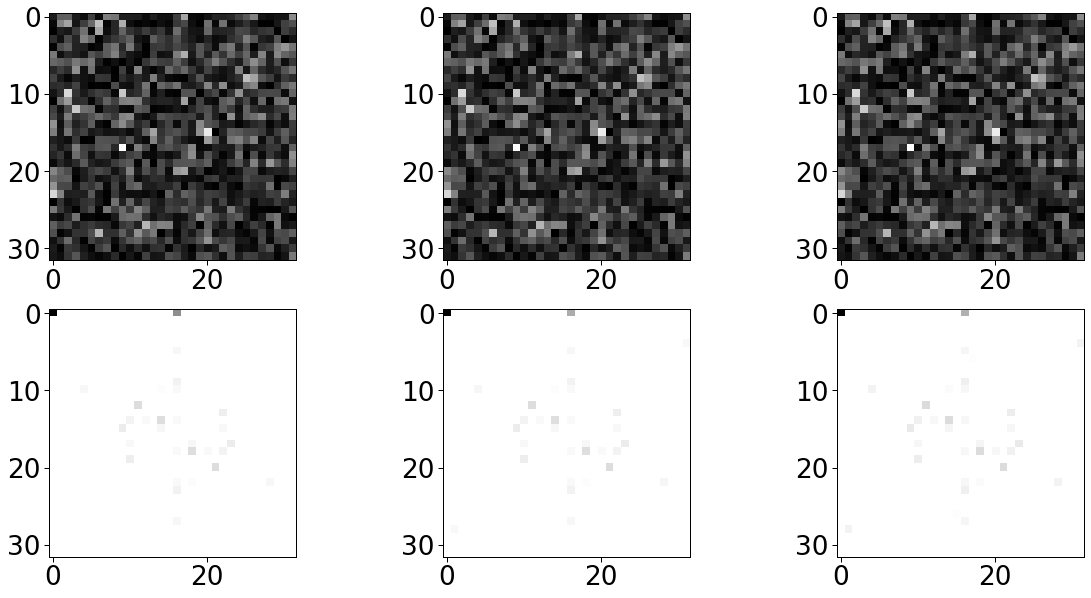

1 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 210/512 (41%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.239739642, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071113214, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033700615, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020407153, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014084161, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008246168, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005638604, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004208454, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003319804, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002720334, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1100e+09))

Train set: Avg. loss: 0.001353893, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000873637, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000492718, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000336347, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000252734, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106029, A

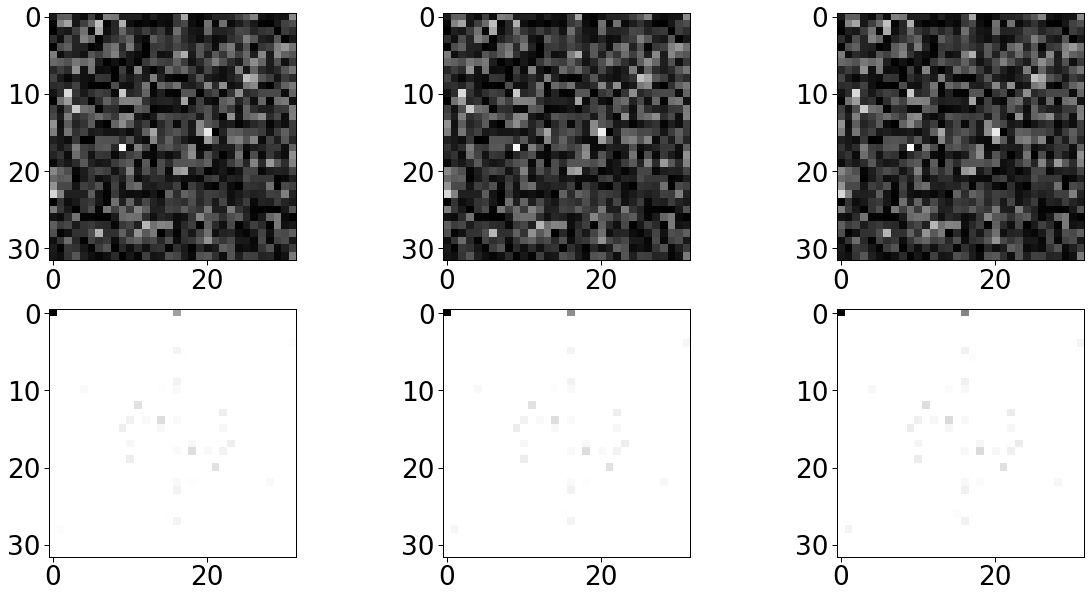

1 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 272/512 (53%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.240227371, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071204789, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033728346, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020419145, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014090536, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008248726, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005639935, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004209255, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003320334, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002720708, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1108e+09))

Train set: Avg. loss: 0.001354009, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000873695, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000492742, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000336362, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000252743, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106033, A

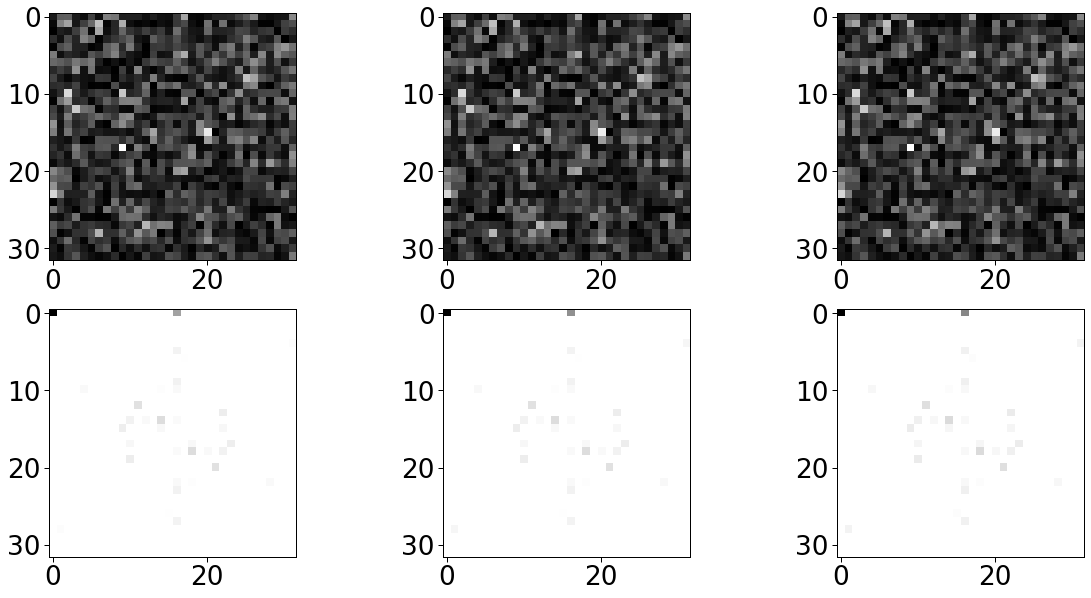

1 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 253/512 (49%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.240410283, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071270414, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033769172, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020449776, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014115308, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008266575, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005653970, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004220856, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003330224, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002729338, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1343e+09))

Train set: Avg. loss: 0.001359160, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000877411, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000495113, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000338115, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000254138, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000106698, A

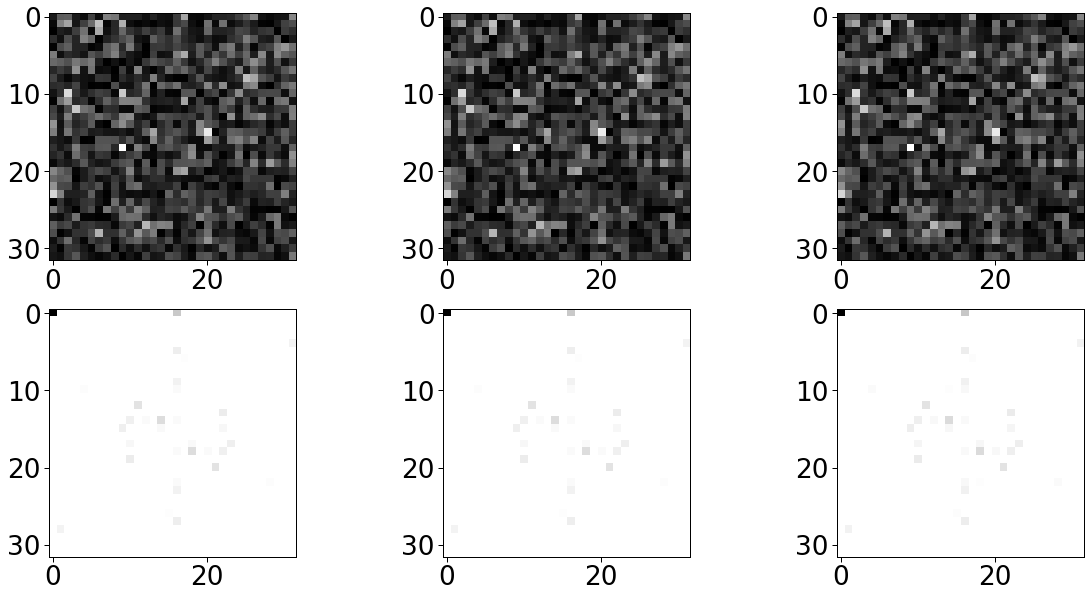

1 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 188/512 (37%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.241072819, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071298502, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033713236, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020386450, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014056521, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008219808, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005616017, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004189161, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003303094, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002705656, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.0639e+09))

Train set: Avg. loss: 0.001345165, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000867450, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000488883, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000333576, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000250569, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000105055, A

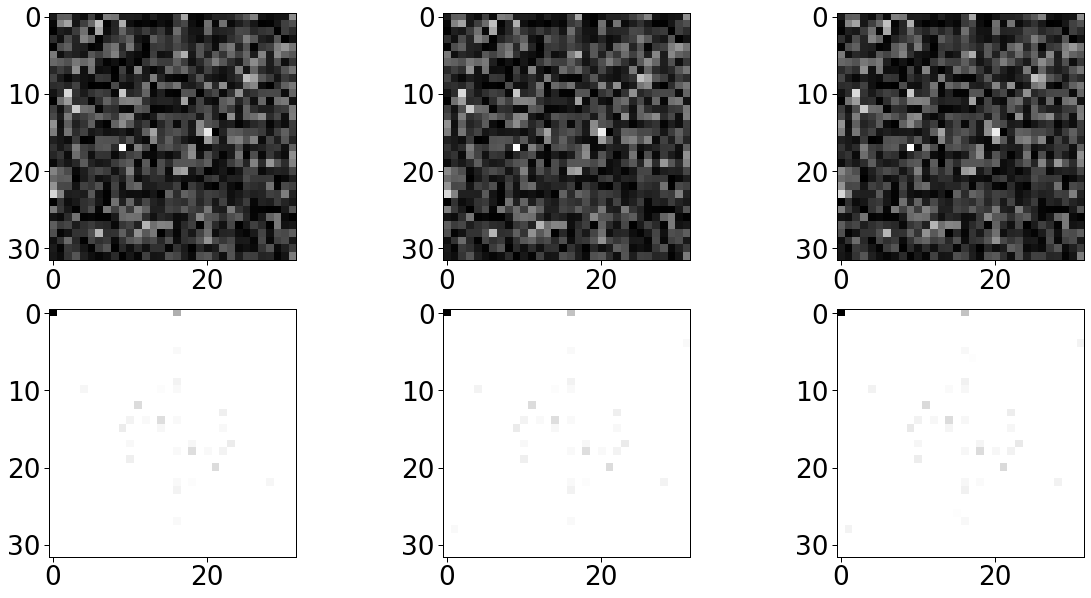

1 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 221/512 (43%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.239743993, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071045369, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033634365, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020350955, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014036755, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008211186, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005611117, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004185928, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003300764, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002703872, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.0647e+09))

Train set: Avg. loss: 0.001344427, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000867006, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000488644, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000333415, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000250448, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000105006, A

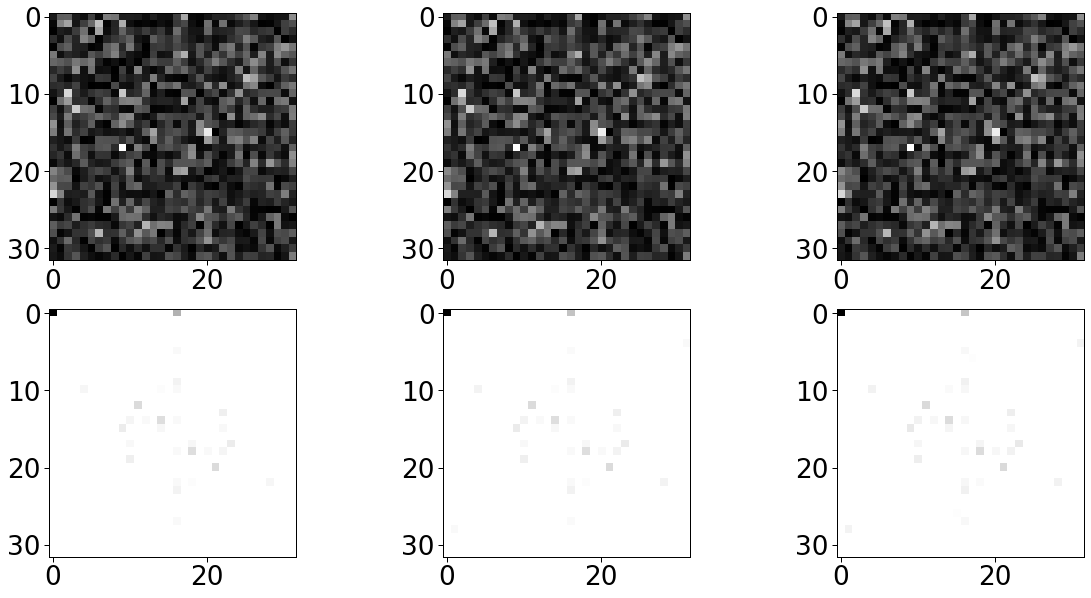

1 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 201/512 (39%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.238312334, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.070841506, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033615541, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020368531, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014062406, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008236443, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005632919, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004204614, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003316960, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002718103, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.1091e+09))

Train set: Avg. loss: 0.001352881, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000872993, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000492345, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000336086, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000252532, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000105939, A

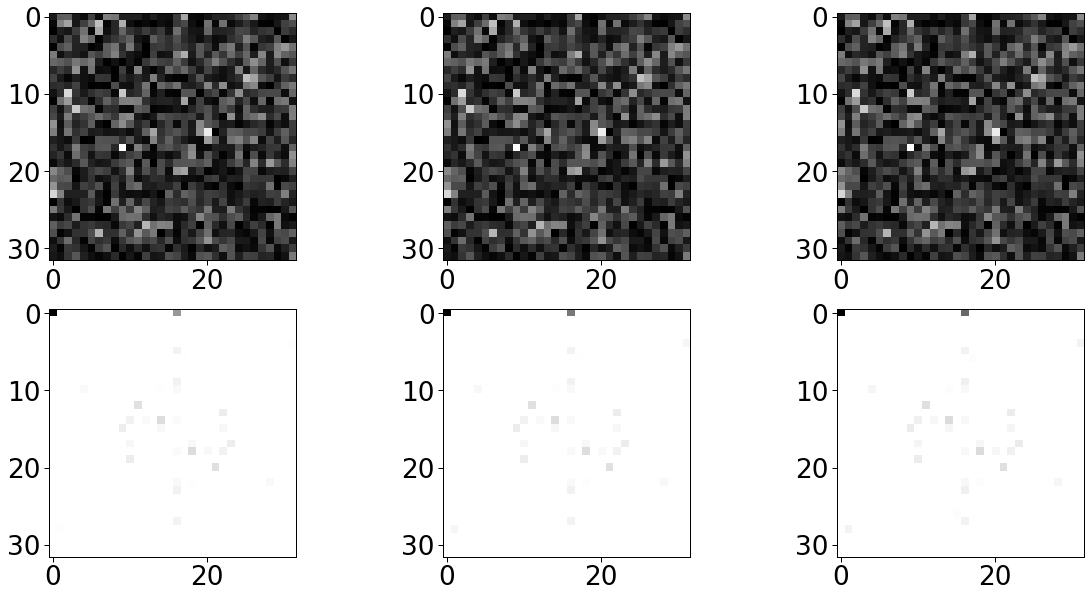

1 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 285/512 (56%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.240117043, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071070910, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033613633, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020325370, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014012884, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008192511, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005596281, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004173768, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003290522, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002695070, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.0396e+09))

Train set: Avg. loss: 0.001339506, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000863633, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000486637, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000332000, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000249364, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000104542, A

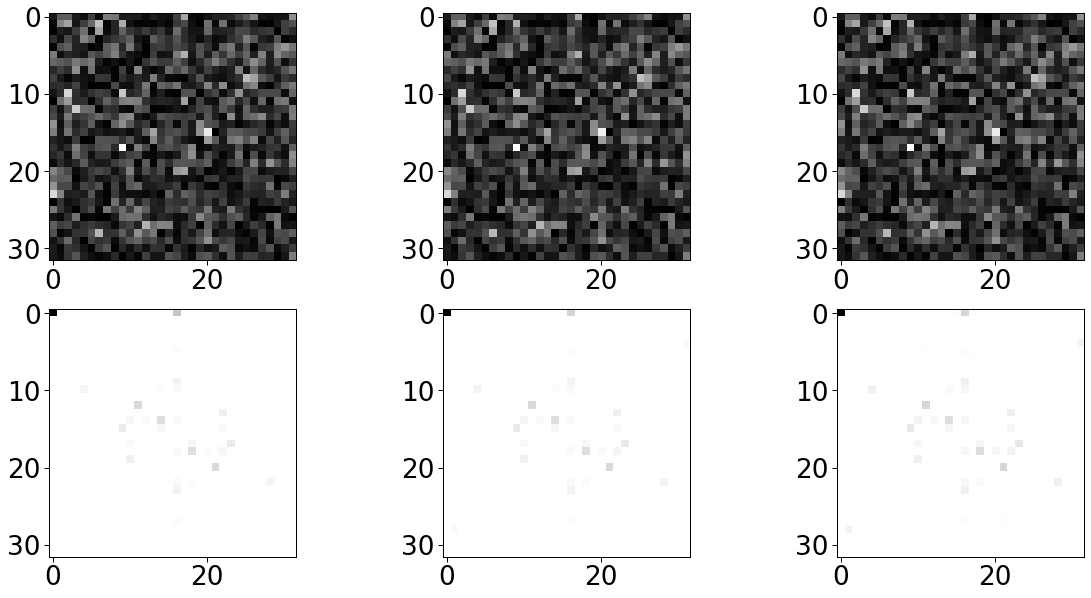

1 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 229/512 (45%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.238335550, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.070827164, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033599108, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020354068, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014050047, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008227145, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005625534, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004198504, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003311769, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002713593, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.0973e+09))

Train set: Avg. loss: 0.001350244, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000871124, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000491182, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000335240, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000251869, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000105636, A

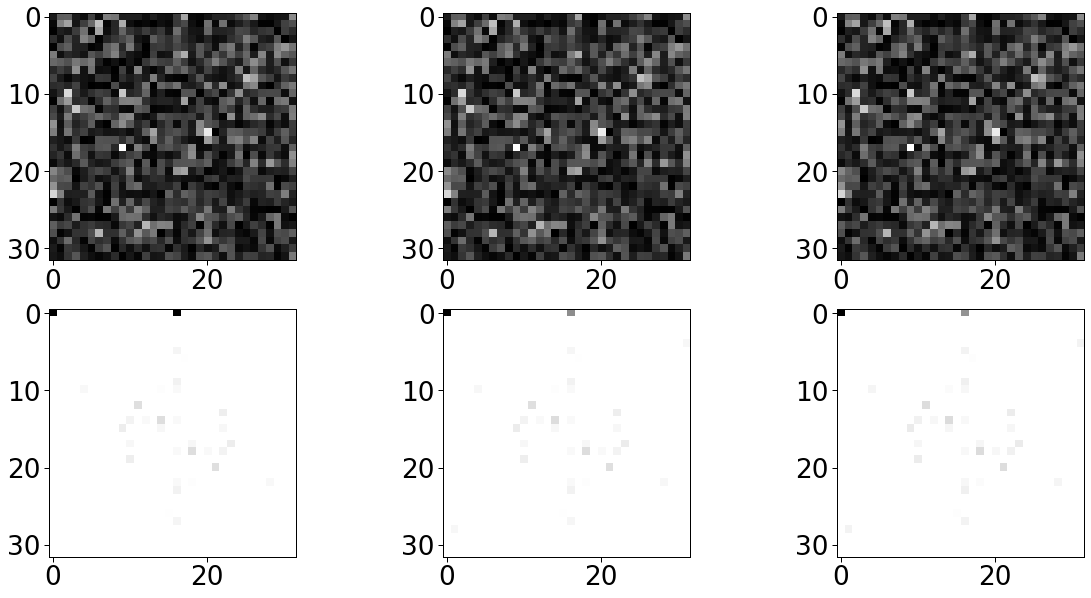

1 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 248/512 (48%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.237468809, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.070656590, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033542104, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020326143, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014033093, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008218478, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005619943, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004194425, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003308567, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002710960, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.0933e+09))

Train set: Avg. loss: 0.001348901, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000870220, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000490646, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000334859, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000251574, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000105505, A

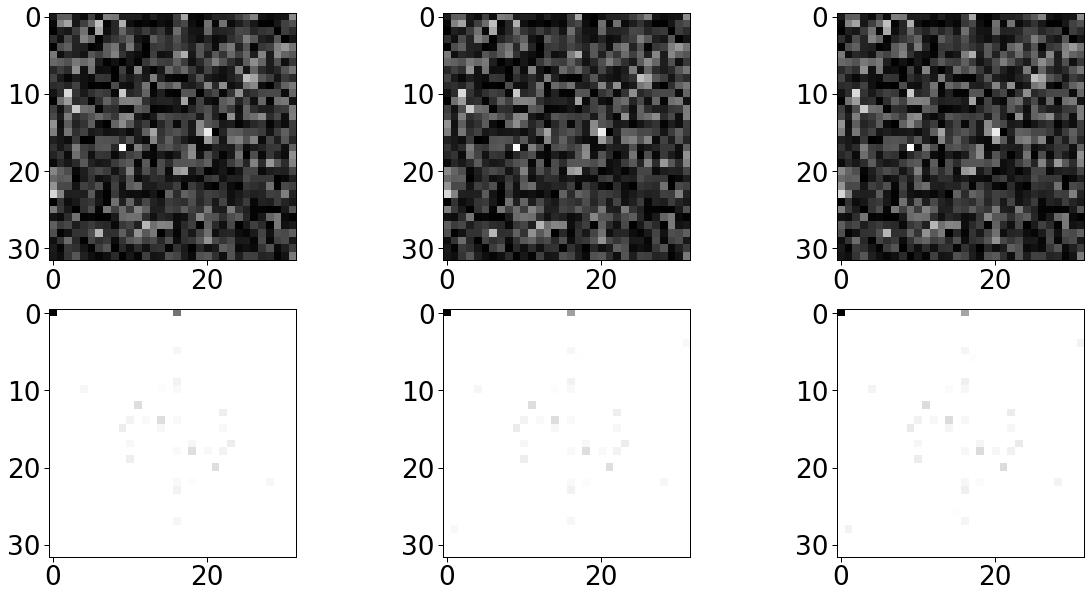

1 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 326/512 (64%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.246674478, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.072276480, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033963397, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020469077, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014084882, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008217205, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005606887, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004178844, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003293024, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002696228, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.0241e+09))

Train set: Avg. loss: 0.001338974, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000862995, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000486134, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000331612, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000249052, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000104400, A

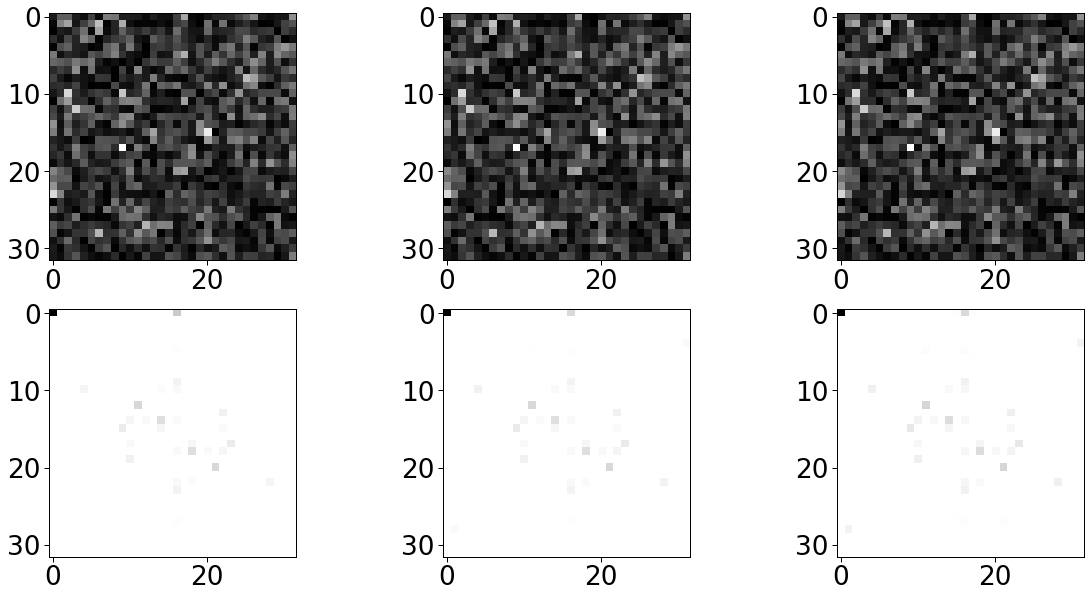

1 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 317/512 (62%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.237500772, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.070612460, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033496335, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020287106, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014000226, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008194396, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005601166, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004179130, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003295707, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002699898, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.0620e+09))

Train set: Avg. loss: 0.001342652, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000865893, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000488027, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000332994, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000250131, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000104873, A

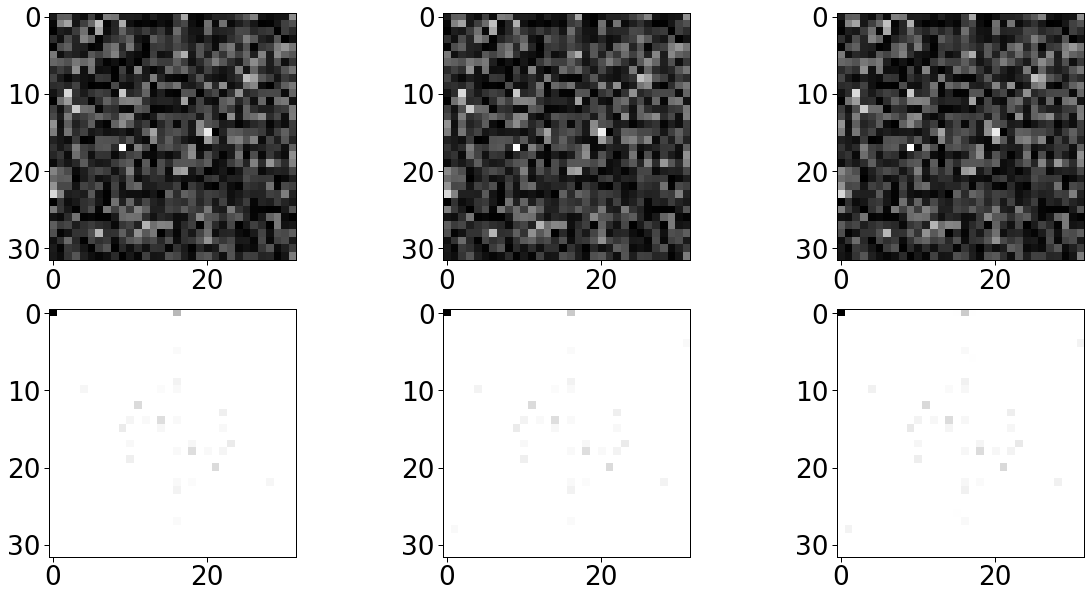

1 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 322/512 (63%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.241321802, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071309321, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033693355, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020364307, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014036334, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008204261, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005603718, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004179085, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003294618, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002698371, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.0416e+09))

Train set: Avg. loss: 0.001341086, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000864650, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000487210, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000332394, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000249661, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000104666, A

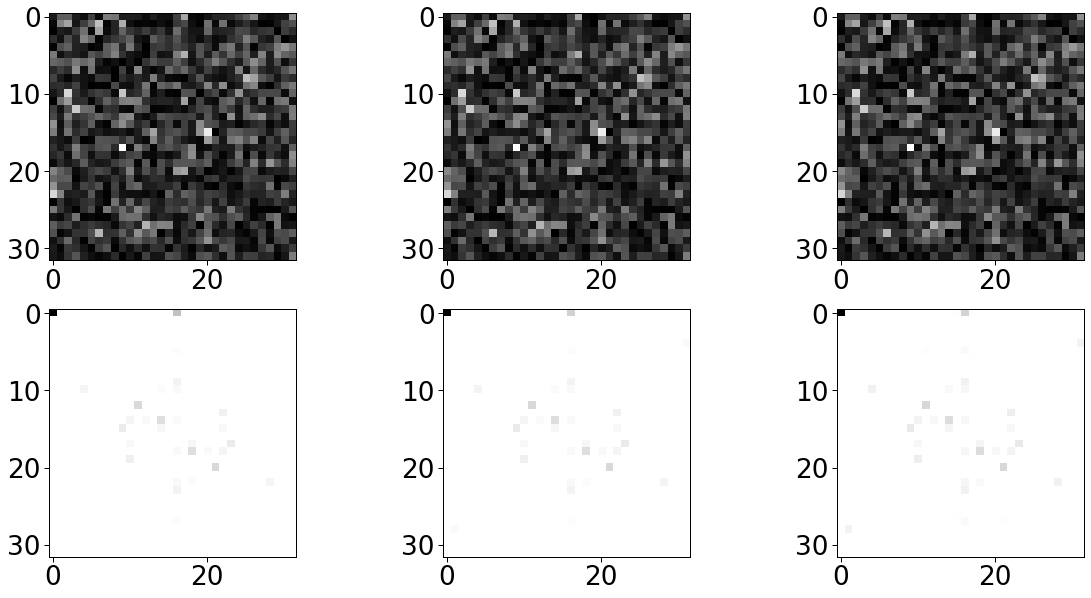

1 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 251/512 (49%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.241532713, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.071429551, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033782609, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.020434316, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.014093271, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008244781, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005634944, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004204365, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003315775, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002716527, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.0959e+09))

Train set: Avg. loss: 0.001351274, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000871690, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000491455, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000335416, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000251997, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000105687, A

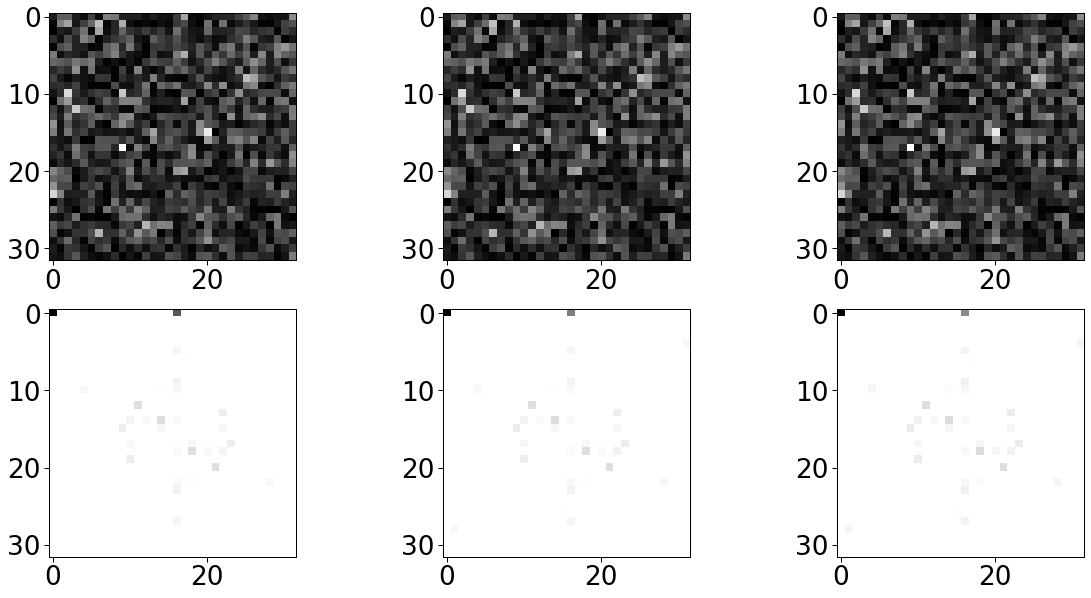

(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 2)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 3)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 4)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)

  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.290029794, Accuracy: 484/512 (95%)


Train set: Avg. loss: 0.075457618, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.031610623, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.018245667, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012327248, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.007093161, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004800027, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003567449, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002809105, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002300257, Accuracy: 512/512 (100%)

(tensor(65.), tensor(7.1407e+12))

Train set: Avg. loss: 0.001142179, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000733385, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000414153, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000282518, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000212601, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000089321, A

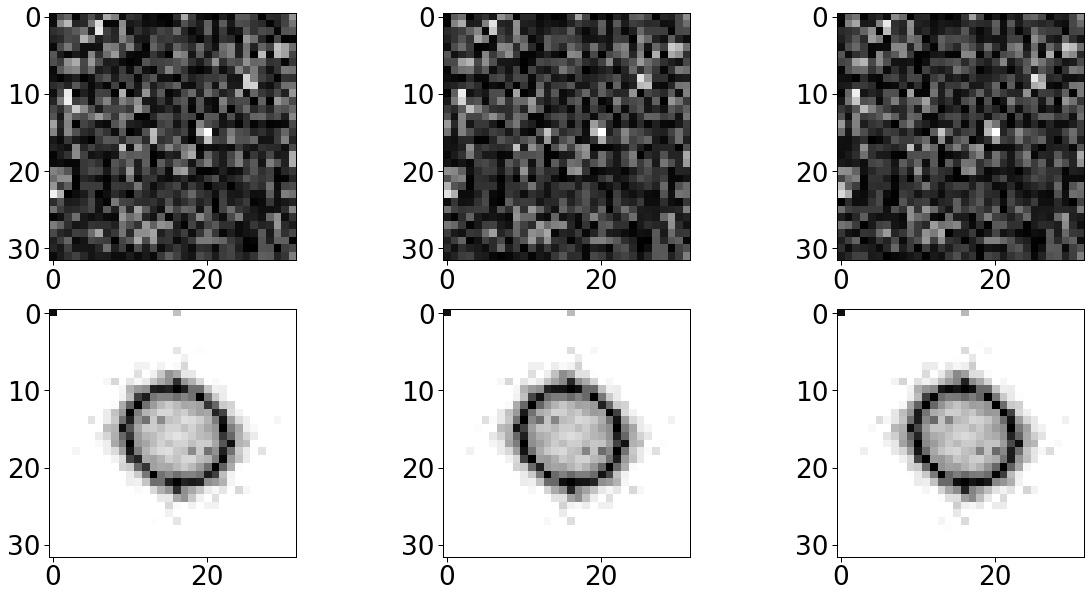

3 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 198/512 (39%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.287442088, Accuracy: 484/512 (95%)


Train set: Avg. loss: 0.074924208, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.031476177, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.018193239, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012300786, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.007083212, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004795131, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003564607, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002807271, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002298988, Accuracy: 512/512 (100%)

(tensor(65.), tensor(7.0901e+12))

Train set: Avg. loss: 0.001141840, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000733240, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000414106, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000282494, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000212588, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000089318, A

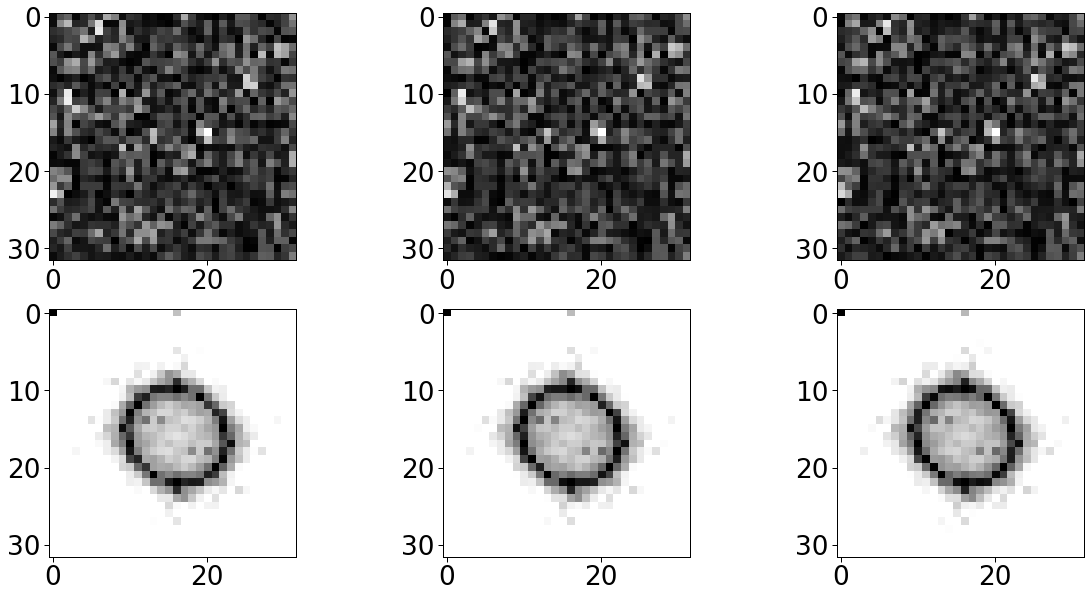

3 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 309/512 (60%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.286485344, Accuracy: 484/512 (95%)


Train set: Avg. loss: 0.074727155, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.031427193, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.018174309, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012291256, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.007079634, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004793375, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003563588, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002806616, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002298541, Accuracy: 512/512 (100%)

(tensor(65.), tensor(7.0584e+12))

Train set: Avg. loss: 0.001141714, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000733191, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000414089, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000282488, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000212585, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000089317, A

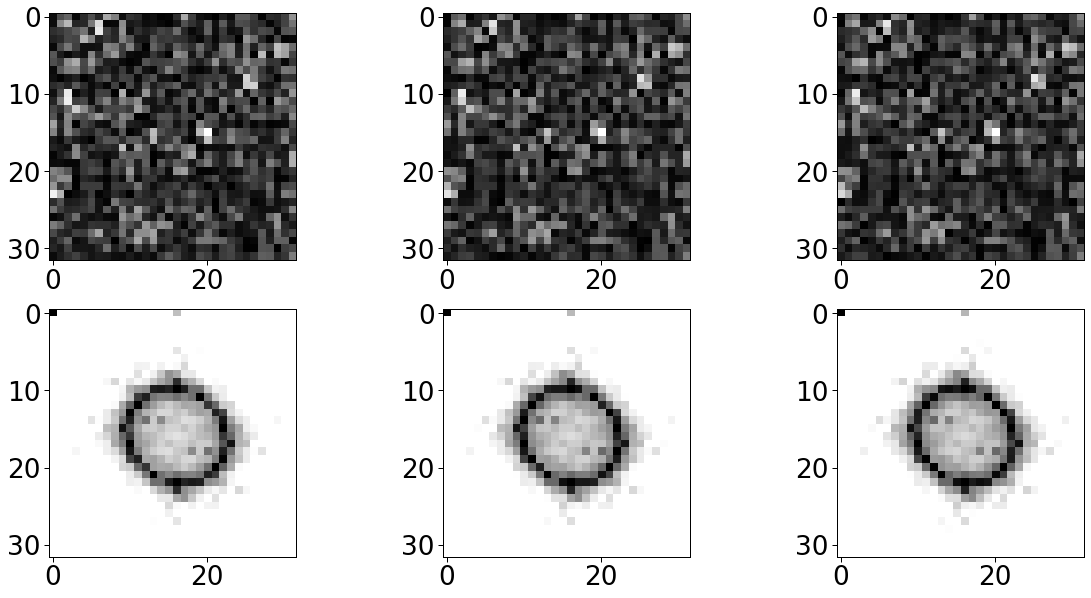

3 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 272/512 (53%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.289948821, Accuracy: 484/512 (95%)


Train set: Avg. loss: 0.075447977, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.031606831, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.018243939, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012326322, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.007092819, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004799827, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003567331, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002809024, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002300198, Accuracy: 512/512 (100%)

(tensor(65.), tensor(7.1973e+12))

Train set: Avg. loss: 0.001142163, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000733368, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000414144, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000282509, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000212596, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000089319, A

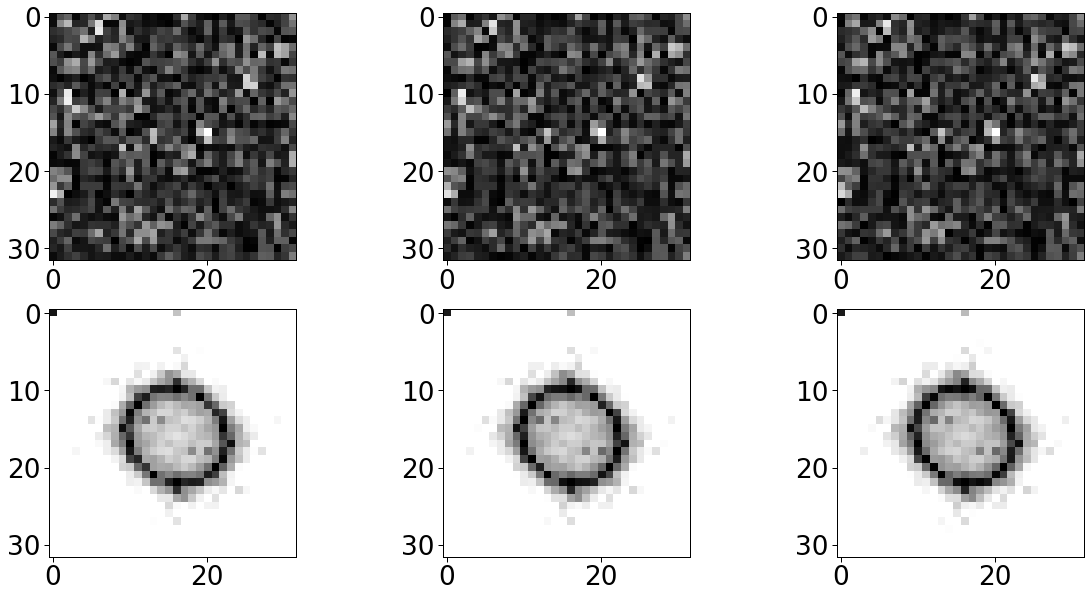

3 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 260/512 (51%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.287970096, Accuracy: 484/512 (95%)


Train set: Avg. loss: 0.075019442, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.031497810, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.018200884, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012304245, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.007084248, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004795500, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003564746, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002807318, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002298990, Accuracy: 512/512 (100%)

(tensor(64.), tensor(7.2365e+12))

Train set: Avg. loss: 0.001141806, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000733208, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000414086, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000282480, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000212577, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000089314, A

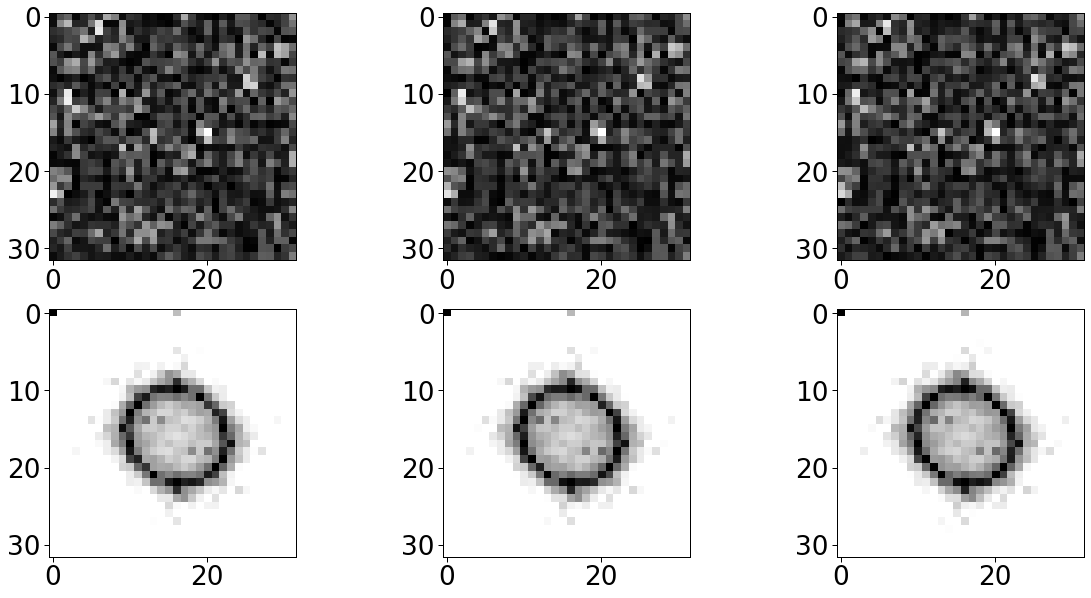

3 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 301/512 (59%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.286823094, Accuracy: 484/512 (95%)


Train set: Avg. loss: 0.074796289, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.031444483, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.018180912, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012294547, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.007080848, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004793975, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003563934, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002806841, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002298695, Accuracy: 512/512 (100%)

(tensor(65.), tensor(7.0463e+12))

Train set: Avg. loss: 0.001141756, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000733209, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000414094, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000282490, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000212586, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000089317, A

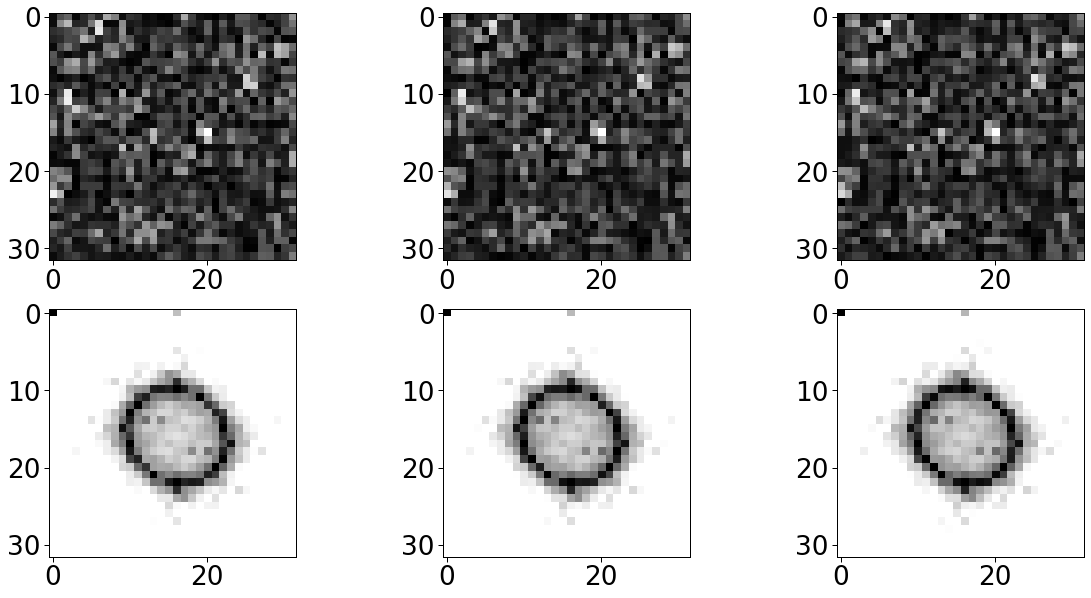

3 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 292/512 (57%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.286334991, Accuracy: 484/512 (95%)


Train set: Avg. loss: 0.074689522, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.031414345, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.018168384, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012287900, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.007078187, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004792558, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003563050, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002806234, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002298248, Accuracy: 512/512 (100%)

(tensor(65.), tensor(7.2201e+12))

Train set: Avg. loss: 0.001141619, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000733133, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000414061, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000282471, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000212572, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000089314, A

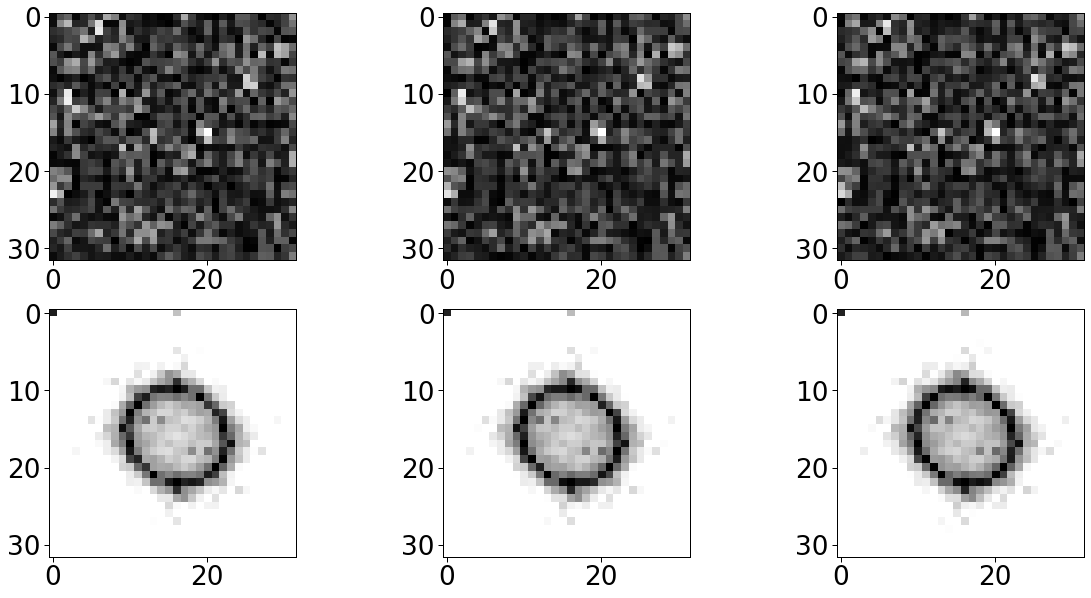

3 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 270/512 (53%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.290015608, Accuracy: 484/512 (95%)


Train set: Avg. loss: 0.075446419, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.031607632, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.018244458, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012326586, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.007092853, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004799860, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003567345, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002809032, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002300197, Accuracy: 512/512 (100%)

(tensor(65.), tensor(7.0862e+12))

Train set: Avg. loss: 0.001142153, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000733372, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000414145, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000282513, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000212598, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000089319, A

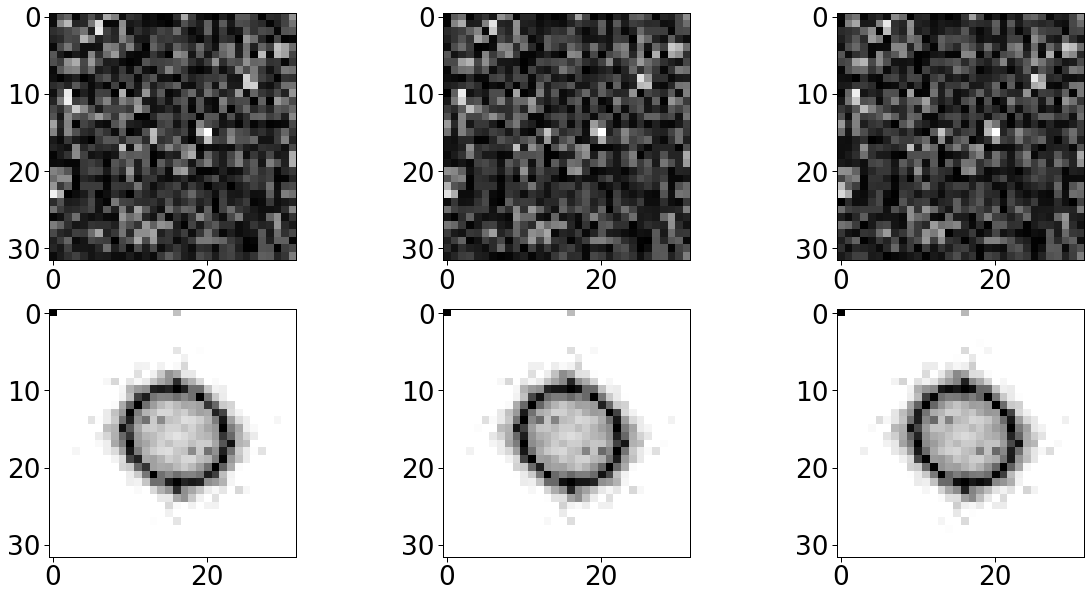

3 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 295/512 (58%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.292806953, Accuracy: 484/512 (95%)


Train set: Avg. loss: 0.076000161, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.031750619, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.018300602, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012354949, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.007103360, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004805046, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003570367, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002810984, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002301551, Accuracy: 512/512 (100%)

(tensor(64.), tensor(7.0054e+12))

Train set: Avg. loss: 0.001142490, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000733529, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000414196, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000282538, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000212613, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000089320, A

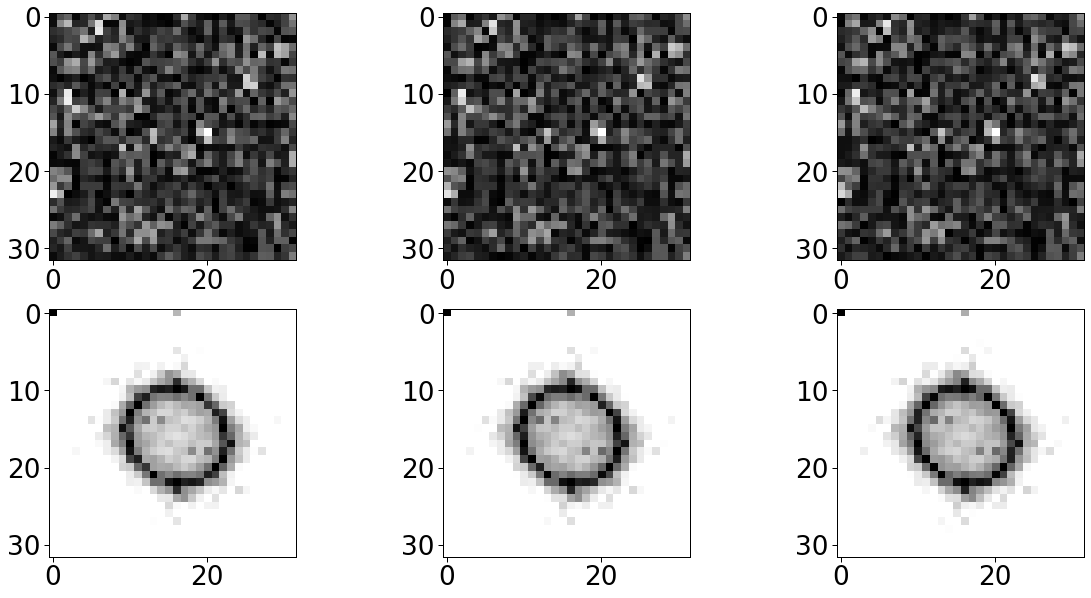

3 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 231/512 (45%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.287471414, Accuracy: 484/512 (95%)


Train set: Avg. loss: 0.074933618, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.031479664, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.018194869, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012301701, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.007083619, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004795365, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003564760, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002807386, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002299079, Accuracy: 512/512 (100%)

(tensor(65.), tensor(7.0937e+12))

Train set: Avg. loss: 0.001141869, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000733261, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000414116, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000282502, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000212594, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000089320, A

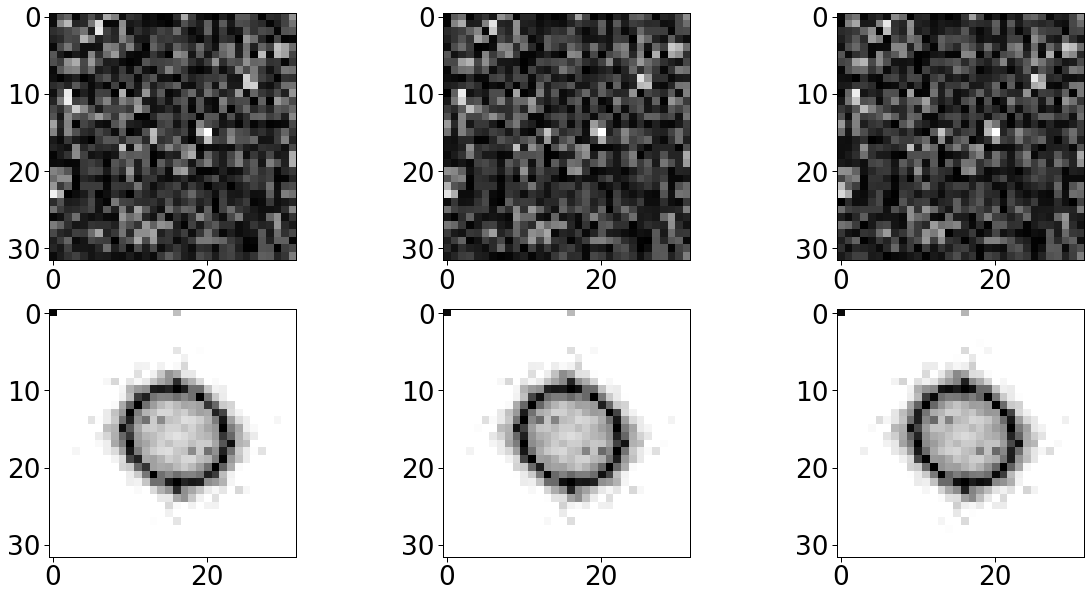

3 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 285/512 (56%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.221938357, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.051829986, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022492126, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013325987, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009149465, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005368219, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003674609, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002751465, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002178191, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001790905, Accuracy: 512/512 (100%)

(tensor(70.), tensor(1.0531e+13))

Train set: Avg. loss: 0.000899492, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580508, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329579, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225380, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169894, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071676, A

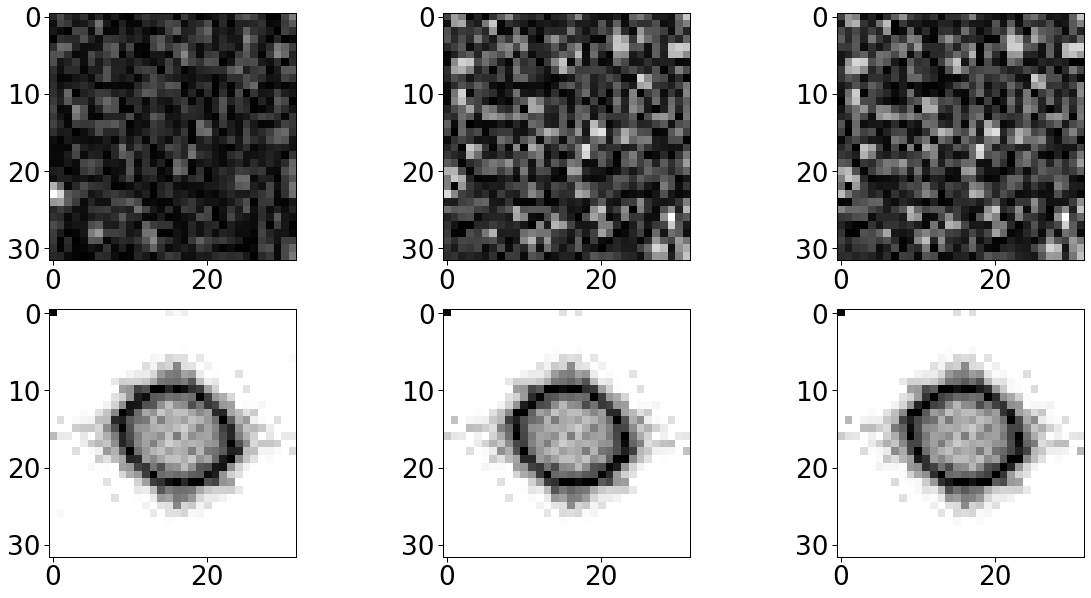

3 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 332/512 (65%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.221160874, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.051757060, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022476271, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013319734, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009146265, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005367055, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003673887, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002750962, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002177828, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001790632, Accuracy: 512/512 (100%)

(tensor(70.), tensor(1.1785e+13))

Train set: Avg. loss: 0.000899393, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580412, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329528, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225339, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169862, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071666, A

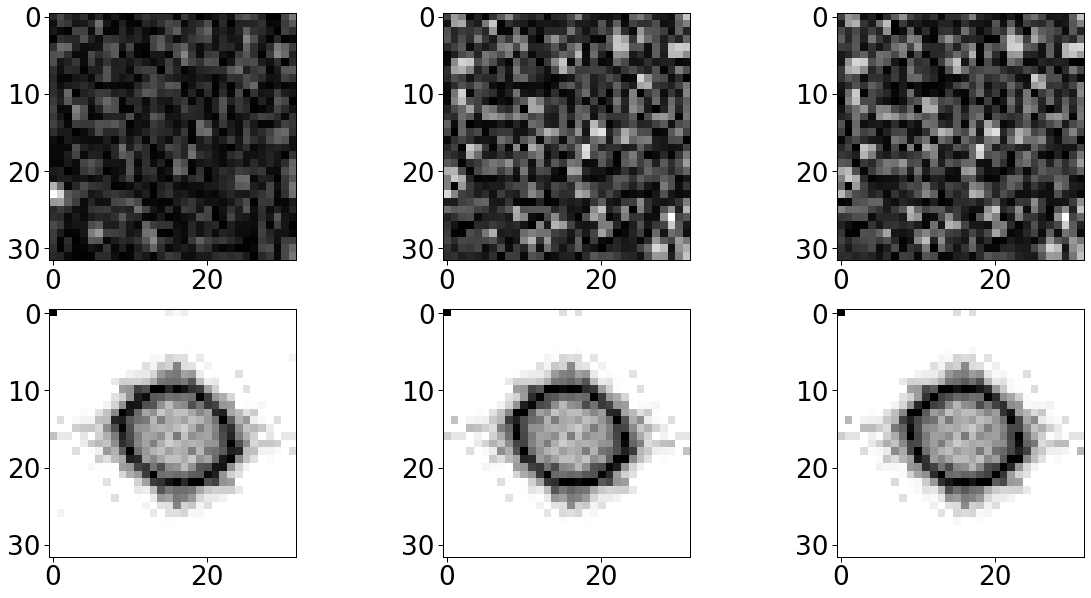

3 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 273/512 (53%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.238310546, Accuracy: 493/512 (96%)


Train set: Avg. loss: 0.053399358, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022801740, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013429871, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009194294, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005378750, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003678770, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002753131, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002178716, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001790863, Accuracy: 512/512 (100%)

(tensor(70.), tensor(5.2153e+12))

Train set: Avg. loss: 0.000898923, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580540, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329575, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225463, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169964, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071697, A

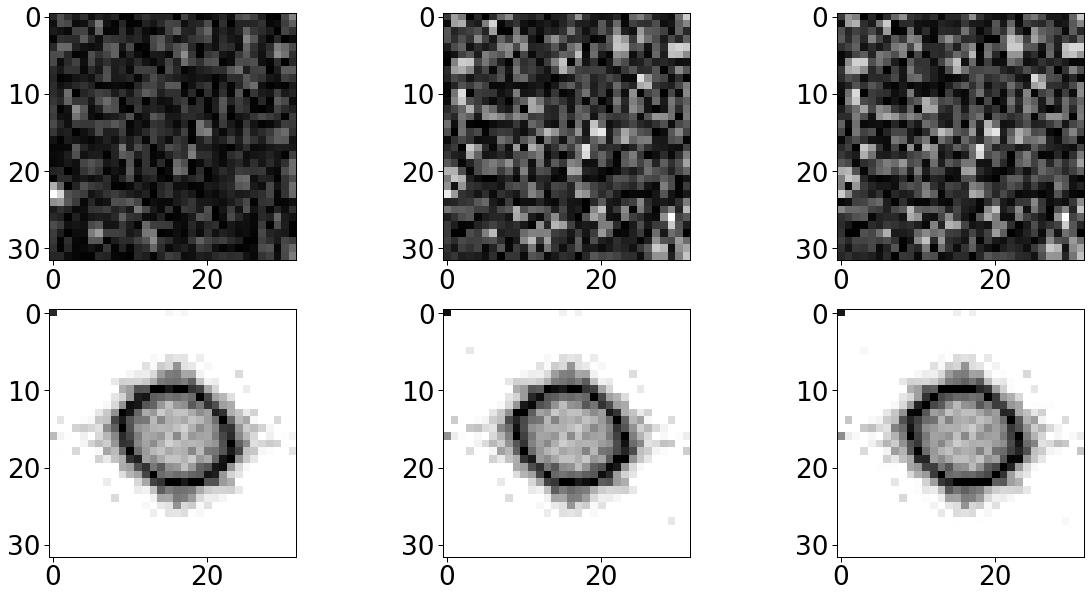

3 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 290/512 (57%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.224347770, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.052165493, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022572819, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013358033, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009165822, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005374357, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003677725, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002753309, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002179399, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001791749, Accuracy: 512/512 (100%)

(tensor(70.), tensor(9.3466e+12))

Train set: Avg. loss: 0.000899714, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580630, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329624, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225409, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169912, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071680, A

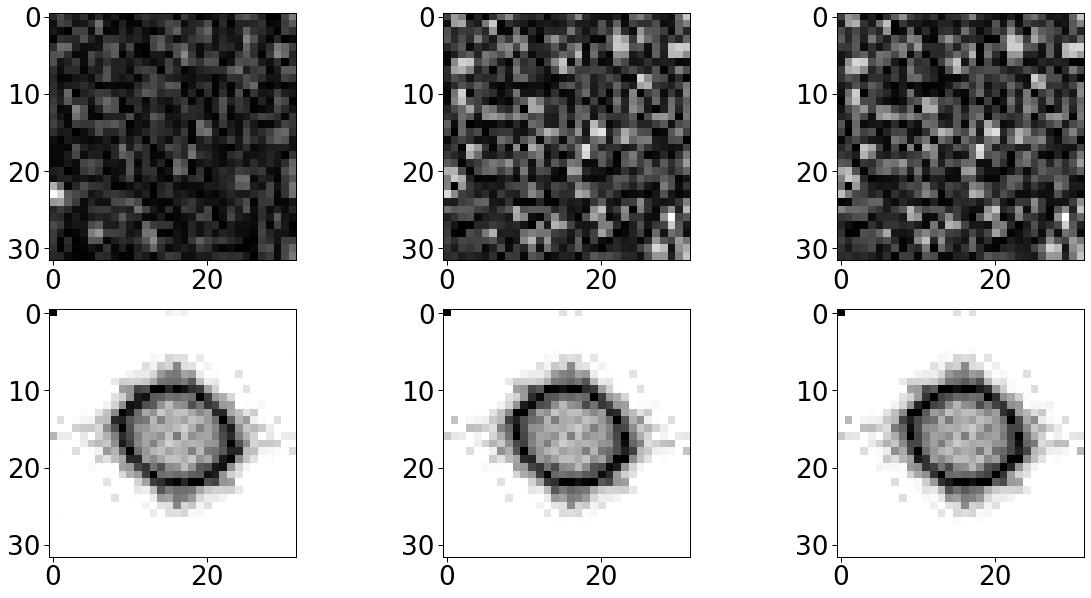

3 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 314/512 (61%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.254576445, Accuracy: 489/512 (96%)


Train set: Avg. loss: 0.055061813, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.023157492, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013561562, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009258146, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005400619, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003689858, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002759730, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002183058, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001793919, Accuracy: 512/512 (100%)

(tensor(70.), tensor(3.3129e+12))

Train set: Avg. loss: 0.000899845, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000581313, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329973, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225780, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000170204, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071786, A

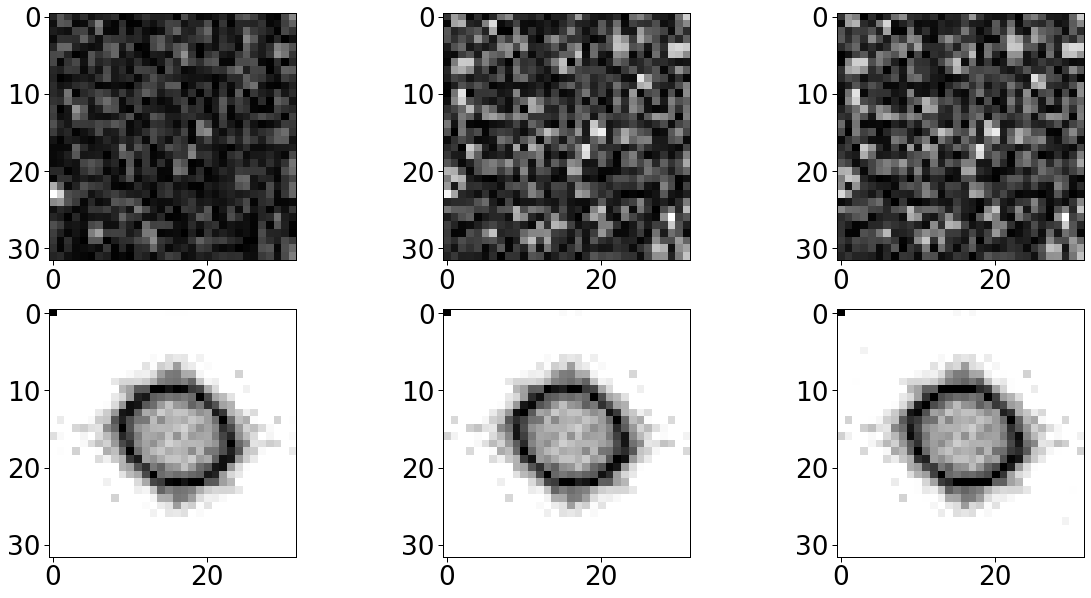

3 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 273/512 (53%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.219833225, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.051626891, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022451505, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013312233, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009143566, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005366936, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003674145, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002751316, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002178188, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001790973, Accuracy: 512/512 (100%)

(tensor(70.), tensor(1.2027e+13))

Train set: Avg. loss: 0.000899615, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580528, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329598, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225381, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169893, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071678, A

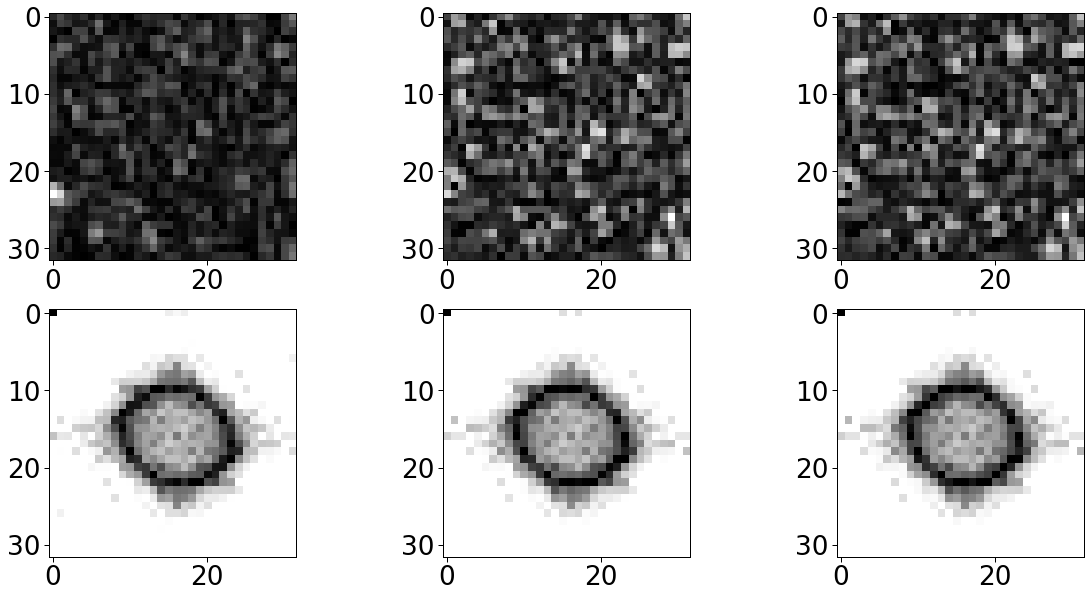

3 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 318/512 (62%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.234620035, Accuracy: 494/512 (96%)


Train set: Avg. loss: 0.052997321, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022714546, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013397462, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009178551, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005373343, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003675979, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002751454, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002177608, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001790076, Accuracy: 512/512 (100%)

(tensor(70.), tensor(5.7004e+12))

Train set: Avg. loss: 0.000898684, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580339, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329472, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225382, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169903, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071675, A

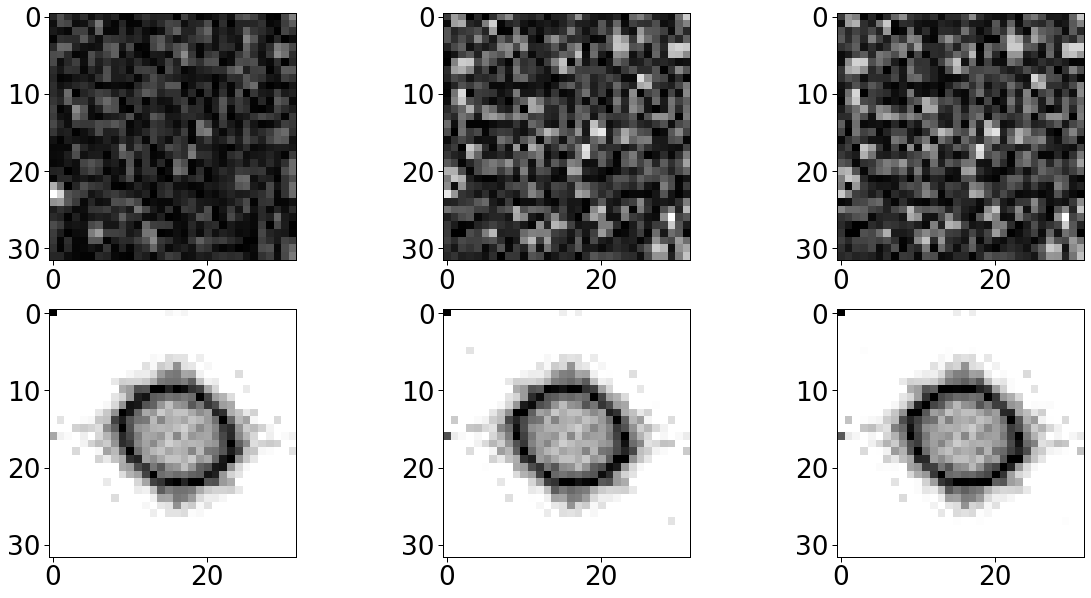

3 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 259/512 (51%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.213071465, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.051023468, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022338618, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013279274, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009132683, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005367756, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003676064, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002753425, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002180227, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001792868, Accuracy: 512/512 (100%)

(tensor(69.), tensor(1.6832e+13))

Train set: Avg. loss: 0.000900799, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000581087, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329919, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225556, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000170019, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071730, A

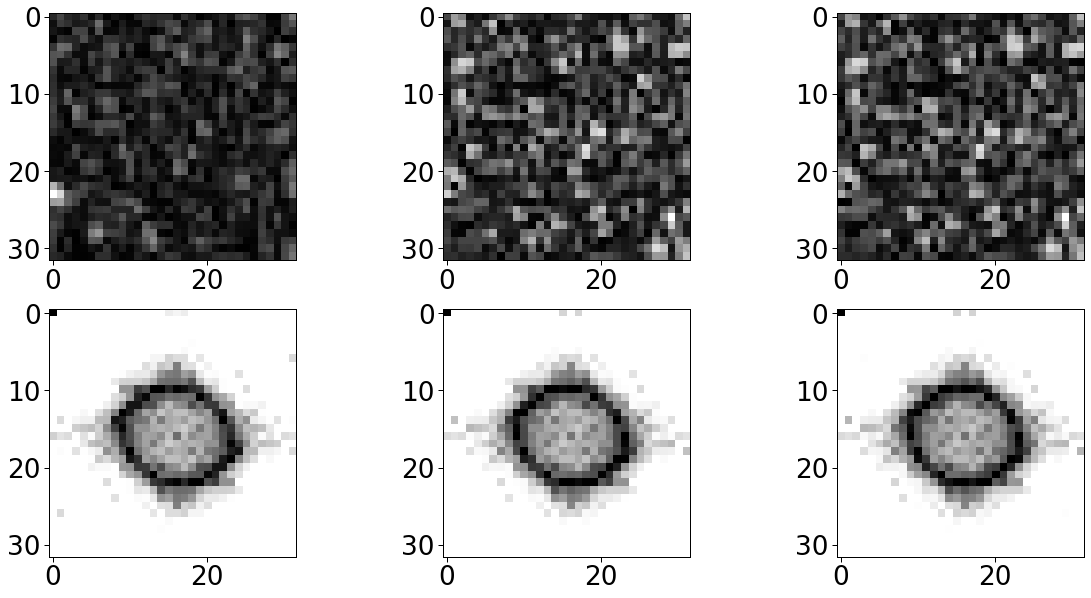

3 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 321/512 (63%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.213763237, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.051072549, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022347325, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013281652, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009133363, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005367583, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003675898, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002753265, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002180082, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001792743, Accuracy: 512/512 (100%)

(tensor(69.), tensor(1.5856e+13))

Train set: Avg. loss: 0.000900729, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000581076, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329914, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225559, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000170023, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071732, A

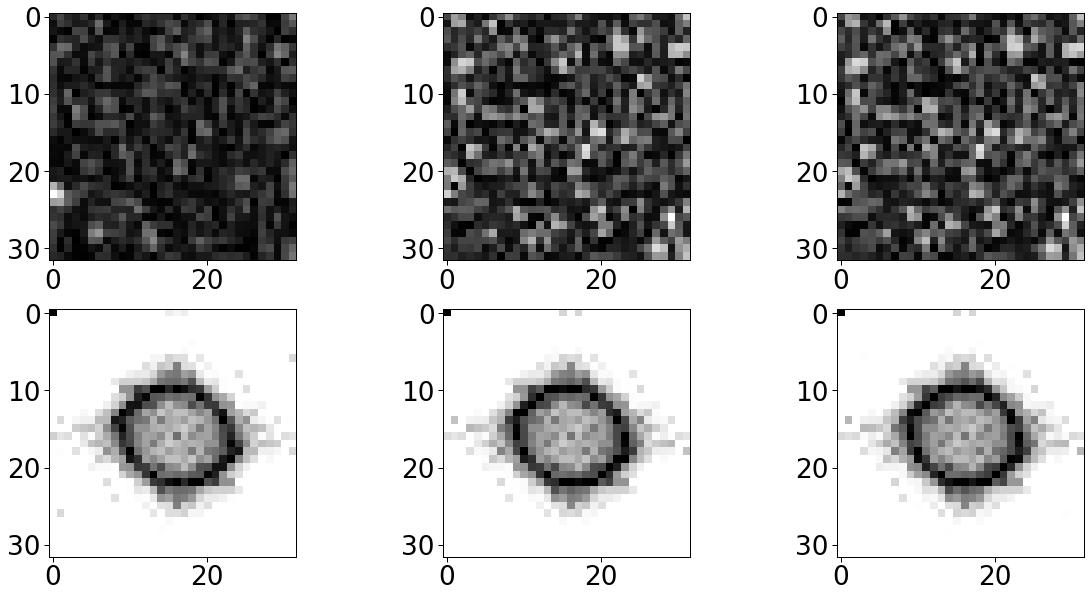

3 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 202/512 (39%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.218708813, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.051433202, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022400722, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013291419, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009132755, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005362705, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003672071, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002750122, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002177428, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001790451, Accuracy: 512/512 (100%)

(tensor(70.), tensor(1.1257e+13))

Train set: Avg. loss: 0.000899478, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580492, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329592, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225385, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169898, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071680, A

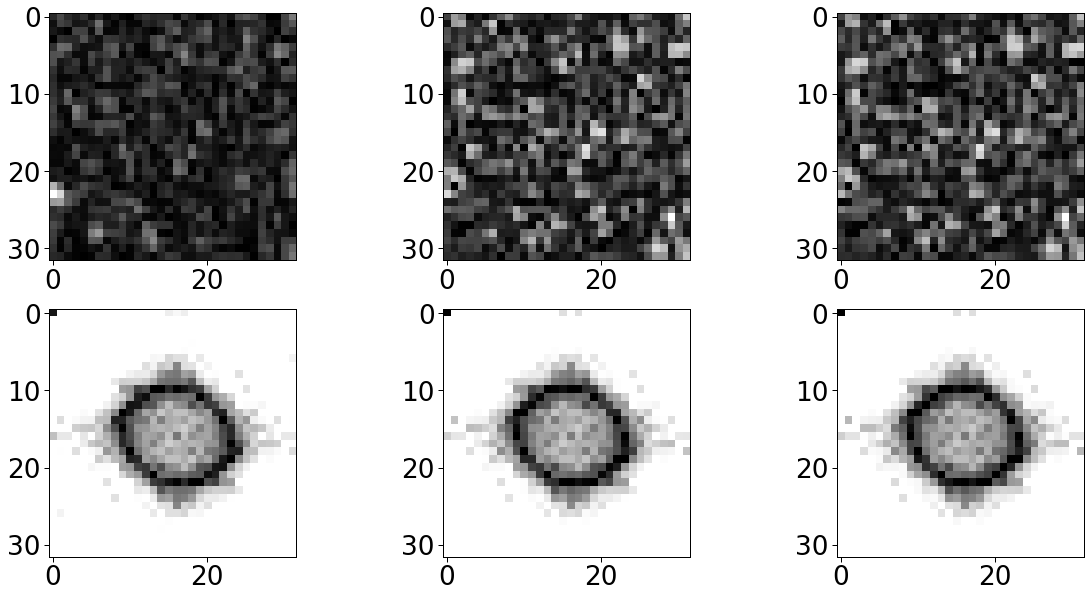

3 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 302/512 (59%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.212887645, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.050881408, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022293249, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013257473, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009119756, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005361420, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003672479, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002751046, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002178502, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001791540, Accuracy: 512/512 (100%)

(tensor(69.), tensor(1.5651e+13))

Train set: Avg. loss: 0.000900259, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580843, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329803, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225495, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169979, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071716, A

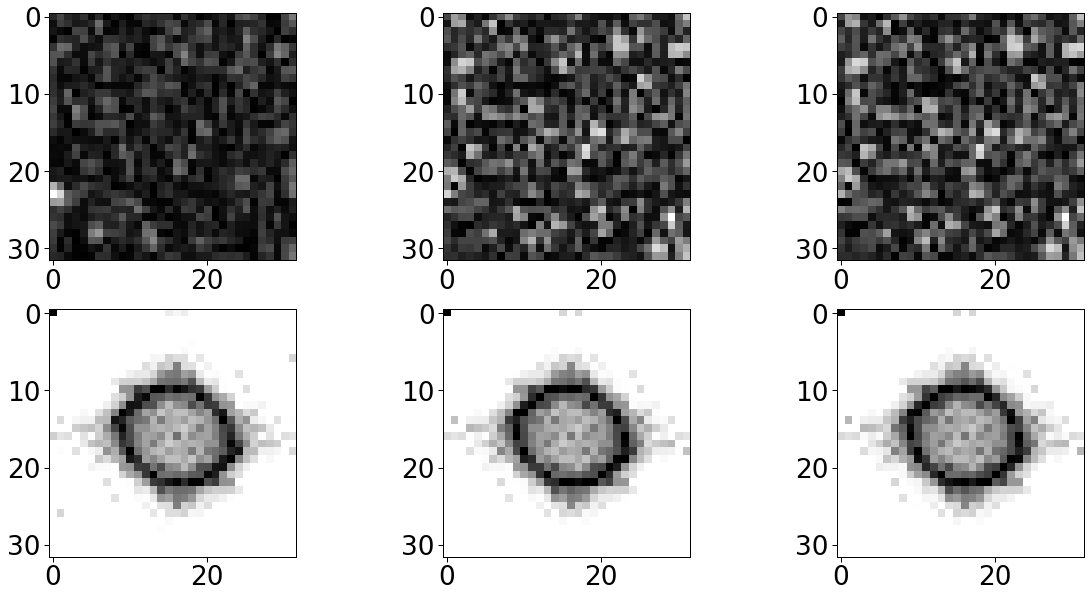

3 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 213/512 (42%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.210558504, Accuracy: 497/512 (97%)


Train set: Avg. loss: 0.050943367, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022347976, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013293160, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009144865, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005376563, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003681852, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002757695, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002183598, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001795638, Accuracy: 512/512 (100%)

(tensor(70.), tensor(2.2269e+13))

Train set: Avg. loss: 0.000902162, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000581778, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000330292, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225774, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000170178, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071796, A

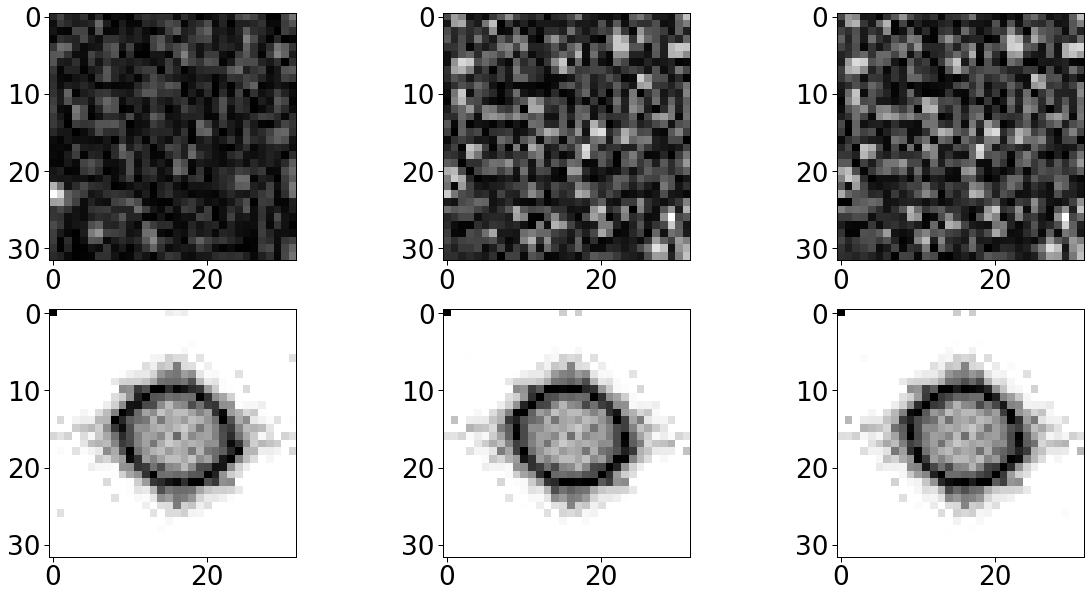

3 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 209/512 (41%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.215970665, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.051292878, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022389956, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013294471, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009137784, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005367502, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003675217, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002752458, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002179285, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001791988, Accuracy: 512/512 (100%)

(tensor(69.), tensor(1.5052e+13))

Train set: Avg. loss: 0.000900249, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580812, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329758, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225464, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169953, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071703, A

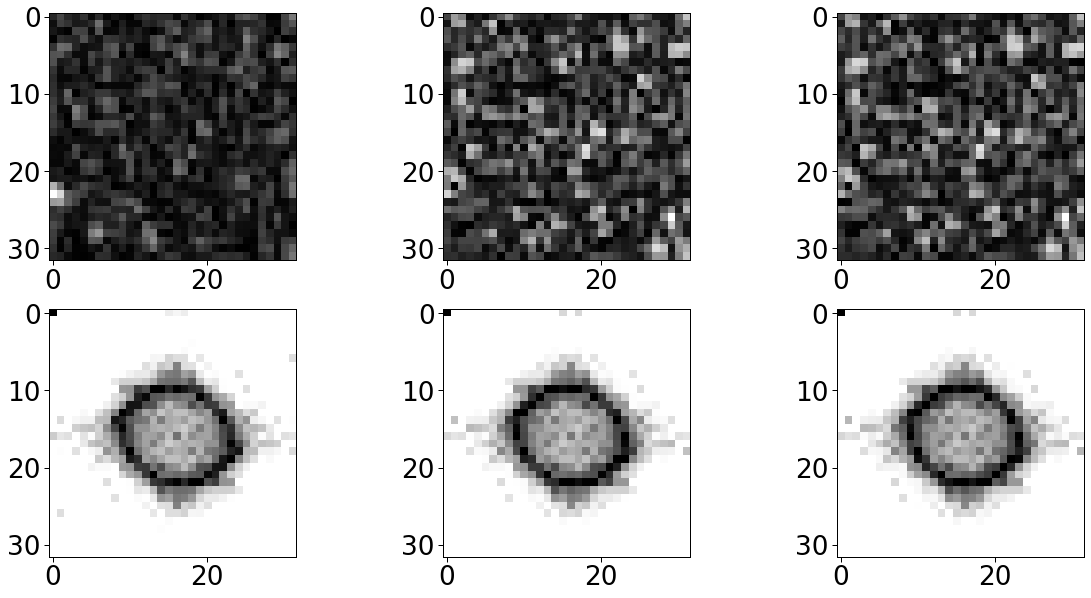

3 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 205/512 (40%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.218253613, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.051601090, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022465233, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013324360, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009152971, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005373087, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003678035, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002754120, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002180362, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001792735, Accuracy: 512/512 (100%)

(tensor(68.), tensor(1.3358e+13))

Train set: Avg. loss: 0.000900431, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580917, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329797, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225490, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169970, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071706, A

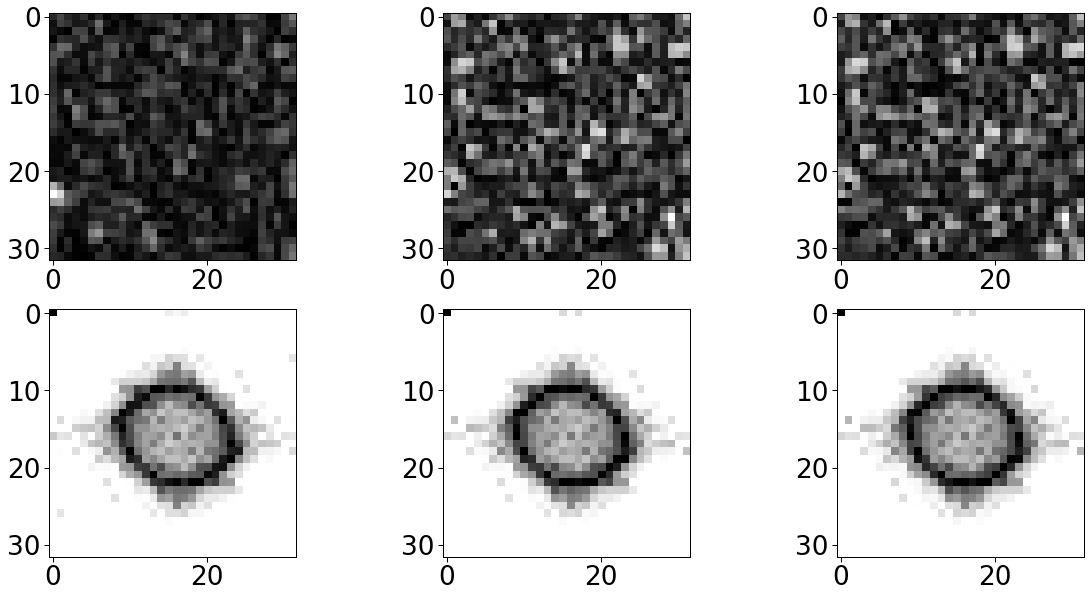

3 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 288/512 (56%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.222225159, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.051716786, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022448886, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013304265, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009136355, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005361651, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003670964, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002749075, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002176474, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001789587, Accuracy: 512/512 (100%)

(tensor(70.), tensor(8.8563e+12))

Train set: Avg. loss: 0.000898960, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580300, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329485, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225341, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169869, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071667, A

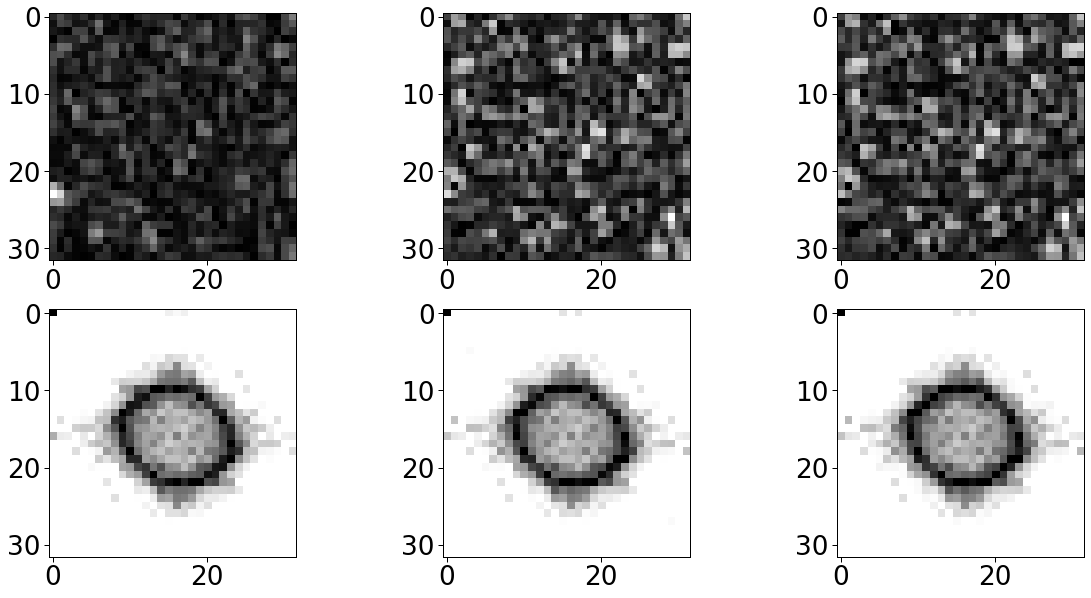

3 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 286/512 (56%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.230994478, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.052562609, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022615803, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013359299, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009159389, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005366393, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003672364, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002749261, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002176150, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001789047, Accuracy: 512/512 (100%)

(tensor(70.), tensor(6.9052e+12))

Train set: Avg. loss: 0.000898394, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580129, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329378, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225311, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169851, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071659, A

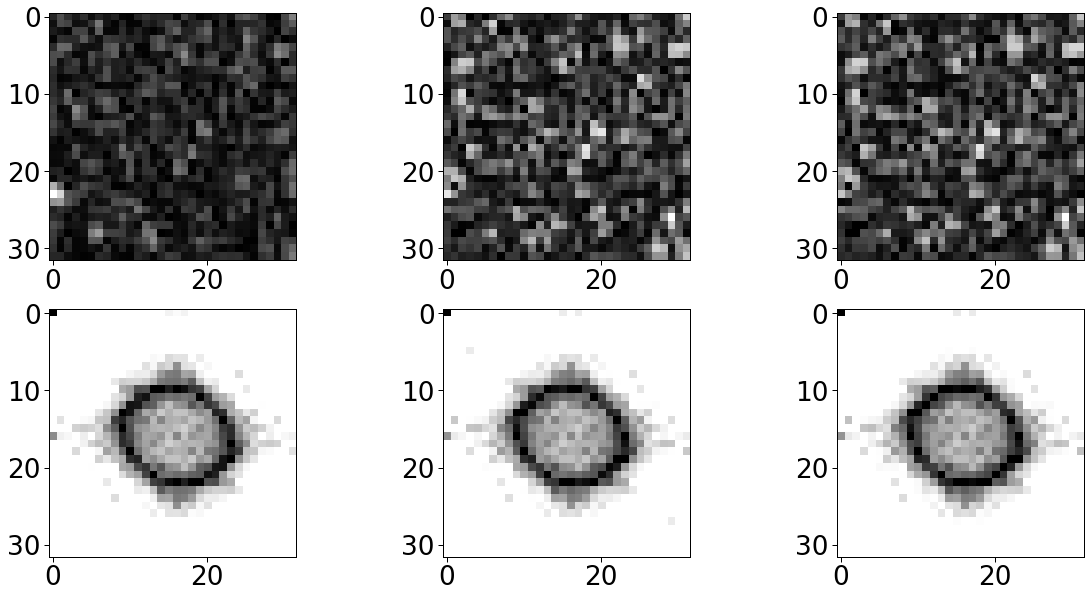

3 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 228/512 (45%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.229840100, Accuracy: 494/512 (96%)


Train set: Avg. loss: 0.052750379, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022695990, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013401050, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009185028, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005379429, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003679624, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002754016, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002179576, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001791668, Accuracy: 512/512 (100%)

(tensor(70.), tensor(8.4057e+12))

Train set: Avg. loss: 0.000899423, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580508, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329537, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225367, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169882, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071666, A

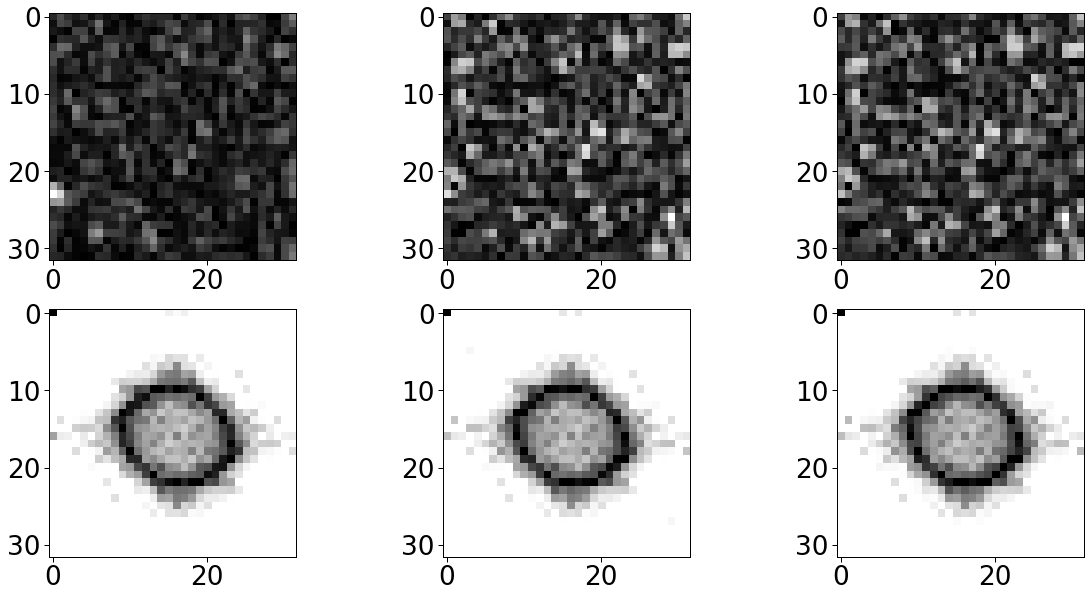

3 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 254/512 (50%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.222540706, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.051991735, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022539899, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013347485, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009161595, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005373738, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003677622, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002753394, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002179560, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001791935, Accuracy: 512/512 (100%)

(tensor(70.), tensor(1.1101e+13))

Train set: Avg. loss: 0.000899885, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580686, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329661, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225424, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169923, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071687, A

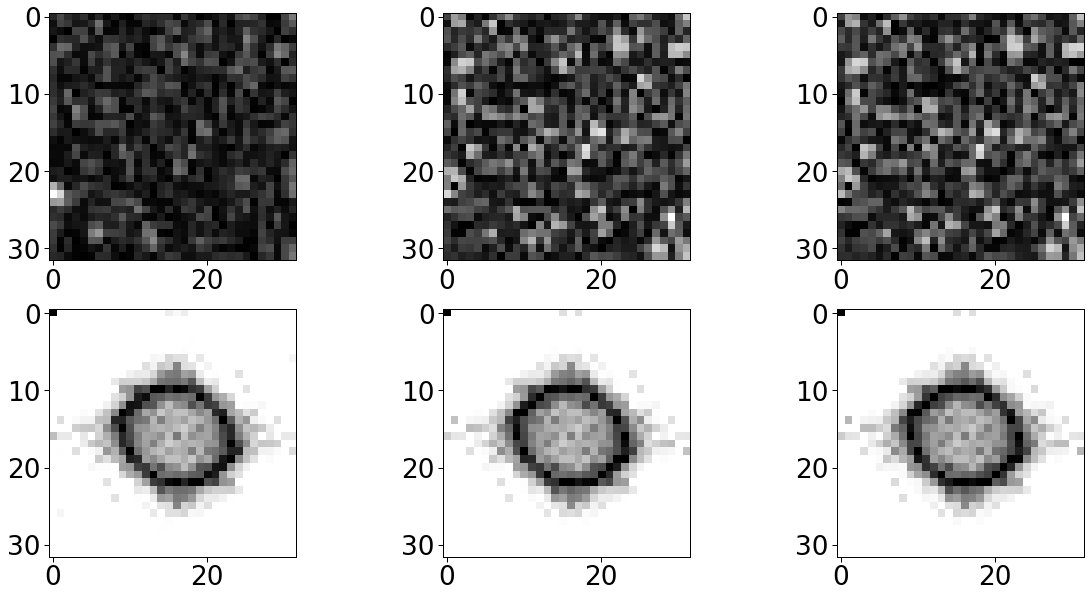

3 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 252/512 (49%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.213522851, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.050957374, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022309974, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013263729, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009122746, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005362339, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003672894, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002751263, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002178623, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001791607, Accuracy: 512/512 (100%)

(tensor(69.), tensor(1.4770e+13))

Train set: Avg. loss: 0.000900249, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580845, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329799, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225494, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169978, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071714, A

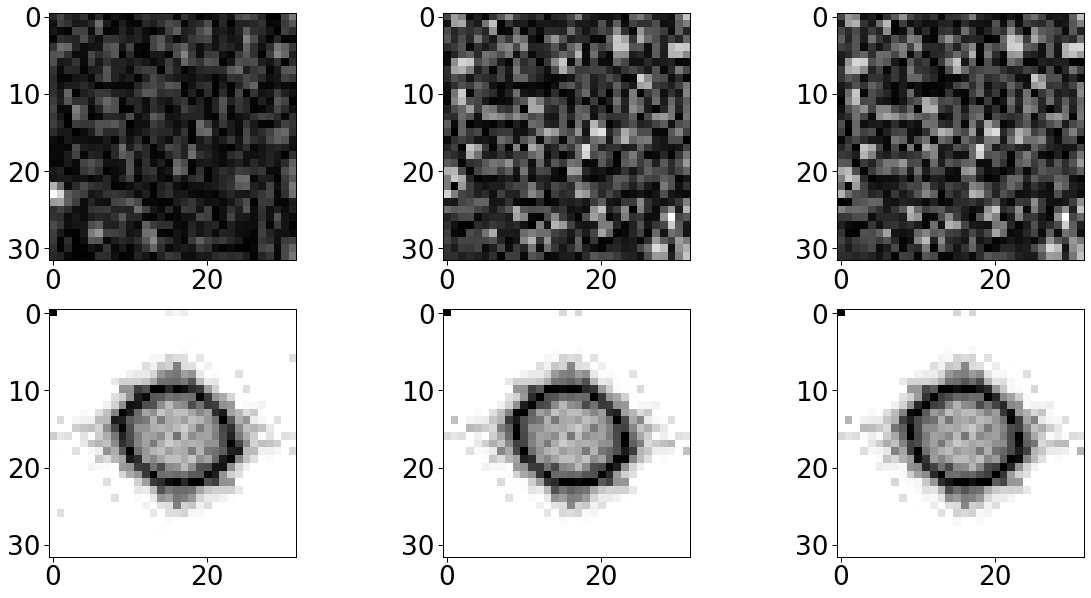

3 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 219/512 (43%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.233060122, Accuracy: 494/512 (96%)


Train set: Avg. loss: 0.052788686, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022663800, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013376283, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009167120, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005368583, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003673262, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002749668, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002176333, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001789114, Accuracy: 512/512 (100%)

(tensor(70.), tensor(6.5836e+12))

Train set: Avg. loss: 0.000898327, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580106, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329357, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225303, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169844, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071655, A

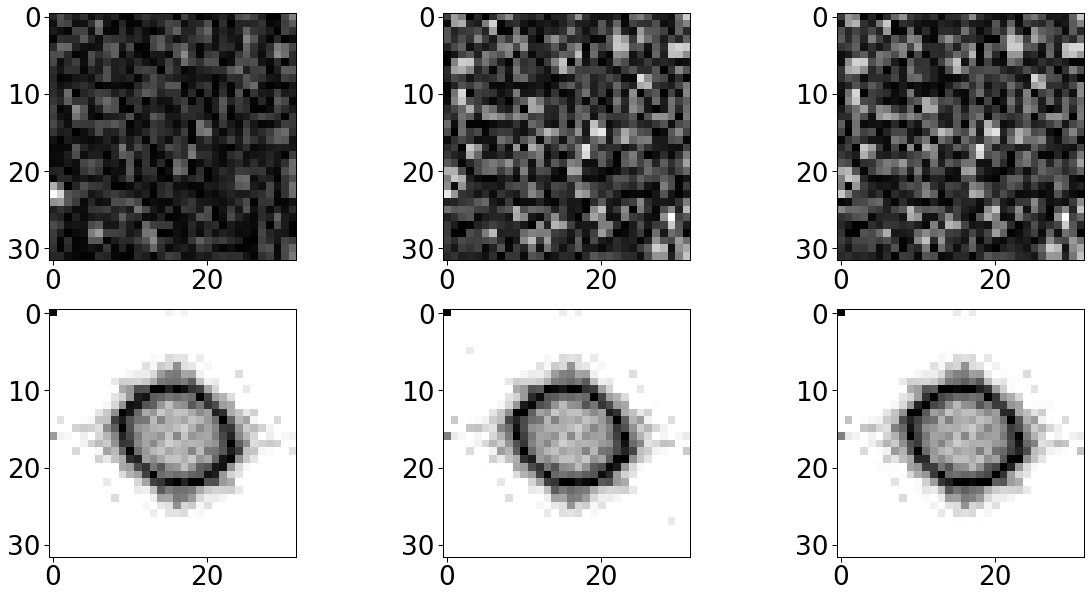

3 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 280/512 (55%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.210836962, Accuracy: 497/512 (97%)


Train set: Avg. loss: 0.050692227, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022257078, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013246960, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009116320, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005361689, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003673146, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002751768, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002179195, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001792180, Accuracy: 512/512 (100%)

(tensor(70.), tensor(1.6138e+13))

Train set: Avg. loss: 0.000900645, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000581037, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329911, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225558, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000170024, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071733, A

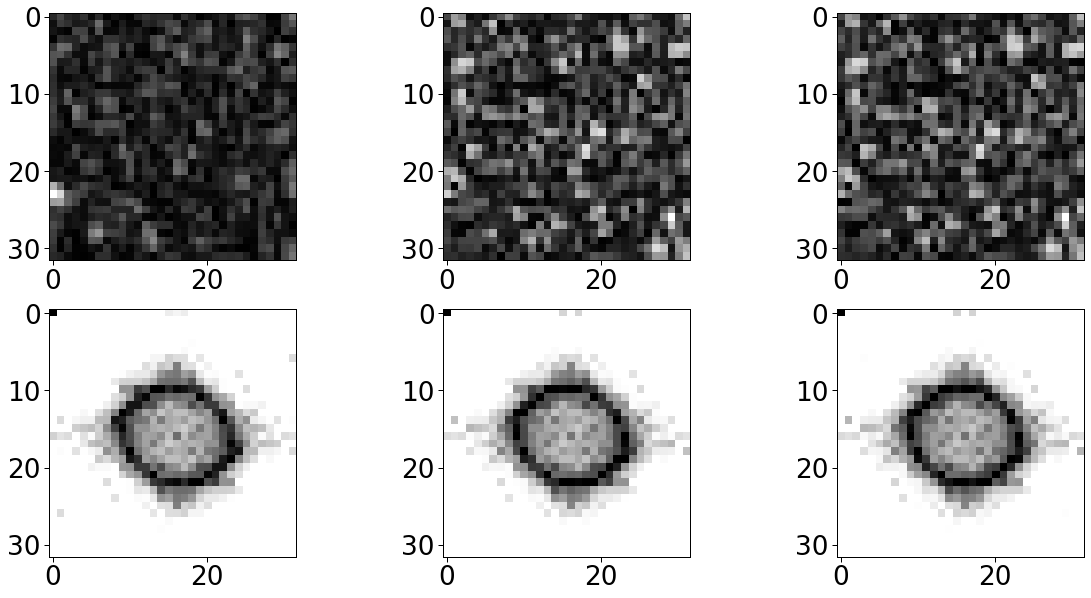

3 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 268/512 (52%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.214652166, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.050967138, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022298975, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013255036, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009116204, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005358133, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003670334, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002749447, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002177227, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001790479, Accuracy: 512/512 (100%)

(tensor(69.), tensor(1.2447e+13))

Train set: Avg. loss: 0.000899724, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580617, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329680, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225435, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169936, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071698, A

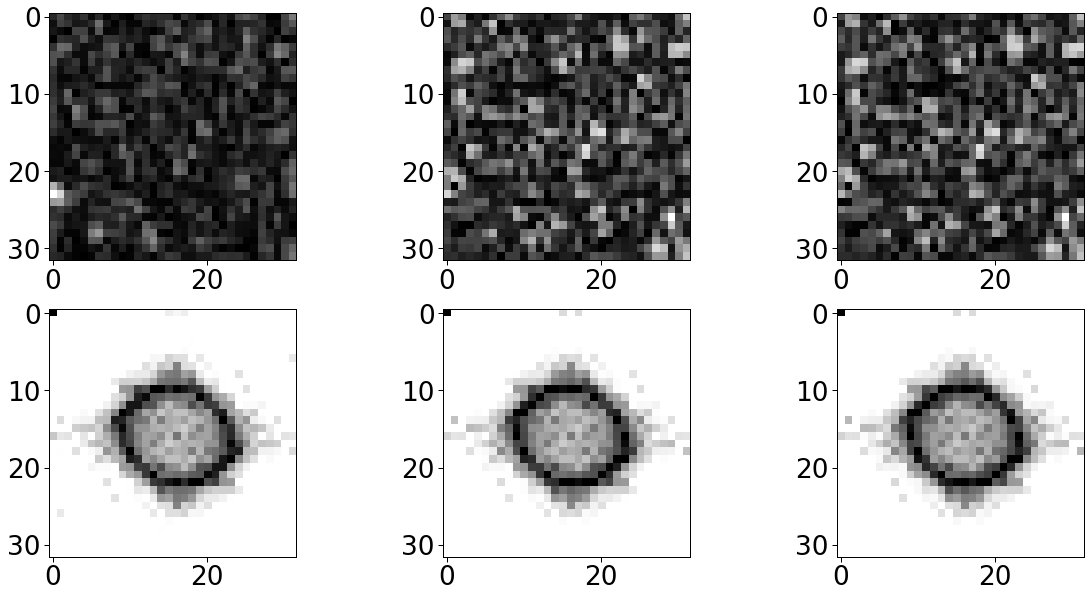

3 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 280/512 (55%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.210787833, Accuracy: 497/512 (97%)


Train set: Avg. loss: 0.050672885, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022249660, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013242867, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009113700, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005360318, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003672272, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002751147, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002178726, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001791812, Accuracy: 512/512 (100%)

(tensor(70.), tensor(1.7155e+13))

Train set: Avg. loss: 0.000900492, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580946, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329866, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225528, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000170002, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071727, A

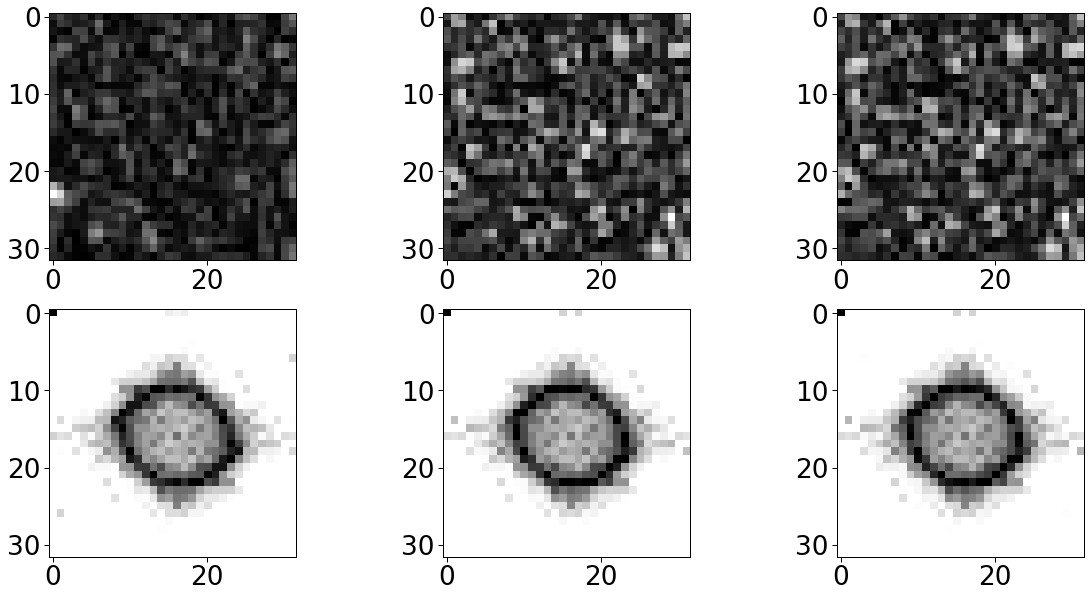

3 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 296/512 (58%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.213769063, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.051063344, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022342976, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013279173, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009131743, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005366683, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003675336, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002752864, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002179777, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001792497, Accuracy: 512/512 (100%)

(tensor(69.), tensor(1.6364e+13))

Train set: Avg. loss: 0.000900619, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000581014, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329882, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225540, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000170009, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071727, A

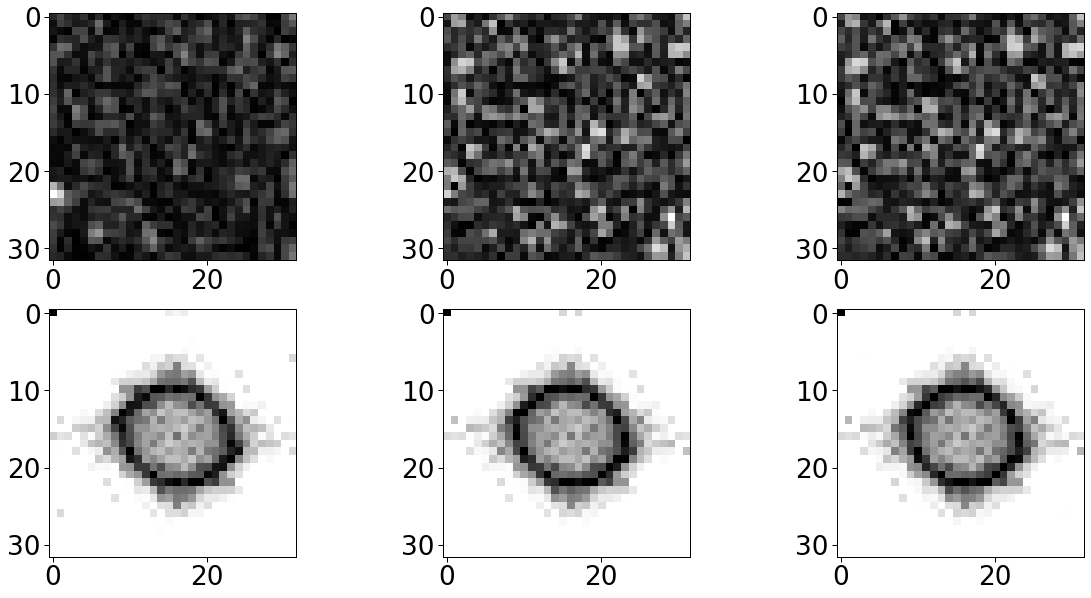

3 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 229/512 (45%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.216421857, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.051249176, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022369767, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013283410, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009130704, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005363622, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003672982, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002750945, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002178166, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001791112, Accuracy: 512/512 (100%)

(tensor(68.), tensor(1.3031e+13))

Train set: Avg. loss: 0.000899863, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580651, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329679, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225426, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169927, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071692, A

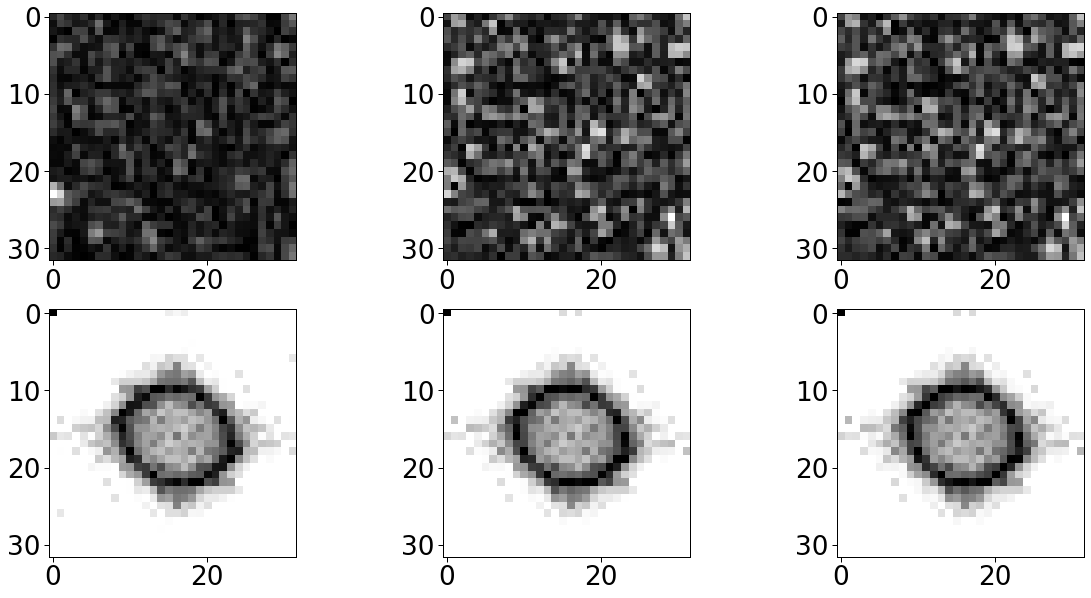

3 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 301/512 (59%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.222832054, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.051818322, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022475420, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013315346, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009142247, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005364084, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003672221, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002749839, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002176983, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001789956, Accuracy: 512/512 (100%)

(tensor(70.), tensor(9.0852e+12))

Train set: Avg. loss: 0.000899081, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580352, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329507, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225351, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169875, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071669, A

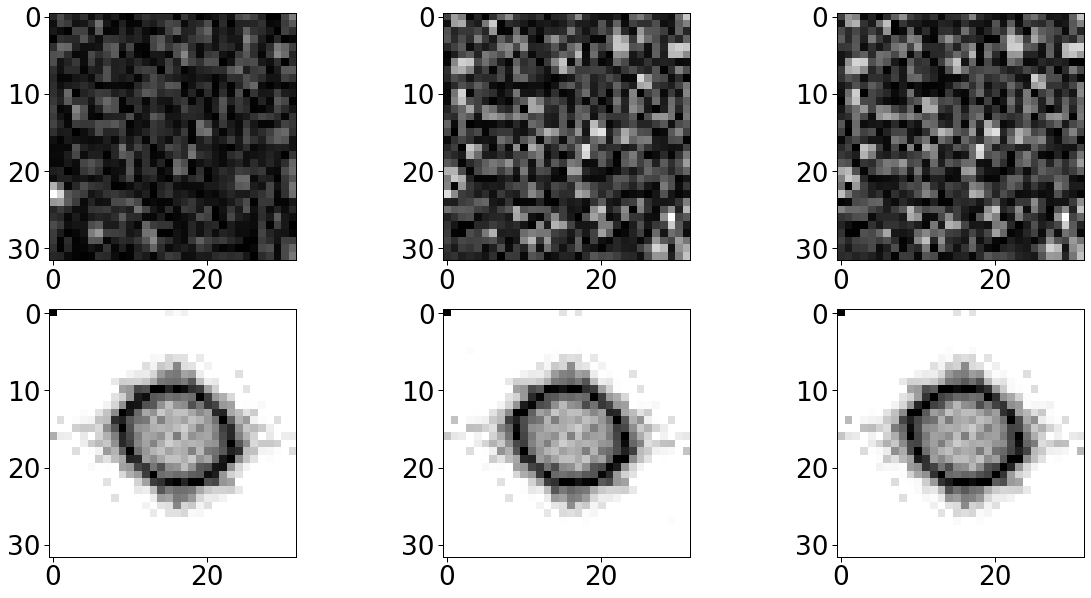

3 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 199/512 (39%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.214828312, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.051096659, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022338837, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013273098, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009126434, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005362870, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003672822, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002751002, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002178311, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001791292, Accuracy: 512/512 (100%)

(tensor(68.), tensor(1.4592e+13))

Train set: Avg. loss: 0.000900029, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580716, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329721, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225446, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169942, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071700, A

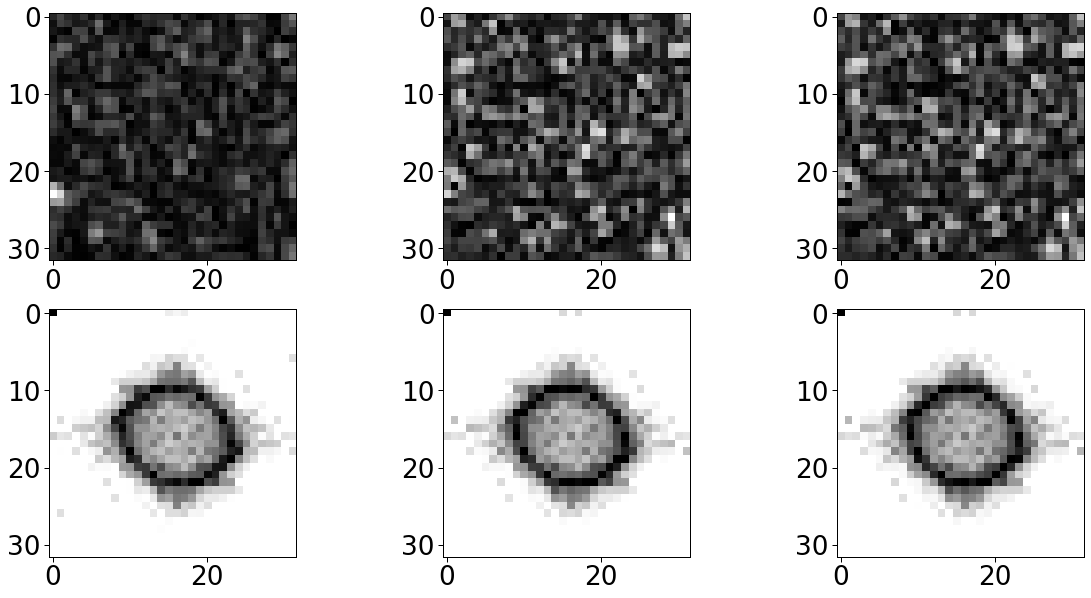

3 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 298/512 (58%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.218060374, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.051316321, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022370081, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013278245, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009125520, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005359578, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003670357, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002749015, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002176646, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001789864, Accuracy: 512/512 (100%)

(tensor(70.), tensor(1.1633e+13))

Train set: Avg. loss: 0.000899263, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580380, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329539, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225353, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169876, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071673, A

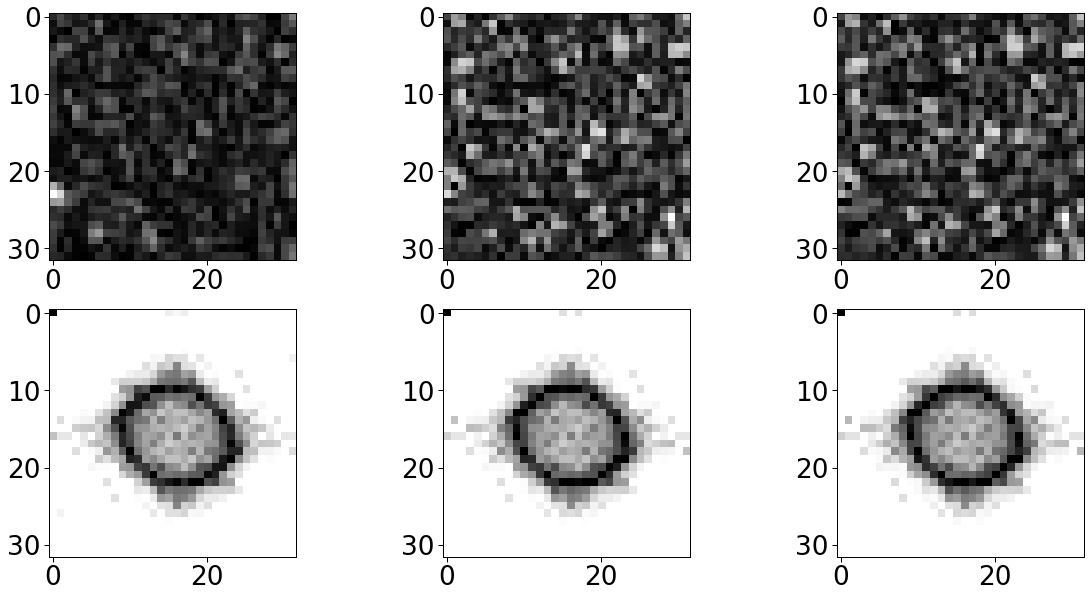

3 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 238/512 (46%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.212766871, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.050974399, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022325758, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013273851, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009129771, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005366539, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003675430, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002753033, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002179963, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001792680, Accuracy: 512/512 (100%)

(tensor(69.), tensor(1.7062e+13))

Train set: Avg. loss: 0.000900737, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000581064, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329910, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225553, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000170018, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071730, A

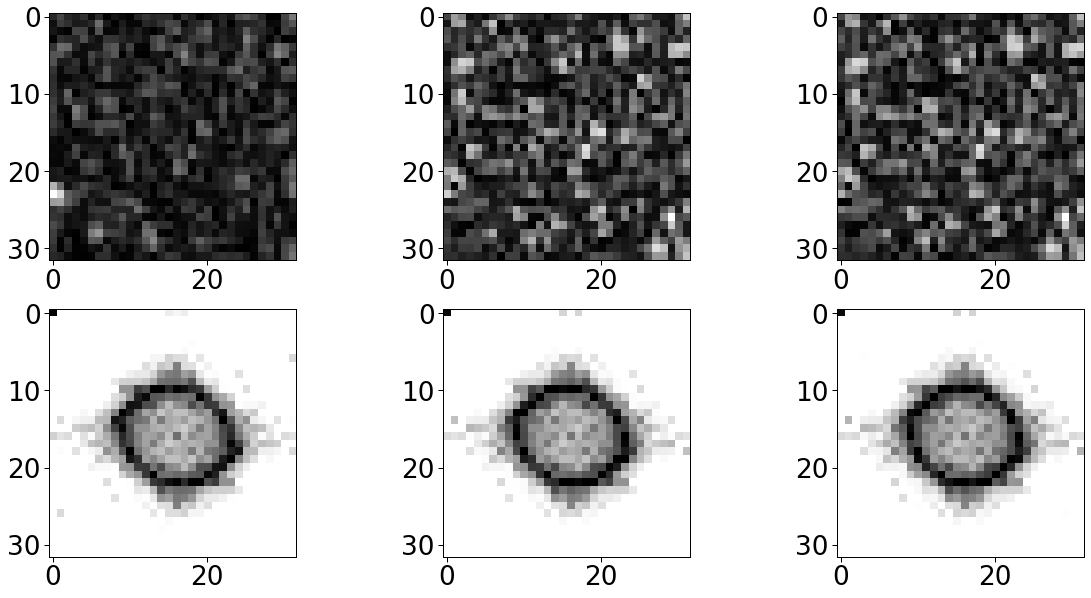

3 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 262/512 (51%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.212840647, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.050967641, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022323243, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013272521, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009128927, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005366086, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003675173, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002752861, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002179840, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001792587, Accuracy: 512/512 (100%)

(tensor(69.), tensor(1.7027e+13))

Train set: Avg. loss: 0.000900701, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000581052, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329906, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225553, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000170019, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071731, A

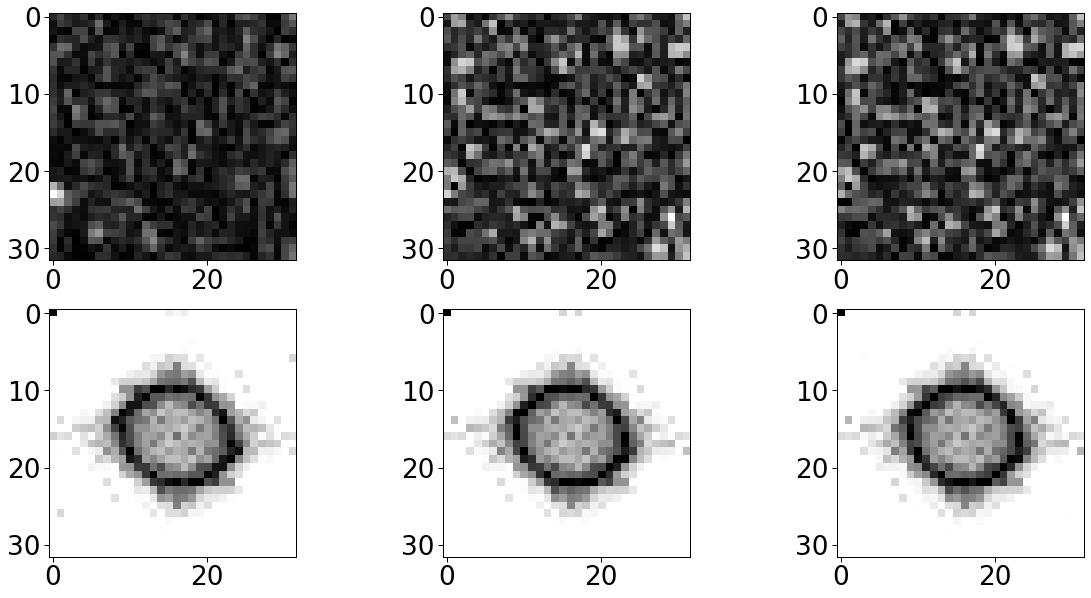

3 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 208/512 (41%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.212391973, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.050937232, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022318956, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013271744, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009128979, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005366468, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003675439, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002753071, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002180011, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001792729, Accuracy: 512/512 (100%)

(tensor(69.), tensor(1.7387e+13))

Train set: Avg. loss: 0.000900774, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000581076, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329917, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225555, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000170019, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071731, A

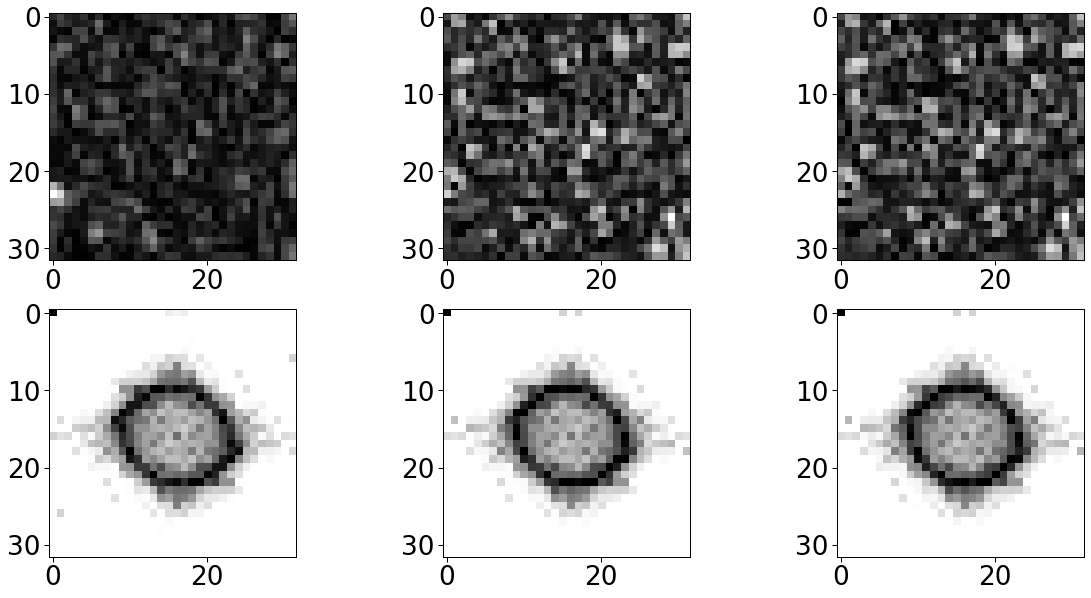

3 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 186/512 (36%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.210259348, Accuracy: 497/512 (97%)


Train set: Avg. loss: 0.050616372, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022238590, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013239707, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009112706, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005360441, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003672536, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002751428, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002178990, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001792052, Accuracy: 512/512 (100%)

(tensor(70.), tensor(1.7034e+13))

Train set: Avg. loss: 0.000900633, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000581029, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329912, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225558, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000170024, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071734, A

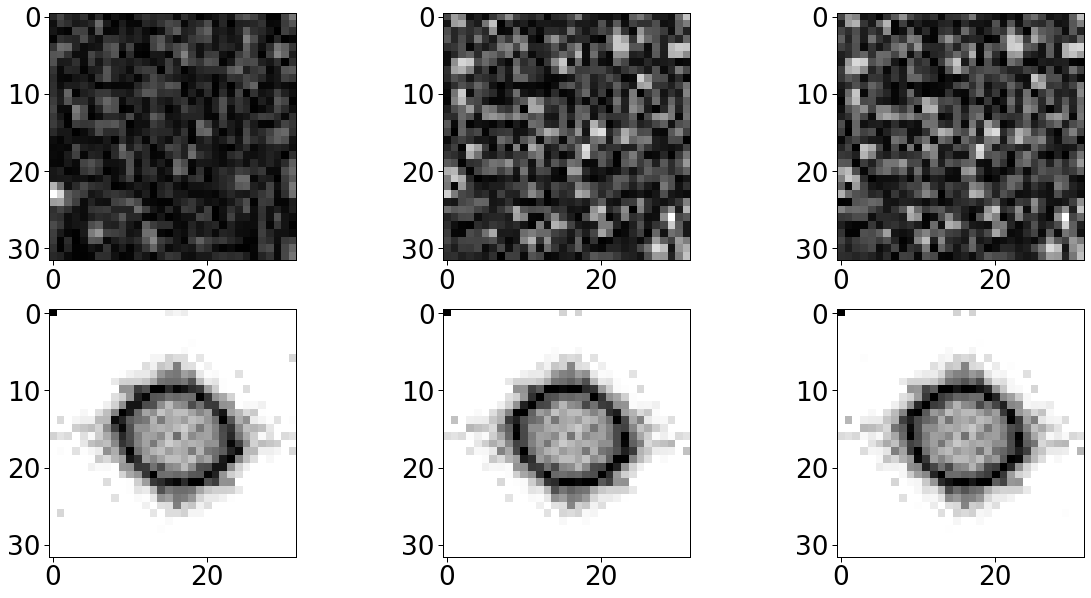

3 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 264/512 (52%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.210998997, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.050678439, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022249054, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013241766, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009112646, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005359482, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003671706, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002750725, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002178384, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001791525, Accuracy: 512/512 (100%)

(tensor(69.), tensor(1.6274e+13))

Train set: Avg. loss: 0.000900337, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580866, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329820, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225501, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169982, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071717, A

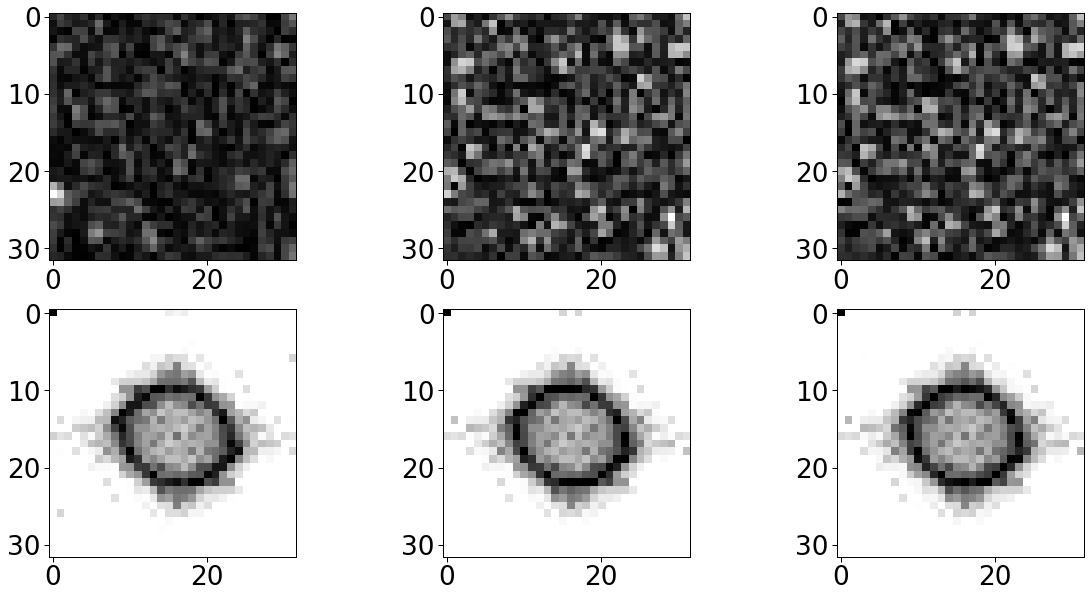

3 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 302/512 (59%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.207592413, Accuracy: 497/512 (97%)


Train set: Avg. loss: 0.050336603, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022179883, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013219995, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009104559, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005358987, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003672353, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002751671, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002179383, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001792495, Accuracy: 512/512 (100%)

(tensor(70.), tensor(1.9443e+13))

Train set: Avg. loss: 0.000900996, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000581215, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000330029, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225626, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000170074, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071757, A

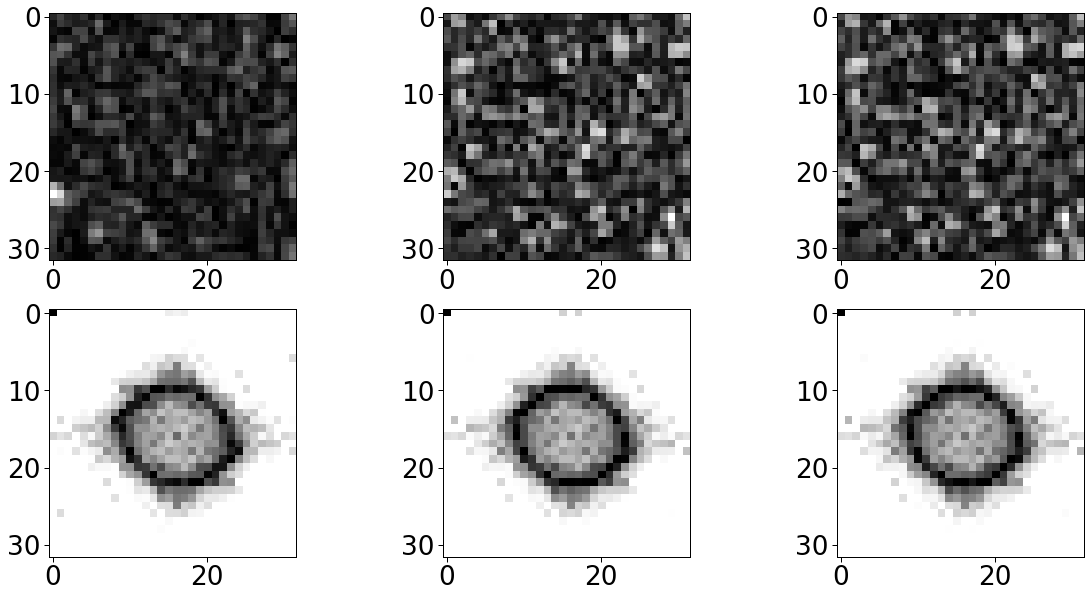

3 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 241/512 (47%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.211049065, Accuracy: 497/512 (97%)


Train set: Avg. loss: 0.050843682, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022306763, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013270988, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009130662, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005368778, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003677227, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002754506, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002181203, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001793745, Accuracy: 512/512 (100%)

(tensor(70.), tensor(1.7931e+13))

Train set: Avg. loss: 0.000901303, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000581362, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000330075, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225651, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000170090, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071758, A

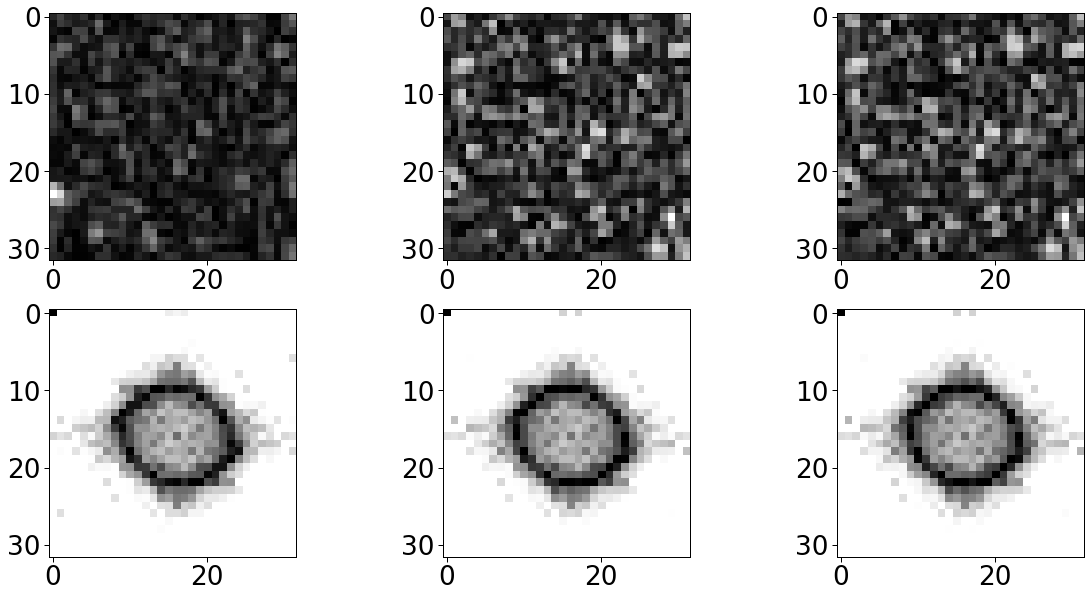

3 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 215/512 (42%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.213621721, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.050924484, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022295957, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013255970, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009117692, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005359568, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003671173, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002750044, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002177694, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001790865, Accuracy: 512/512 (100%)

(tensor(69.), tensor(1.4997e+13))

Train set: Avg. loss: 0.000899912, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580661, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329701, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225435, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169934, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071697, A

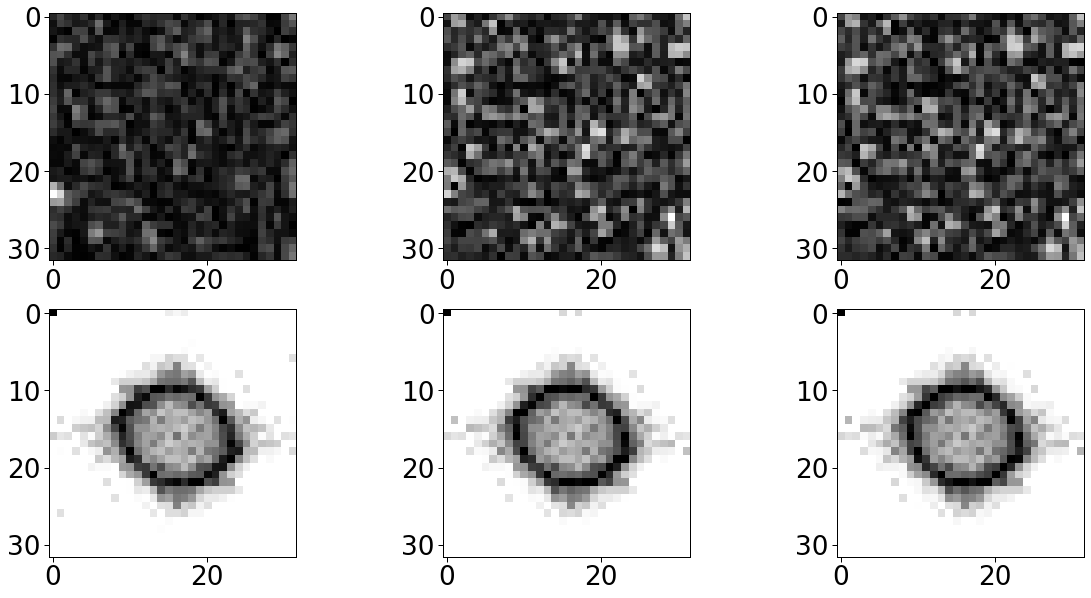

3 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 239/512 (47%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.208682328, Accuracy: 497/512 (97%)


Train set: Avg. loss: 0.050543547, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022234710, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013242951, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009116781, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005364002, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003674919, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002753217, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002180415, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001793237, Accuracy: 512/512 (100%)

(tensor(70.), tensor(2.0246e+13))

Train set: Avg. loss: 0.000901228, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000581308, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000330064, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225640, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000170084, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071759, A

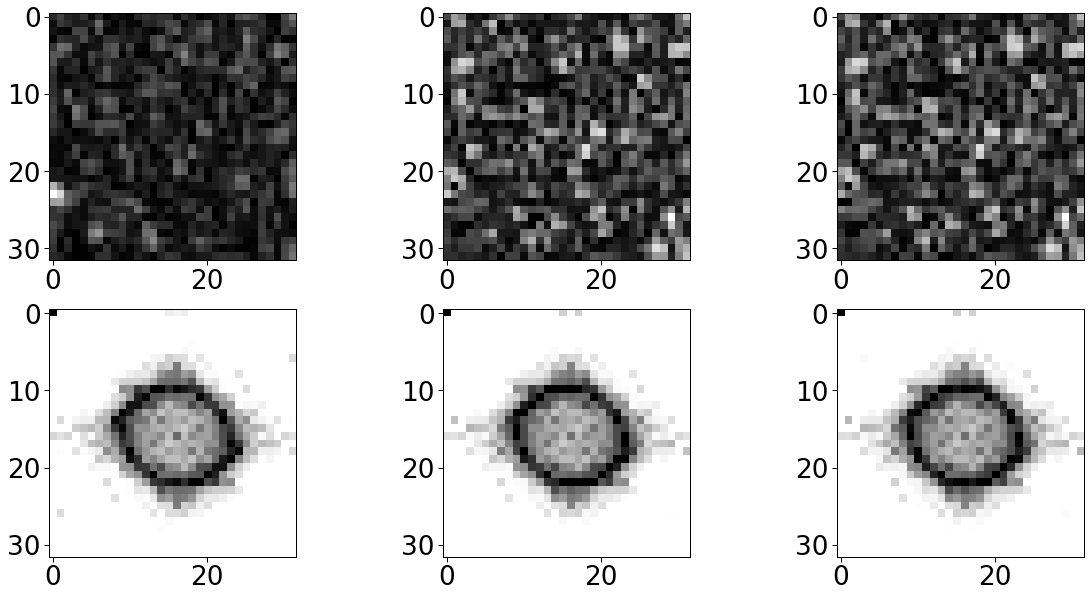

3 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 285/512 (56%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.206417114, Accuracy: 497/512 (97%)


Train set: Avg. loss: 0.050262649, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022170741, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013219574, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009105993, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005360900, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003673735, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002752757, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002180277, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001793249, Accuracy: 512/512 (100%)

(tensor(70.), tensor(2.1535e+13))

Train set: Avg. loss: 0.000901391, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000581408, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000330135, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225686, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000170118, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071775, A

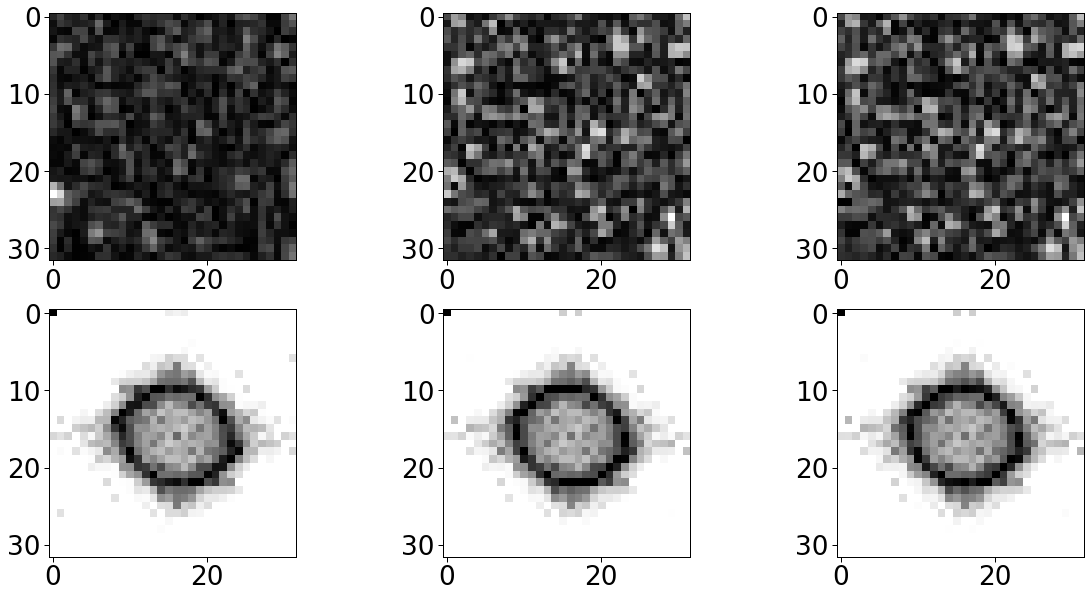

3 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 232/512 (45%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.215206593, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.051044997, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022316311, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013261273, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009119047, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005358962, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003670622, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002749546, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002177241, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001790457, Accuracy: 512/512 (100%)

(tensor(69.), tensor(1.2971e+13))

Train set: Avg. loss: 0.000899675, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000580580, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329657, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225419, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000169924, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071693, A

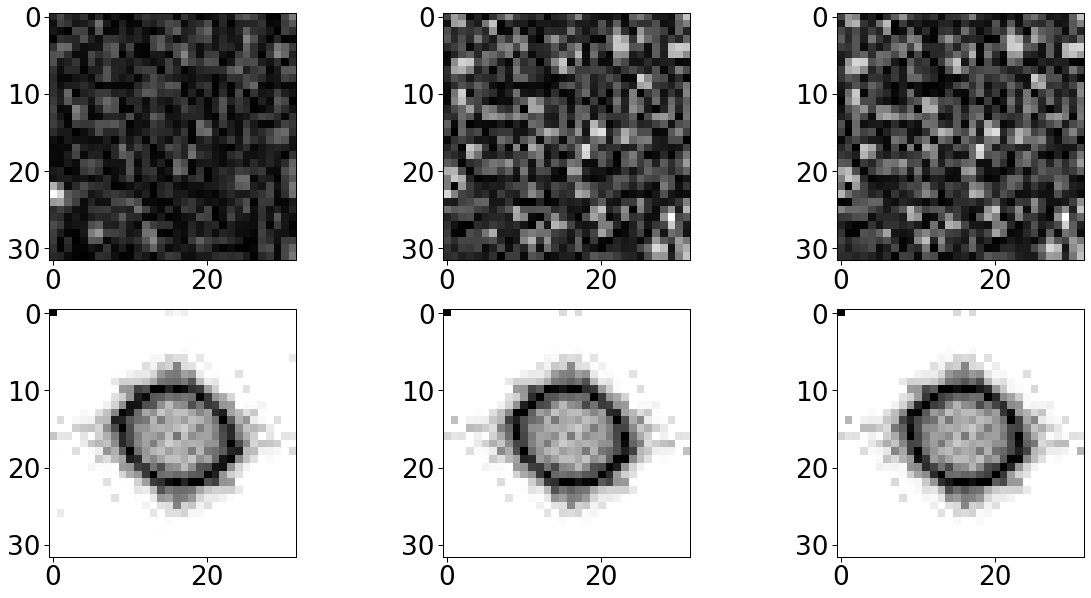

3 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 215/512 (42%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.209892124, Accuracy: 497/512 (97%)


Train set: Avg. loss: 0.050598025, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022236418, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013239658, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.009113109, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005360971, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003672897, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002751709, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002179215, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001792241, Accuracy: 512/512 (100%)

(tensor(70.), tensor(1.7931e+13))

Train set: Avg. loss: 0.000900735, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000581071, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000329937, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225569, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000170032, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000071738, A

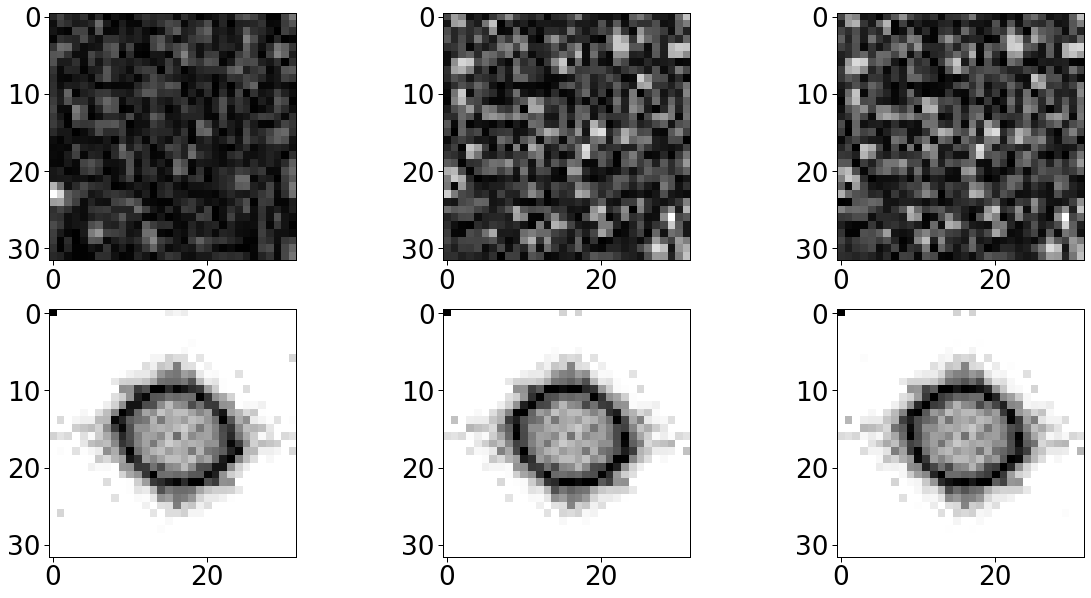

(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 4)
(3, 8)
(3, 8)
(3, 8)
(3, 8)
(3, 8)
(3, 8)
(3, 8)
(3, 8)
(3, 8)
(3, 8)
(3, 8)
(3, 8)
(3, 8)
(3, 8)
(3, 8)
(3, 8)
(3, 8)
(3, 8)
(3, 8)
(3, 8)
(3, 8)
(3, 8)
(3, 8)

  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.283241659, Accuracy: 477/512 (93%)


Train set: Avg. loss: 0.078908011, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033335924, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.019029126, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012697485, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.007166806, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004792010, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003529902, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002760435, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002247957, Accuracy: 512/512 (100%)

(tensor(65.), tensor(1.0715e+11))

Train set: Avg. loss: 0.001098170, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000700594, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000391893, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000266089, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000199456, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000083068, A

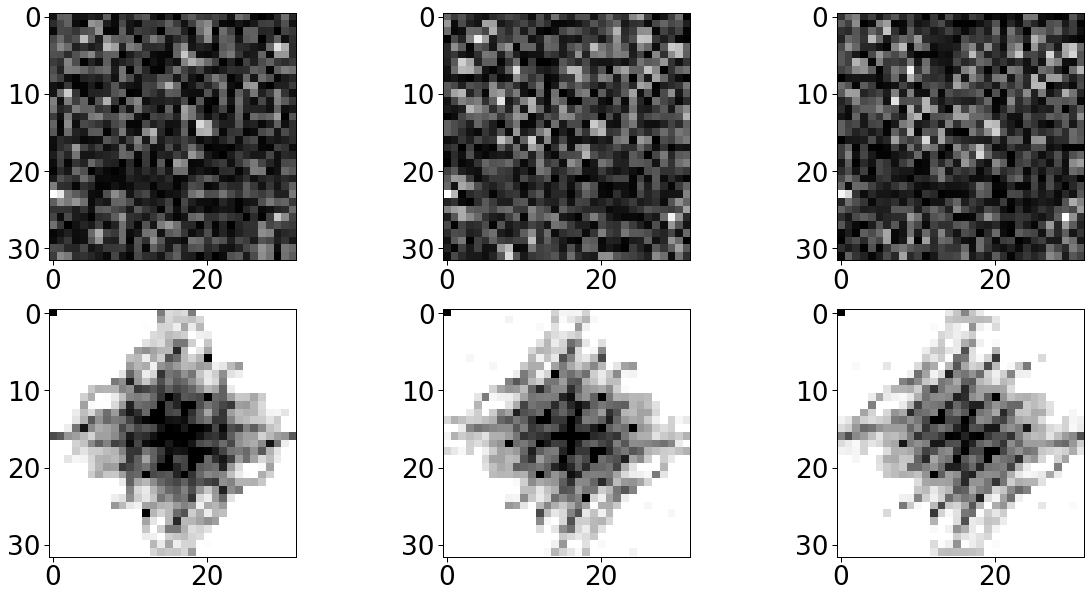

8 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 217/512 (42%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.289622903, Accuracy: 476/512 (93%)


Train set: Avg. loss: 0.080870673, Accuracy: 511/512 (100%)


Train set: Avg. loss: 0.034070179, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.019440869, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012968425, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.007315921, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004889004, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003599832, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002814197, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002291134, Accuracy: 512/512 (100%)

(tensor(64.), tensor(1.0339e+11))

Train set: Avg. loss: 0.001118827, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000713386, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000398961, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000270822, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000202982, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000084596, A

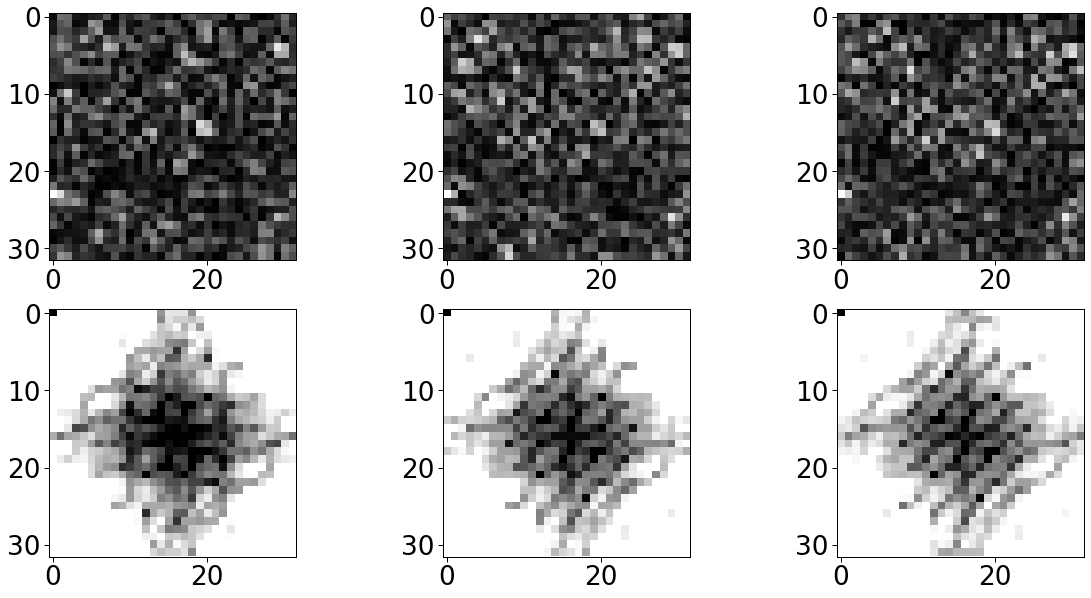

8 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 253/512 (49%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.279101580, Accuracy: 476/512 (93%)


Train set: Avg. loss: 0.076690309, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.032359295, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.018484516, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012345914, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.006979865, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004675301, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003448505, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002699538, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002200158, Accuracy: 512/512 (100%)

(tensor(63.), tensor(5.6228e+10))

Train set: Avg. loss: 0.001077076, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000688339, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000385561, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000262054, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000196545, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000081910, A

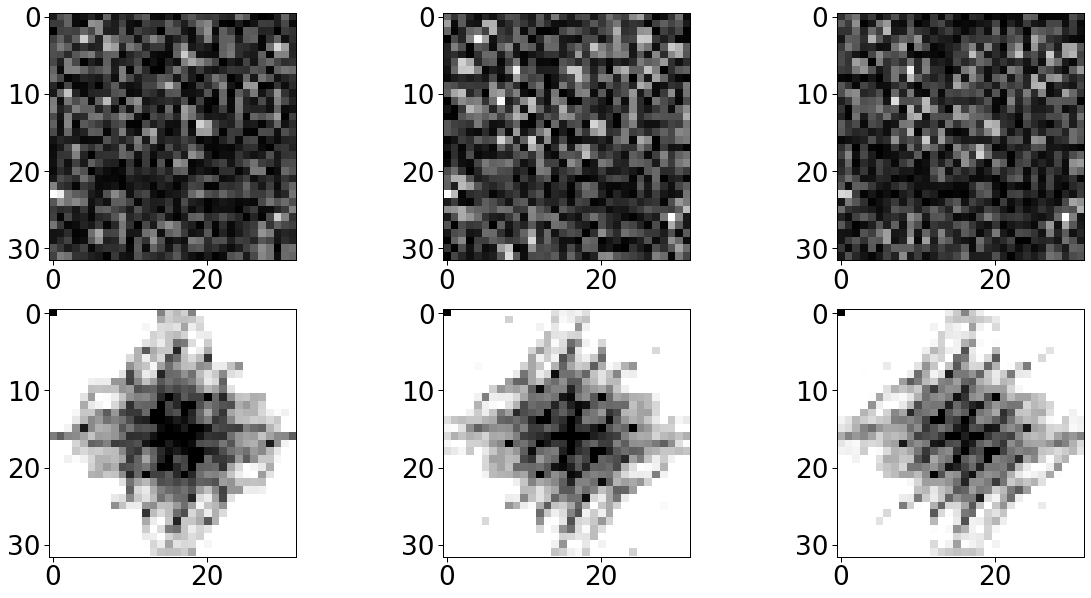

8 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 242/512 (47%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.272570282, Accuracy: 482/512 (94%)


Train set: Avg. loss: 0.068549573, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.029080544, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.016800934, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.011312788, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.006456889, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004352740, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003223364, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002530248, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002066417, Accuracy: 512/512 (100%)

(tensor(66.), tensor(5.7260e+13))

Train set: Avg. loss: 0.001017269, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000652923, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000366934, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000250030, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000187793, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000078505, A

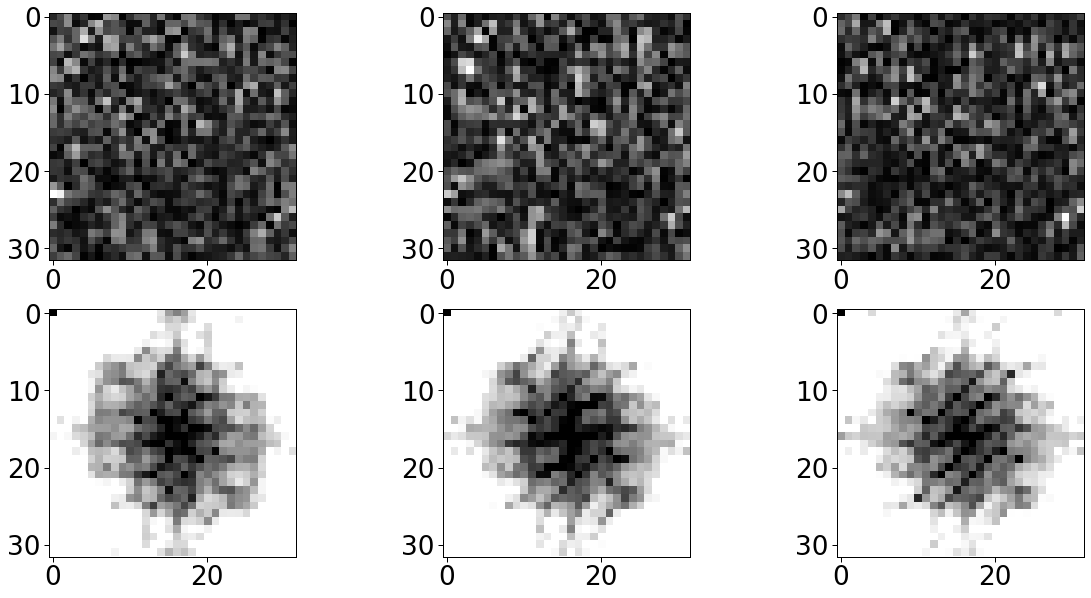

8 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 248/512 (48%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.277600735, Accuracy: 474/512 (93%)


Train set: Avg. loss: 0.075408809, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.031784225, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.018178225, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012156588, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.006884367, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004617197, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003408736, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002670244, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002177463, Accuracy: 512/512 (100%)

(tensor(63.), tensor(3.2298e+10))

Train set: Avg. loss: 0.001067463, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000682976, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000382925, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000260443, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000195421, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000081498, A

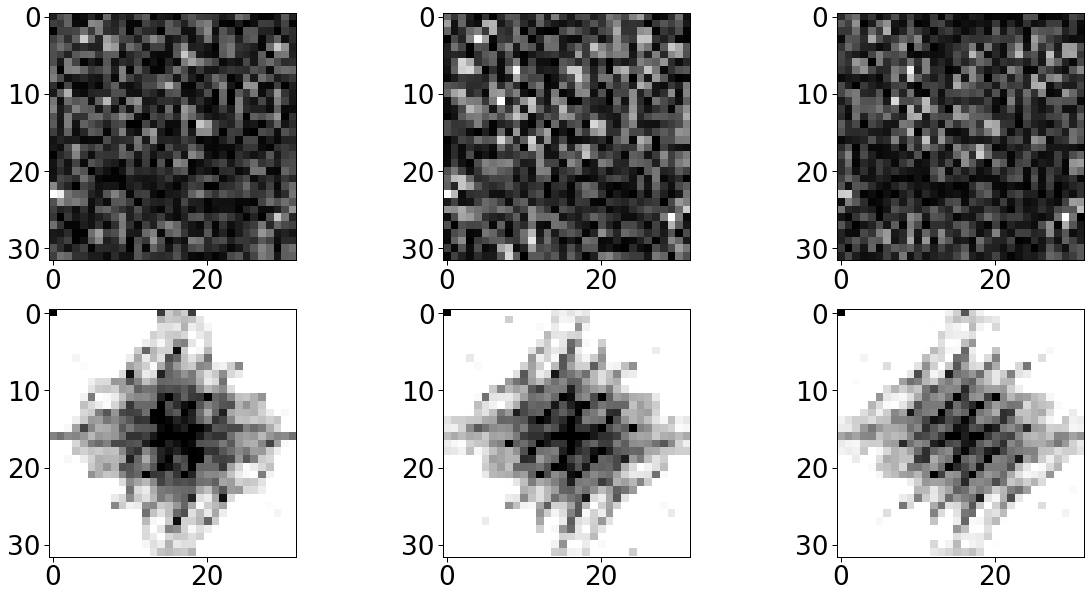

8 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 261/512 (51%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.280925125, Accuracy: 477/512 (93%)


Train set: Avg. loss: 0.078105666, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.033016503, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.018854147, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012585171, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.007108304, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004755553, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003504628, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002741656, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002233316, Accuracy: 512/512 (100%)

(tensor(64.), tensor(7.2132e+10))

Train set: Avg. loss: 0.001091931, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000696942, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000390038, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000264901, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000198601, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000082728, A

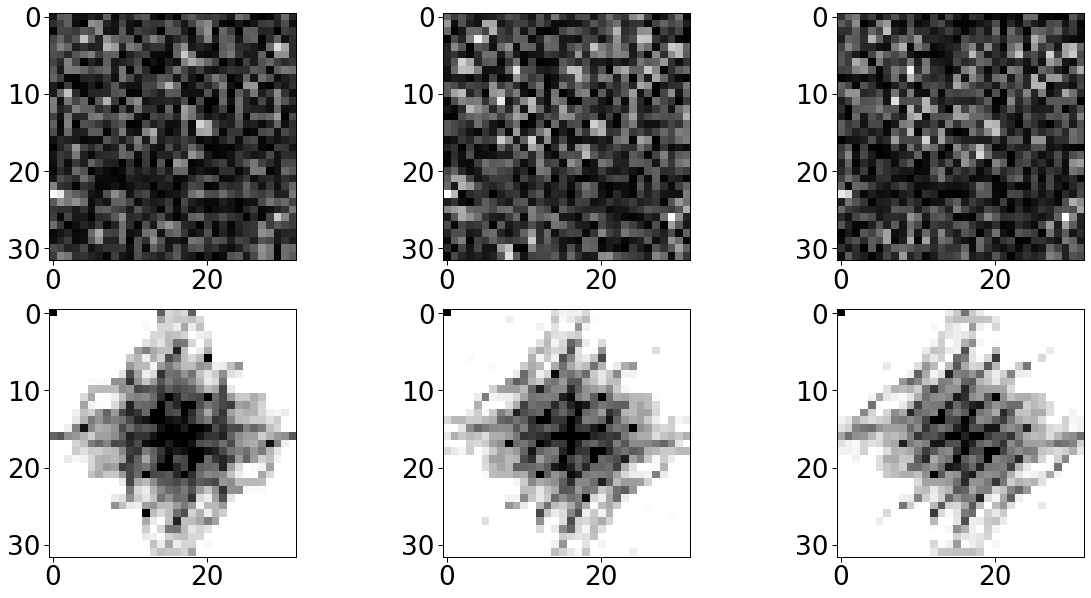

8 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 273/512 (53%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.280059934, Accuracy: 477/512 (93%)


Train set: Avg. loss: 0.077543966, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.032755479, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.018706003, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012489025, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.007056943, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004723884, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003482703, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002725337, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002220555, Accuracy: 512/512 (100%)

(tensor(64.), tensor(7.7776e+10))

Train set: Avg. loss: 0.001086322, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000693753, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000388396, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000263868, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000197858, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000082431, A

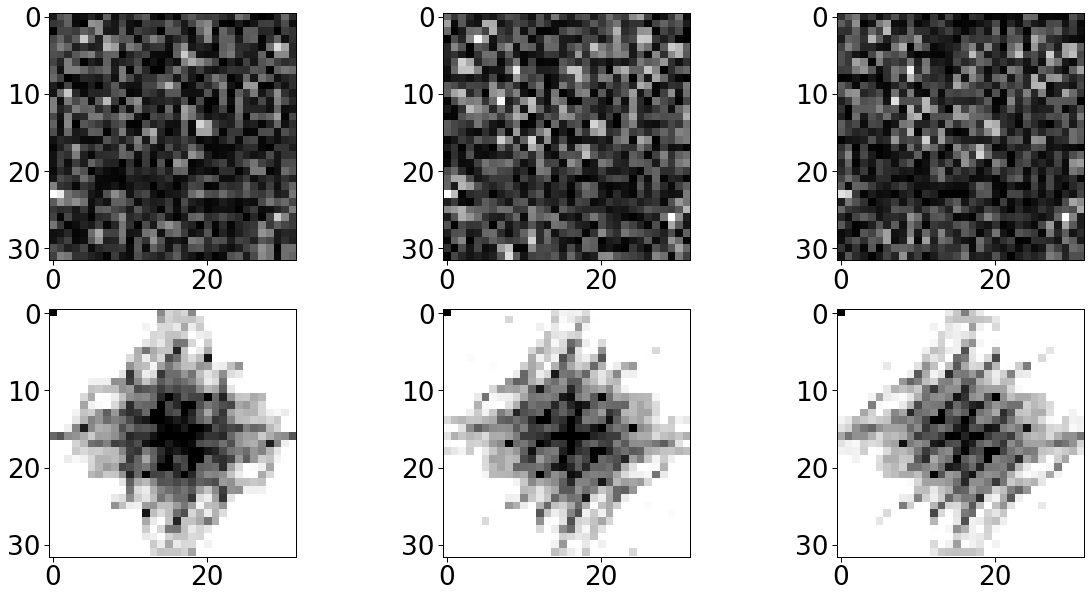

8 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 276/512 (54%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.276628703, Accuracy: 475/512 (93%)


Train set: Avg. loss: 0.075112410, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.031652406, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.018102054, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012105858, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.006856679, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004599438, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003396058, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002660575, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002169752, Accuracy: 512/512 (100%)

(tensor(63.), tensor(4.0796e+10))

Train set: Avg. loss: 0.001064080, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000680914, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000381833, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000259718, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000194884, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000081293, A

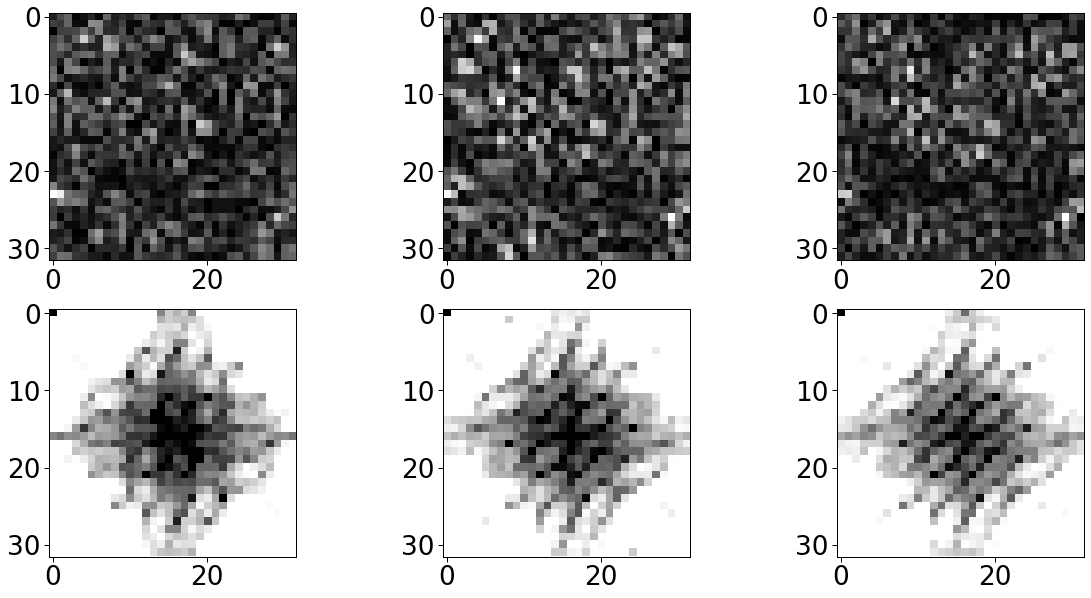

8 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 202/512 (39%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.280186564, Accuracy: 476/512 (93%)


Train set: Avg. loss: 0.077391341, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.032696787, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.018679369, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012474167, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.007050203, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004720194, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003480427, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002723816, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002219476, Accuracy: 512/512 (100%)

(tensor(63.), tensor(5.2069e+10))

Train set: Avg. loss: 0.001085921, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000693588, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000388338, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000263849, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000197853, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000082429, A

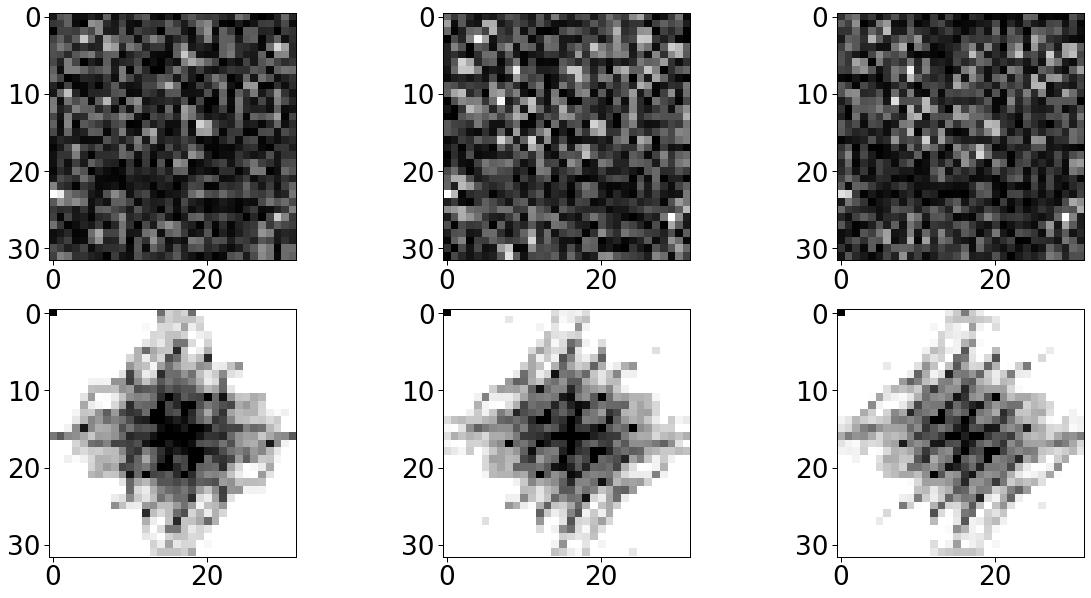

8 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 204/512 (40%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.274630576, Accuracy: 475/512 (93%)


Train set: Avg. loss: 0.072426721, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.030423159, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.017428007, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.011677074, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.006630506, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004457779, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003296190, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002584957, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002109712, Accuracy: 512/512 (100%)

(tensor(63.), tensor(4.9753e+10))

Train set: Avg. loss: 0.001036828, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000664769, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000373284, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000254180, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000190834, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000079688, A

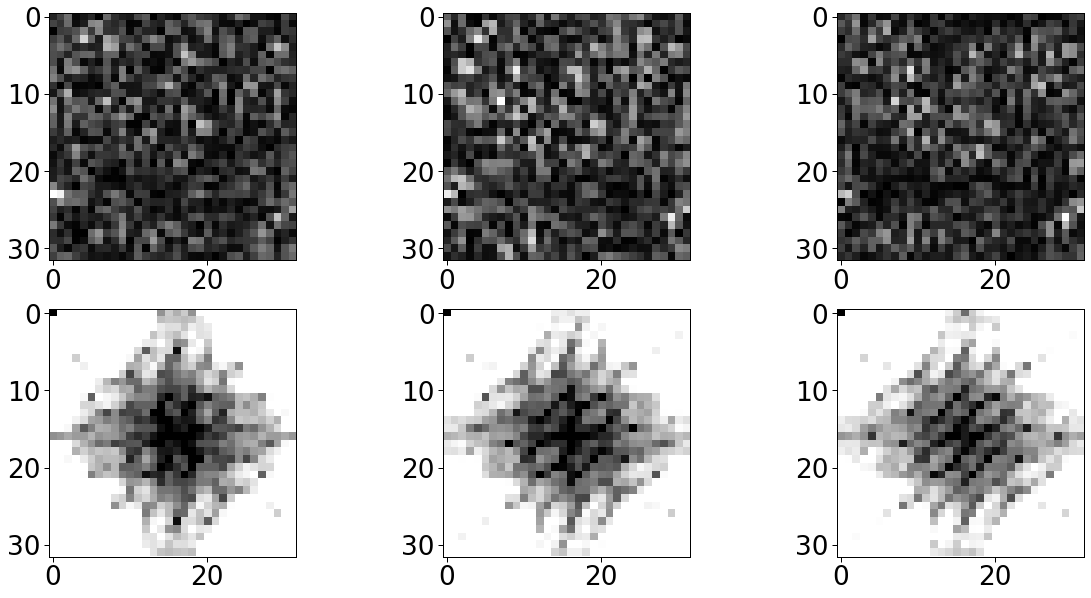

8 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 263/512 (51%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.207944423, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.049391769, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022002589, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013063981, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008946889, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005202248, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003550595, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002650067, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002091702, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001715284, Accuracy: 512/512 (100%)

(tensor(65.), tensor(2.3015e+14))

Train set: Avg. loss: 0.000852418, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000550751, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000311050, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000212709, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000160097, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000067087, A

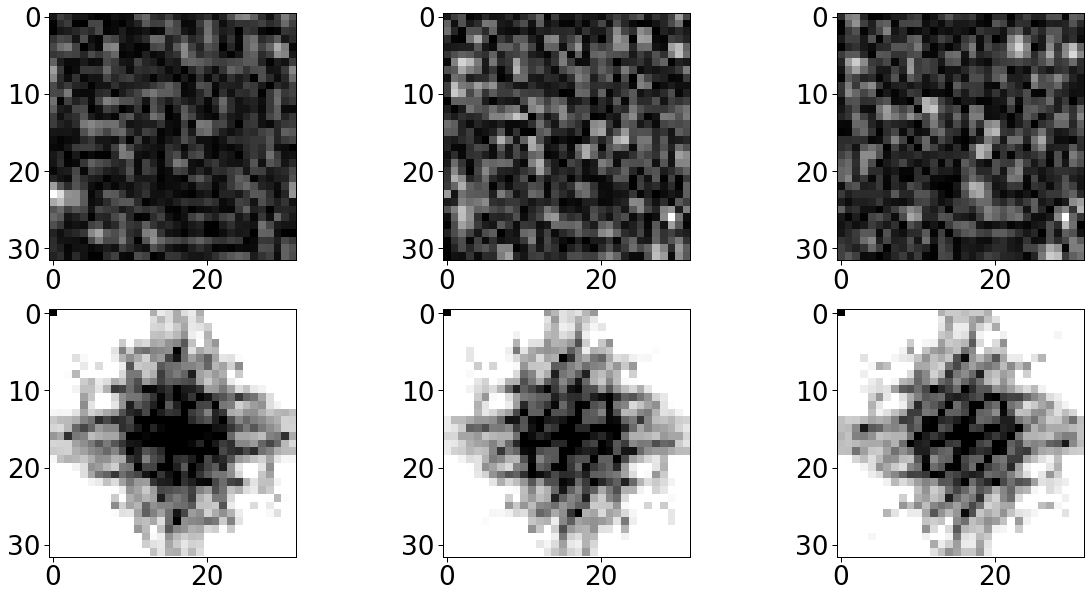

8 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 256/512 (50%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.210057691, Accuracy: 493/512 (96%)


Train set: Avg. loss: 0.049824227, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022088721, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013076084, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008938427, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005185650, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003535165, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002636627, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002080048, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001705101, Accuracy: 512/512 (100%)

(tensor(64.), tensor(2.9493e+14))

Train set: Avg. loss: 0.000846612, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000546788, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000308719, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000211076, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000158849, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000066567, A

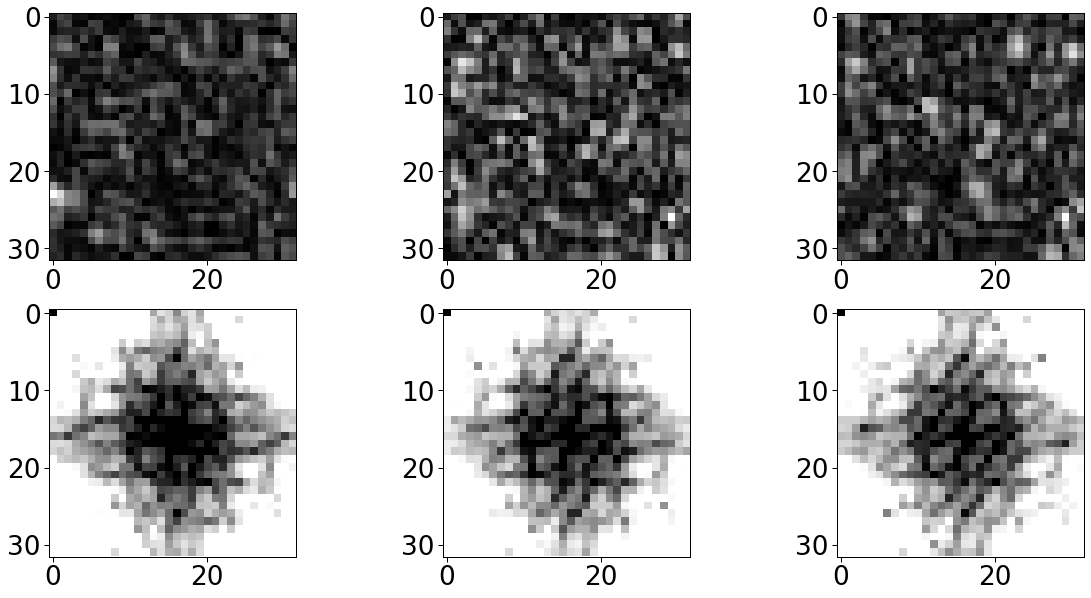

8 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 265/512 (52%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.200180471, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.048517473, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021694271, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012883477, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008819195, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005121360, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003492408, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002604898, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002054957, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001684426, Accuracy: 512/512 (100%)

(tensor(66.), tensor(2.3083e+14))

Train set: Avg. loss: 0.000835935, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000539821, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000304705, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000208321, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000156767, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000065688, A

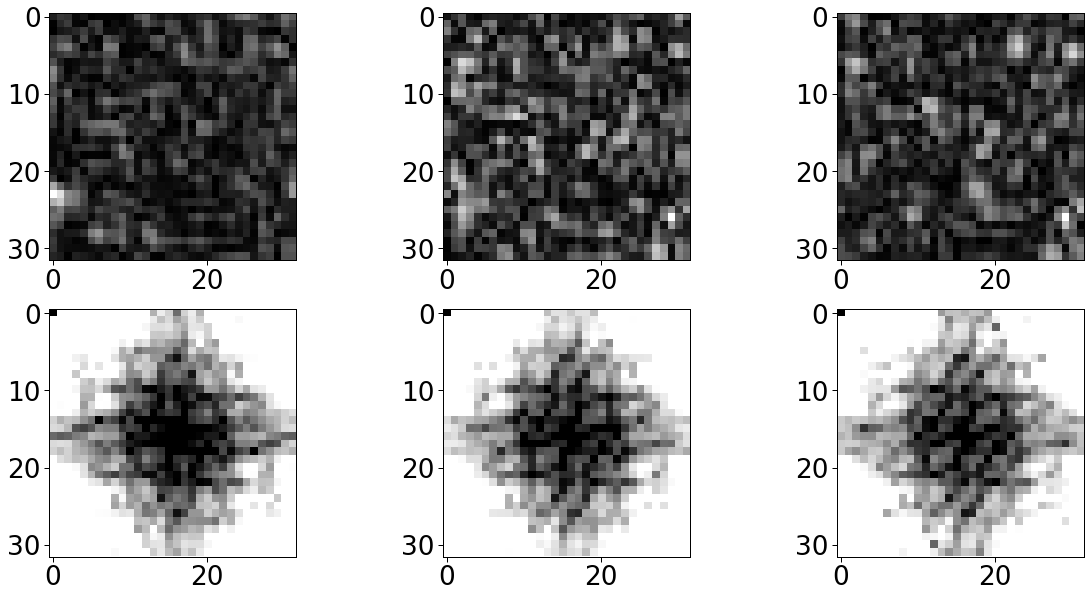

8 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 250/512 (49%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.199028820, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.048585147, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021751598, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012920105, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008844029, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005134578, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003500797, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002610766, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002059338, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001687847, Accuracy: 512/512 (100%)

(tensor(66.), tensor(3.0707e+14))

Train set: Avg. loss: 0.000837314, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000540636, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000305109, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000208582, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000156956, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000065757, A

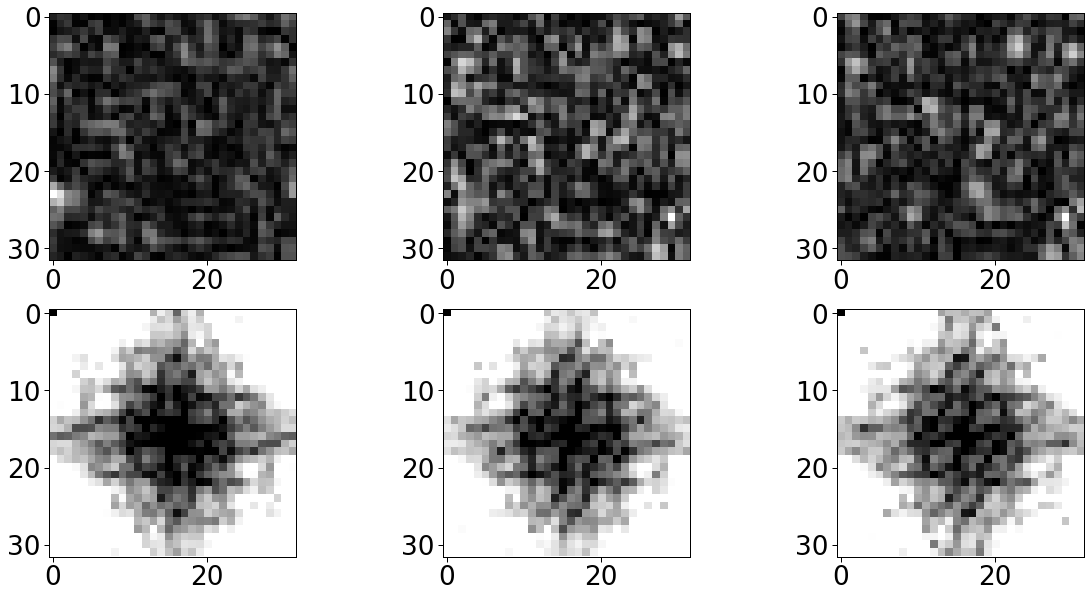

8 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 253/512 (49%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.200416207, Accuracy: 494/512 (96%)


Train set: Avg. loss: 0.048911400, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021875242, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012983749, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008883160, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005154217, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003512902, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002619178, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002065633, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001692797, Accuracy: 512/512 (100%)

(tensor(66.), tensor(5.5292e+14))

Train set: Avg. loss: 0.000839499, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000541925, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000305776, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000209005, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000157260, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000065870, A

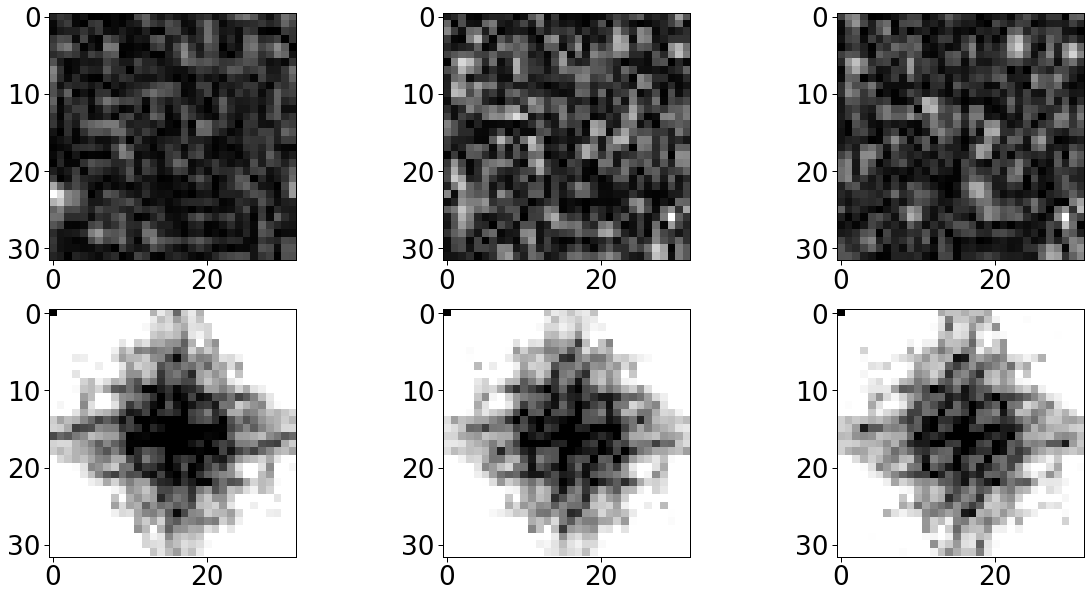

8 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 251/512 (49%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.196164399, Accuracy: 494/512 (96%)


Train set: Avg. loss: 0.048803456, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021845059, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012964344, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008867896, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005143322, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003504226, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002611958, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002059456, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001687412, Accuracy: 512/512 (100%)

(tensor(67.), tensor(2.7991e+15))

Train set: Avg. loss: 0.000836466, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000539819, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000304510, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000208108, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000156566, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000065578, A

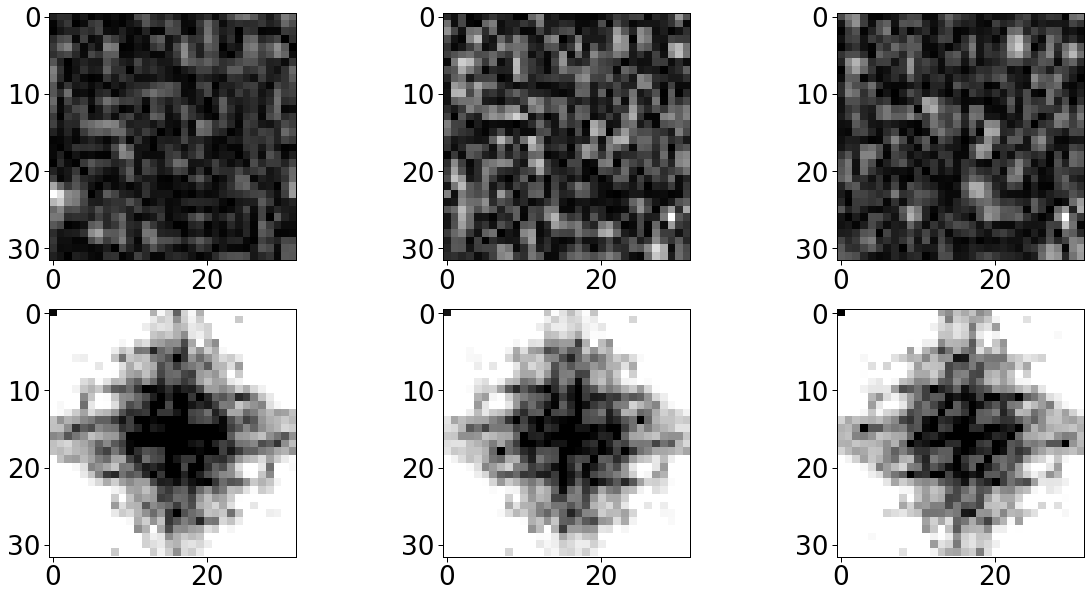

8 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 247/512 (48%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.203805000, Accuracy: 494/512 (96%)


Train set: Avg. loss: 0.049226440, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021929320, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012996205, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008885374, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005152613, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003511104, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002617636, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002064361, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001691751, Accuracy: 512/512 (100%)

(tensor(66.), tensor(4.3593e+14))

Train set: Avg. loss: 0.000839113, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000541720, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000305698, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000208963, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000157233, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000065869, A

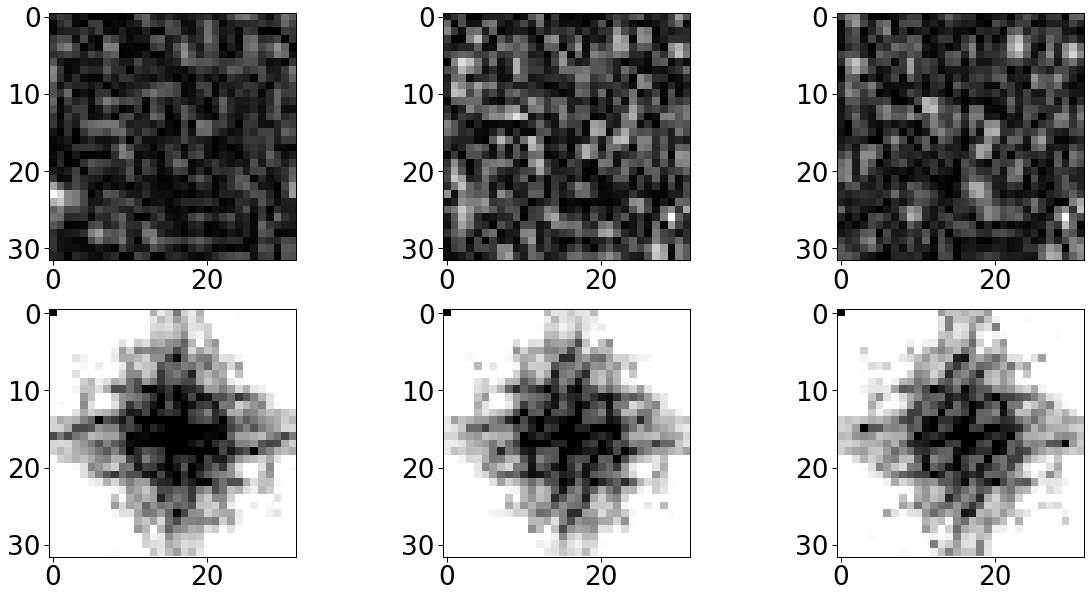

8 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 284/512 (55%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.204034135, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.049680334, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.022088295, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013070646, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008927297, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005170563, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003520672, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002623434, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002068168, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001694388, Accuracy: 512/512 (100%)

(tensor(65.), tensor(1.2877e+15))

Train set: Avg. loss: 0.000839781, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000541916, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000305683, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000208900, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000157160, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000065820, A

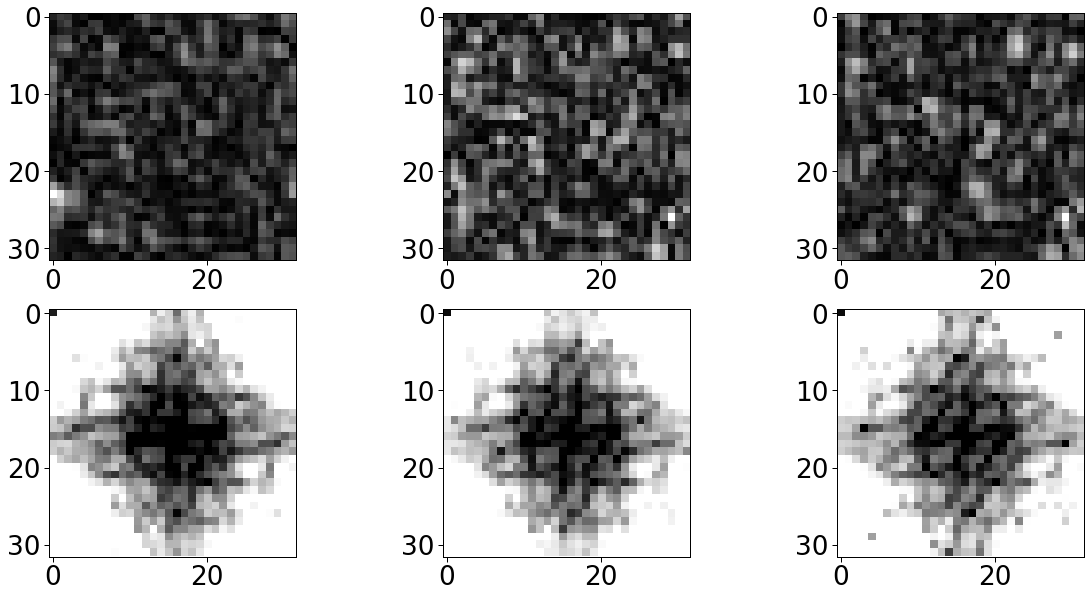

8 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 301/512 (59%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.198573679, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.048502531, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021742001, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012925097, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008852111, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005142443, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003507344, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002616196, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002063916, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001691772, Accuracy: 512/512 (100%)

(tensor(66.), tensor(2.2759e+14))

Train set: Avg. loss: 0.000839404, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000542041, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000305916, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000209144, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000157384, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000065930, A

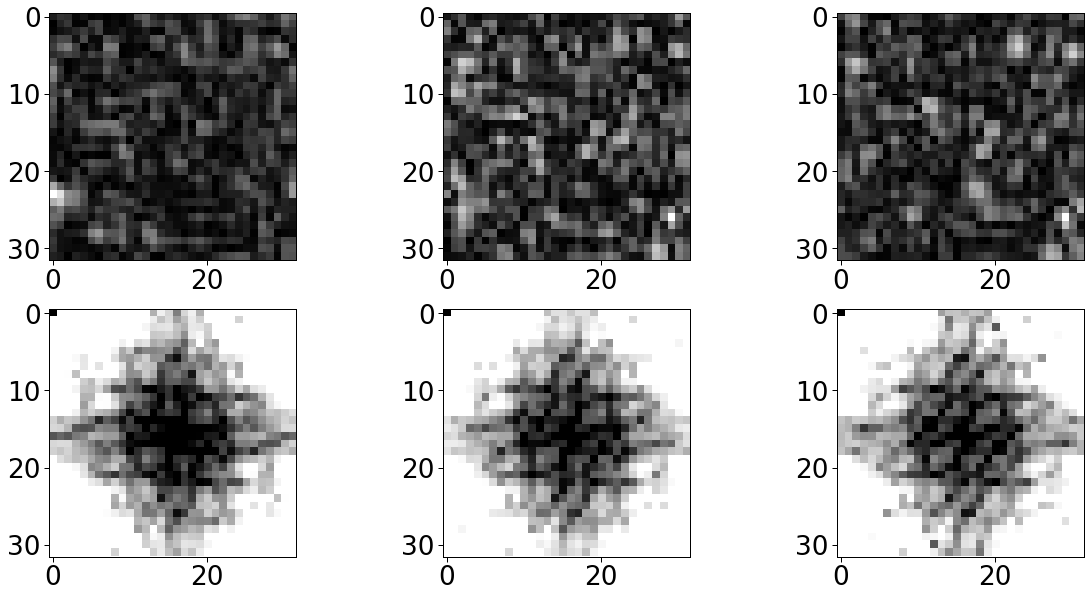

8 2
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 269/512 (53%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.197012588, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.048626866, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021796266, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012949937, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008864748, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005145961, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003508026, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002615781, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002063035, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001690696, Accuracy: 512/512 (100%)

(tensor(67.), tensor(9.0667e+14))

Train set: Avg. loss: 0.000838401, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000541238, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000305380, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000208745, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000157067, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000065791, A

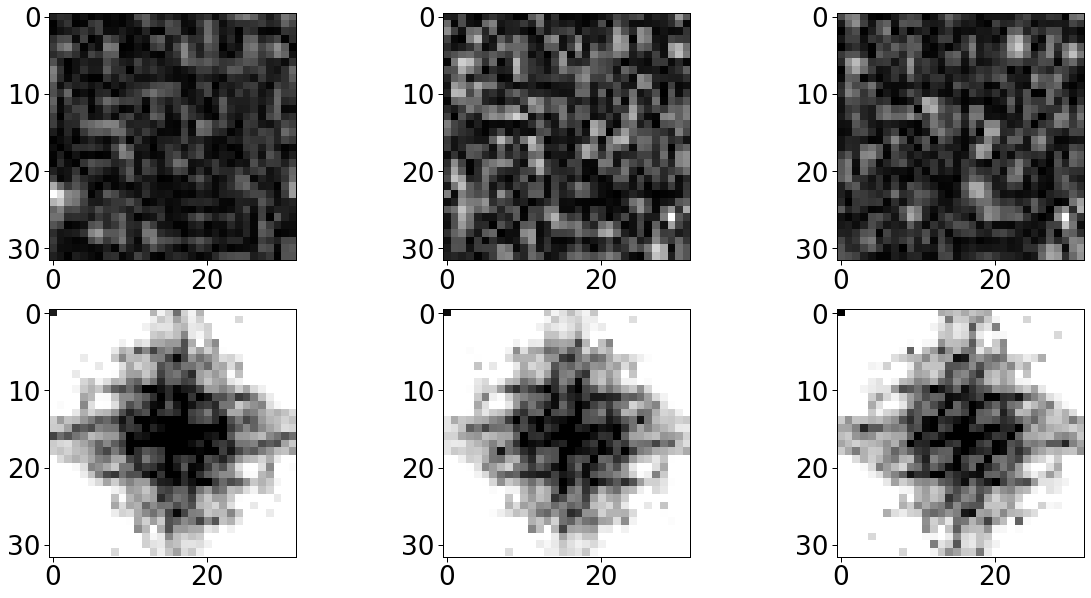

8 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 221/512 (43%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.198604628, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.048536349, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021625772, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012812427, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008758735, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005078638, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003460824, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002580666, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002035696, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001668663, Accuracy: 512/512 (100%)

(tensor(66.), tensor(4.1800e+13))

Train set: Avg. loss: 0.000827725, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000534452, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000301701, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000206281, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000155265, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000065006, A

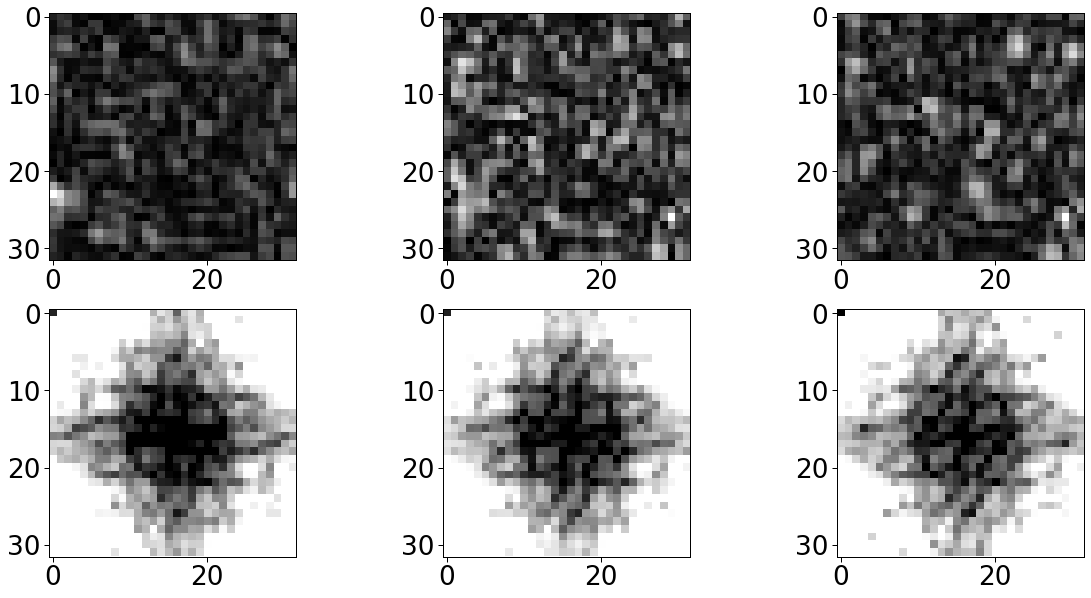

8 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 254/512 (50%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.198546439, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.048470579, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021661419, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012850326, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008789223, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005097868, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003473724, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002589732, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002042339, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001673701, Accuracy: 512/512 (100%)

(tensor(67.), tensor(7.4888e+13))

Train set: Avg. loss: 0.000829829, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000535644, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000302247, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000206604, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000155472, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000065104, A

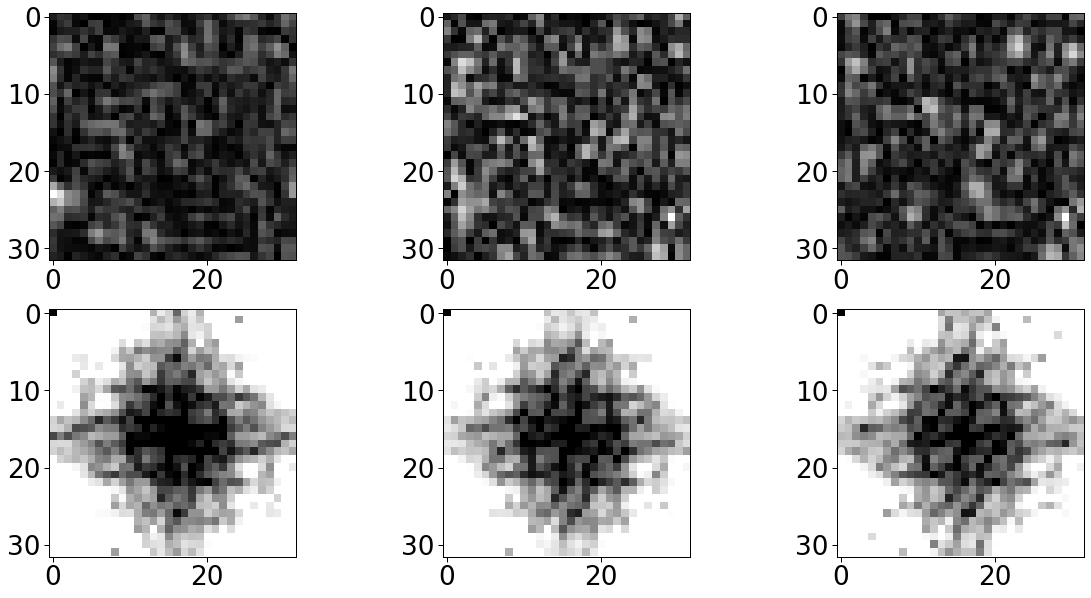

8 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 352/512 (69%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.195283413, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.047852911, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021338450, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012652268, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008654513, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005022610, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003424420, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002554485, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002015627, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001652593, Accuracy: 512/512 (100%)

(tensor(66.), tensor(3.7264e+13))

Train set: Avg. loss: 0.000820386, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000529900, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000299266, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000204662, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000154071, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064534, A

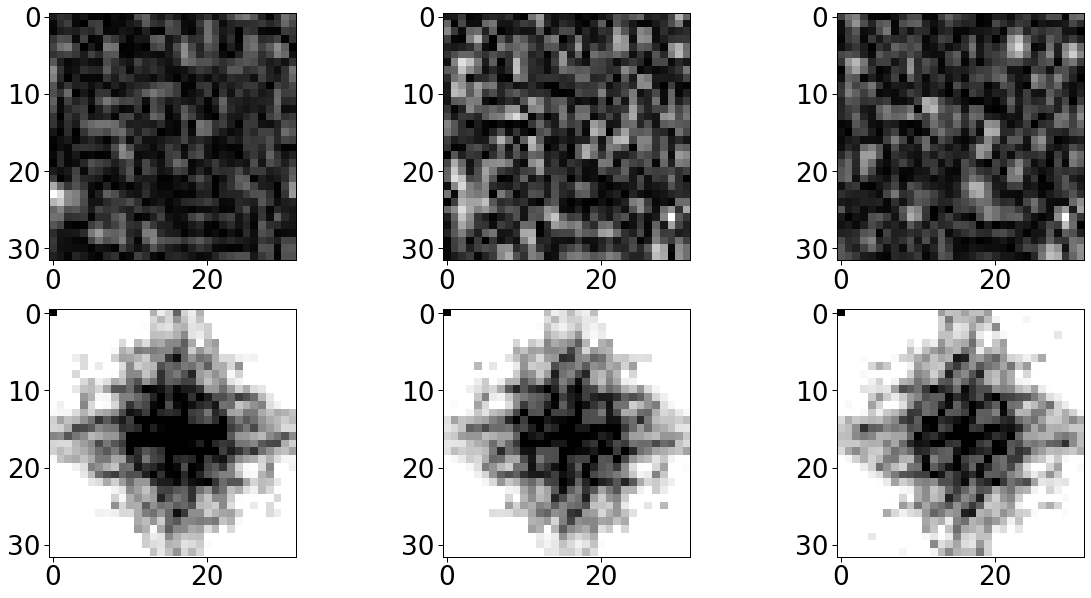

8 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 252/512 (49%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.196018875, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.048042908, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021396162, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012676986, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008667224, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005026761, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003426038, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002555097, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002015776, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001652506, Accuracy: 512/512 (100%)

(tensor(67.), tensor(3.0705e+13))

Train set: Avg. loss: 0.000820017, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000529585, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000299044, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000204498, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000153943, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064474, A

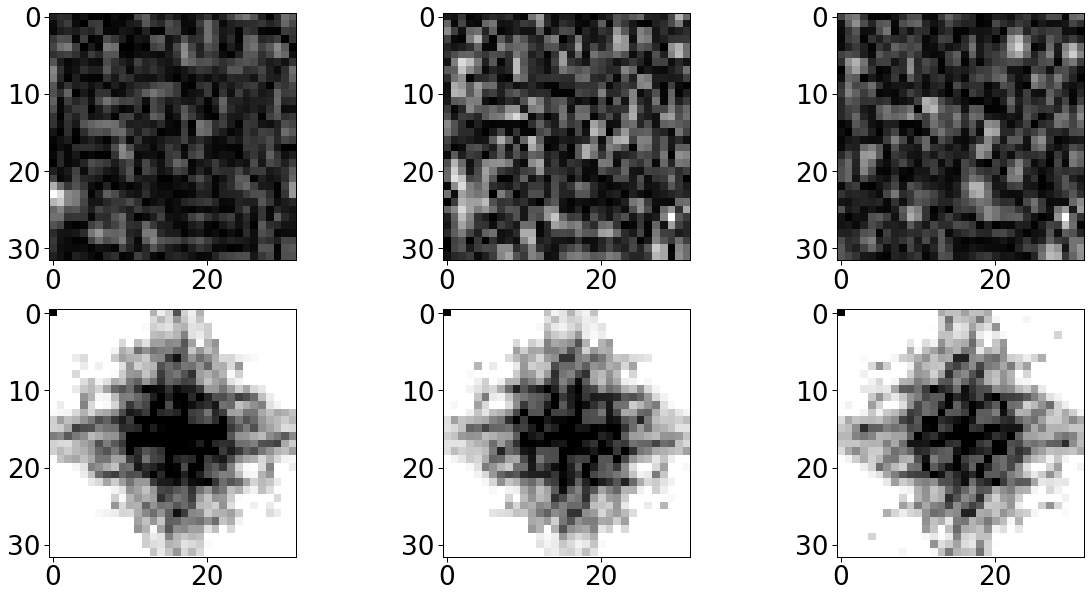

8 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 233/512 (46%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.199314103, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.048490781, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021658571, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012848175, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008788670, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005098967, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003475428, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002591606, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002044220, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001675520, Accuracy: 512/512 (100%)

(tensor(66.), tensor(5.4394e+13))

Train set: Avg. loss: 0.000831103, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000536605, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000302865, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000207057, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000155827, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000065254, A

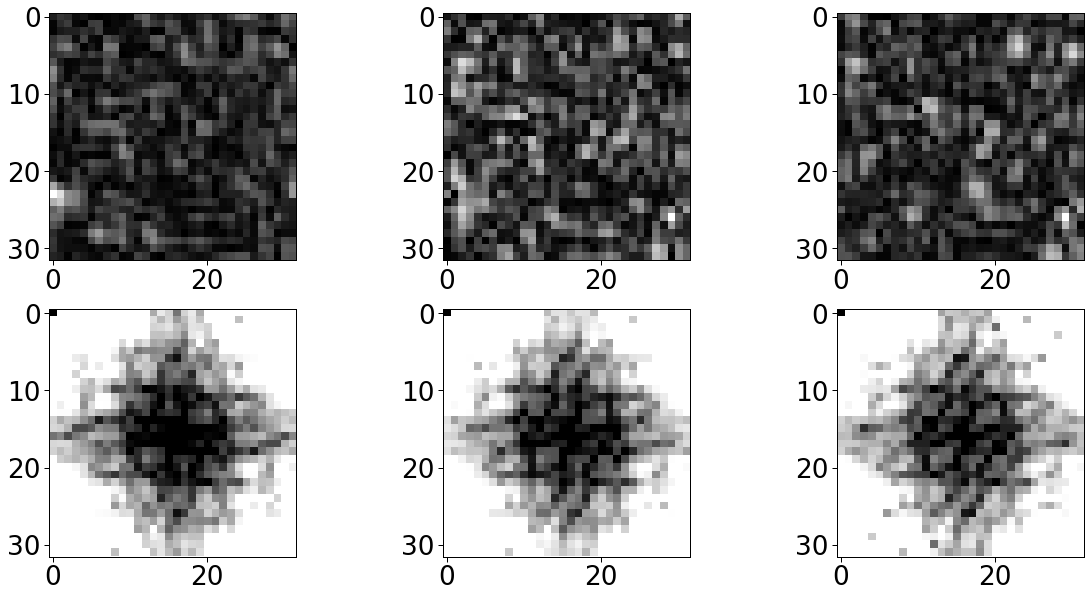

8 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 288/512 (56%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.203398168, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.049127866, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021898318, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012977948, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008872268, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005143846, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003504477, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002612401, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002060086, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001688160, Accuracy: 512/512 (100%)

(tensor(65.), tensor(1.5332e+14))

Train set: Avg. loss: 0.000836901, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000540165, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000304751, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000208294, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000156729, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000065613, A

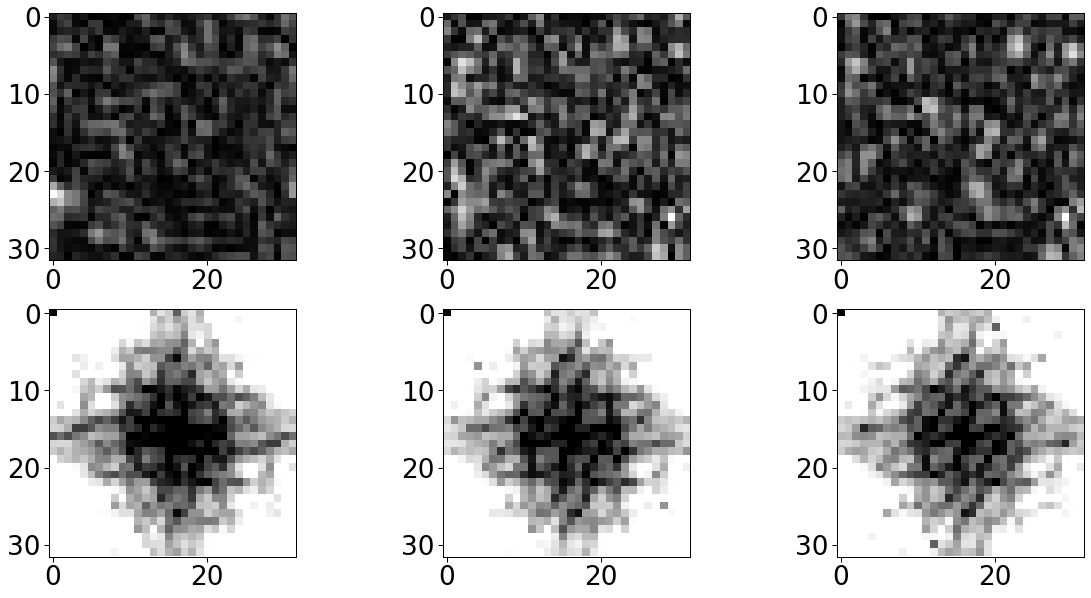

8 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 260/512 (51%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.197512984, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.048167136, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021509107, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012756922, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008724957, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005060994, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003449127, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002571809, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002028508, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001662589, Accuracy: 512/512 (100%)

(tensor(67.), tensor(3.0285e+13))

Train set: Avg. loss: 0.000824657, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000532456, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000300557, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000205498, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000154667, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064790, A

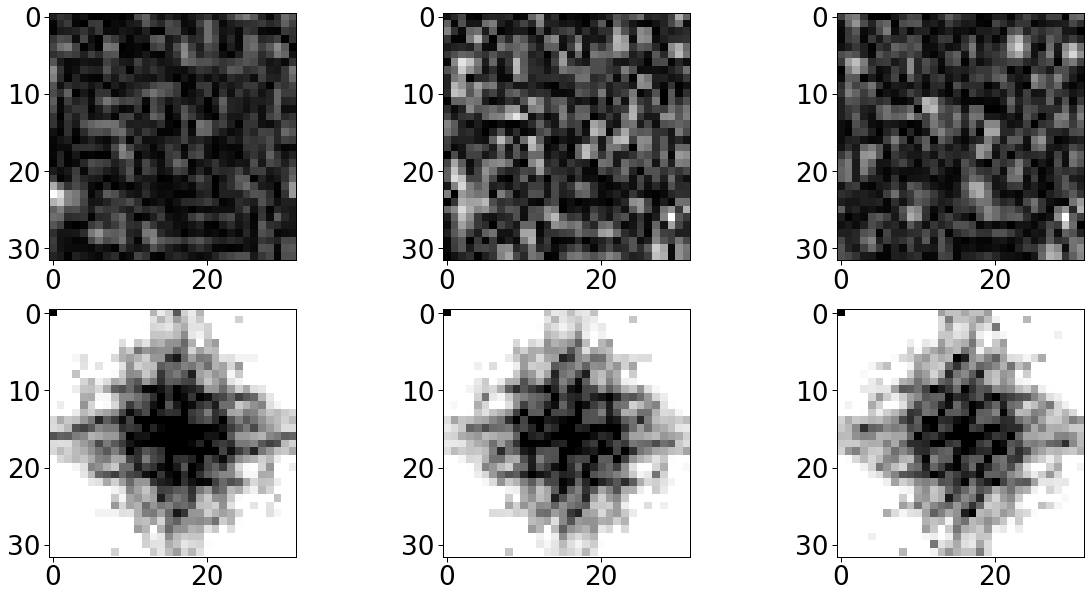

8 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 239/512 (47%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.199344844, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.048420131, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021639746, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012840236, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008783570, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005095763, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003472645, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002589022, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002041803, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001673260, Accuracy: 512/512 (100%)

(tensor(67.), tensor(2.0661e+14))

Train set: Avg. loss: 0.000829771, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000535611, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000302233, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000206588, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000155452, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000065107, A

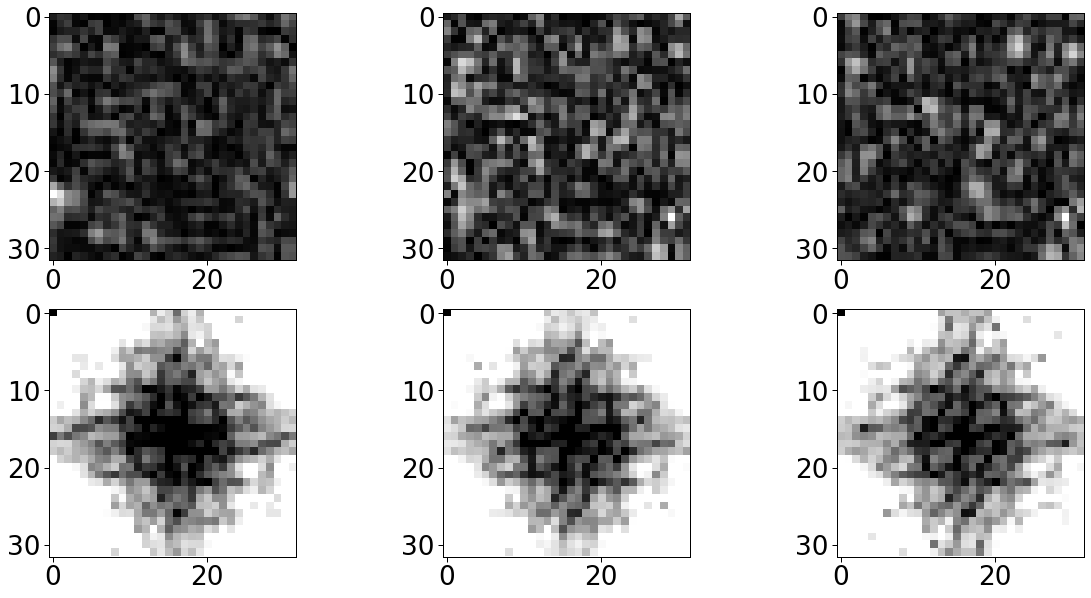

8 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 328/512 (64%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.198305786, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.048322476, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021560740, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012783219, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008741404, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005069694, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003454706, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002575760, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002031497, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001664955, Accuracy: 512/512 (100%)

(tensor(66.), tensor(7.9454e+13))

Train set: Avg. loss: 0.000825775, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000533151, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000300927, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000205740, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000154841, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064858, A

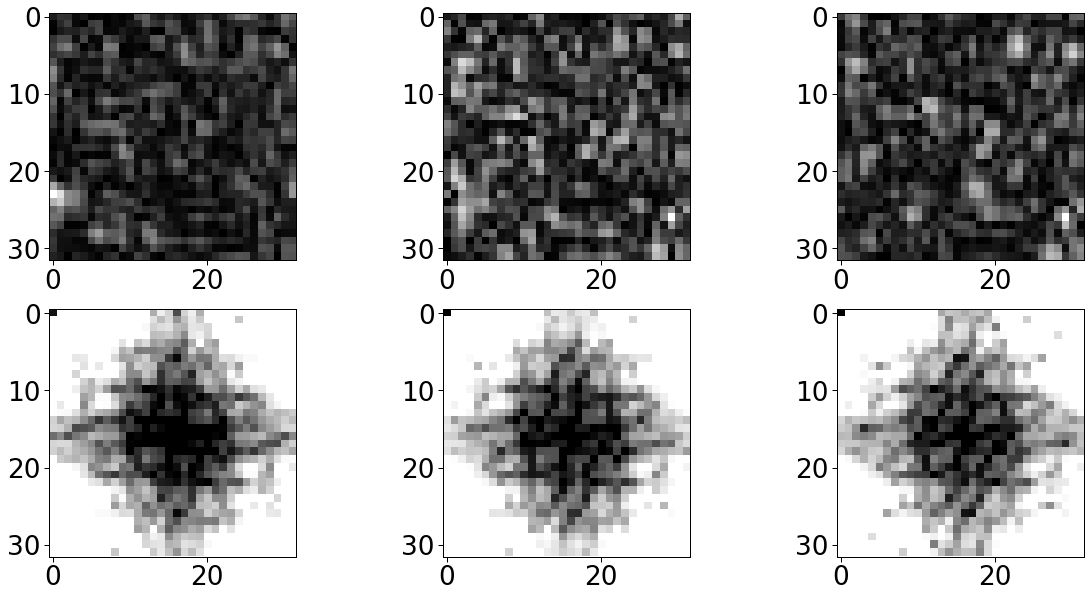

8 3
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 265/512 (52%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.195595205, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.048473191, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021647515, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012829987, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008769450, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005081915, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003460674, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002579053, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002033439, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001666138, Accuracy: 512/512 (100%)

(tensor(68.), tensor(1.2348e+14))

Train set: Avg. loss: 0.000825514, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000532655, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000300505, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000205392, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000154565, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064705, A

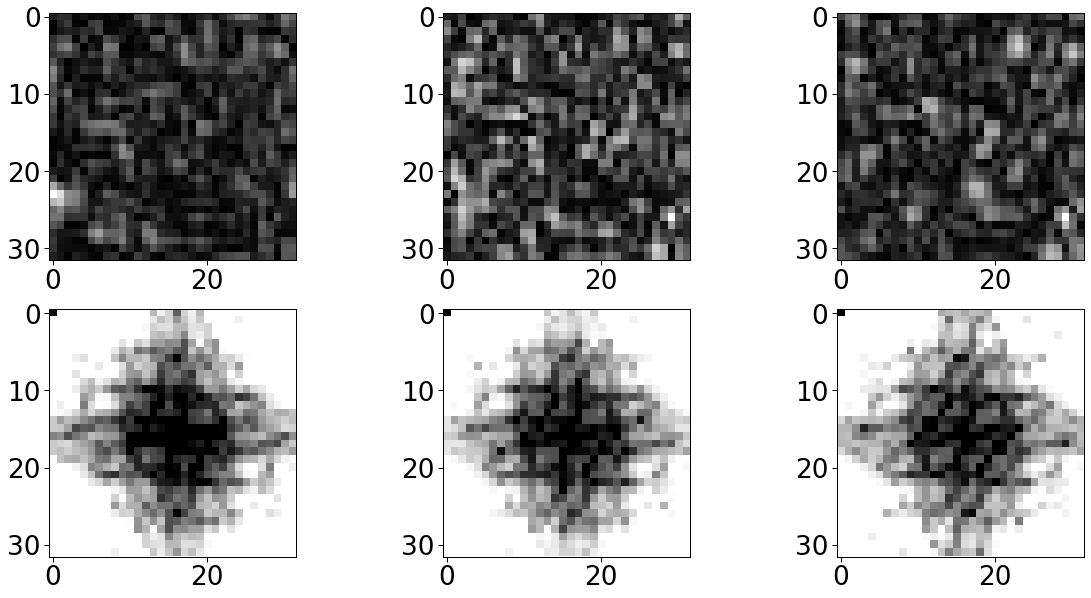

8 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 207/512 (40%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.192561403, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.047674794, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021290874, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012626596, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008636055, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005010097, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003414673, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002546418, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002008736, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001646586, Accuracy: 512/512 (100%)

(tensor(68.), tensor(5.0302e+13))

Train set: Avg. loss: 0.000816996, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000527593, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000297916, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000203728, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000153362, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064256, A

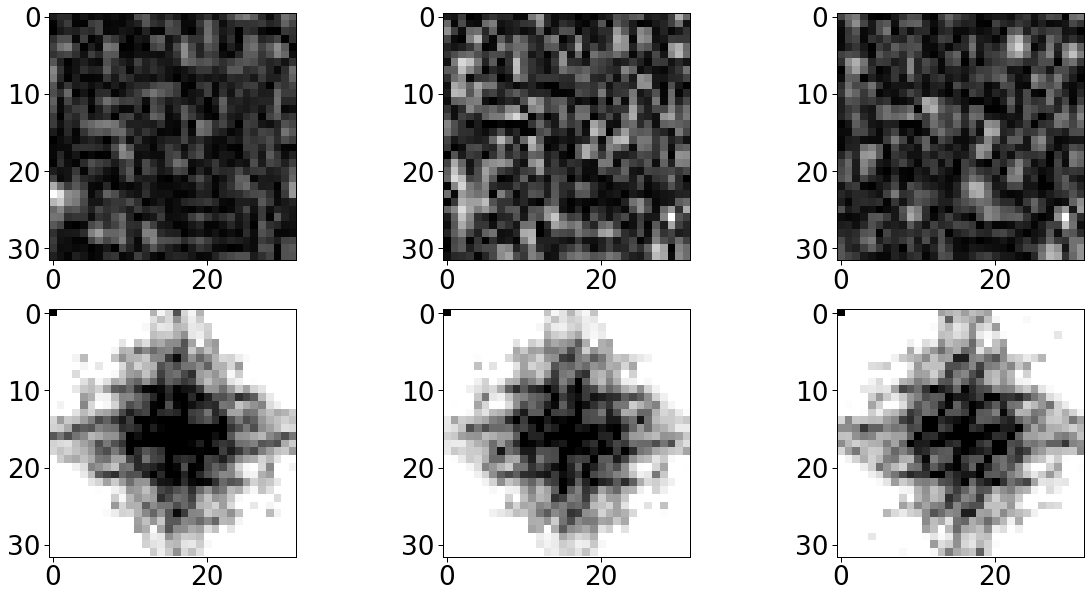

8 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 227/512 (44%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.194513902, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.048019327, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021408349, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012687916, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008675773, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005032145, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003429711, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002557838, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002017935, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001654276, Accuracy: 512/512 (100%)

(tensor(67.), tensor(5.7759e+13))

Train set: Avg. loss: 0.000820798, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000530047, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000299283, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000204653, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000154058, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064510, A

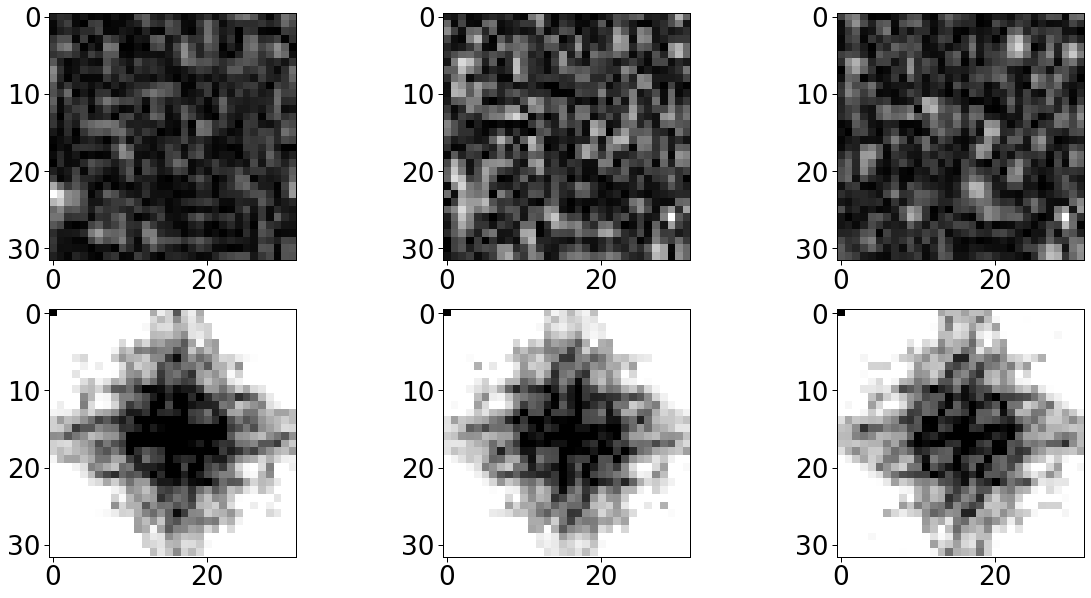

8 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 279/512 (54%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.194419980, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.048116609, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021445122, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012703449, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008682874, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005033301, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003429159, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002556702, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002016604, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001652907, Accuracy: 512/512 (100%)

(tensor(67.), tensor(5.5727e+13))

Train set: Avg. loss: 0.000819746, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000529247, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000298770, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000204280, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000153766, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064387, A

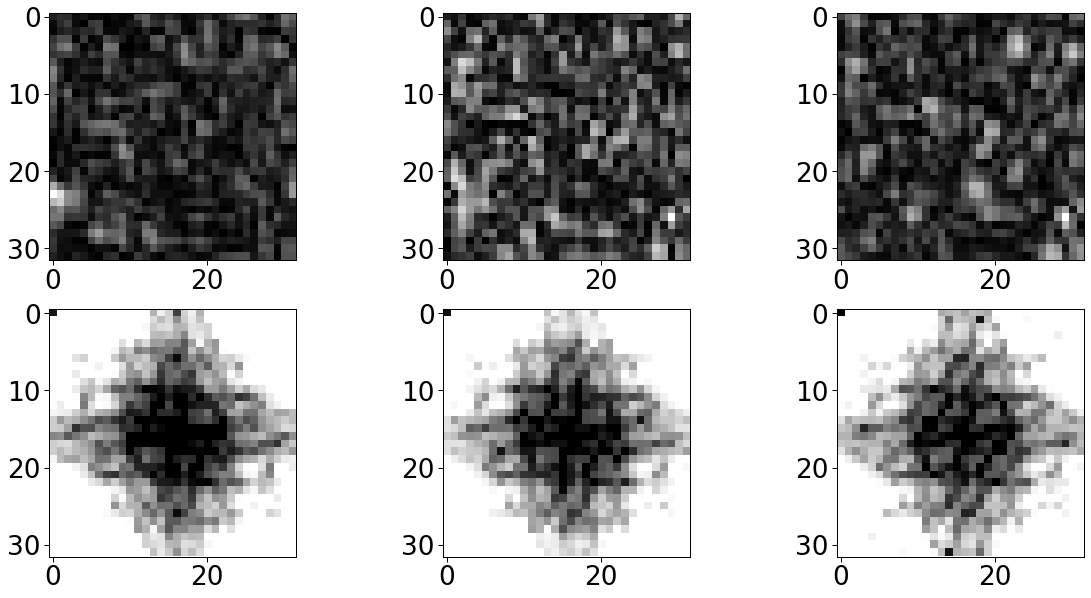

8 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 224/512 (44%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.197399661, Accuracy: 494/512 (96%)


Train set: Avg. loss: 0.047794864, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021258995, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012598935, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008617926, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005003282, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003412911, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002546781, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002010072, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001648378, Accuracy: 512/512 (100%)

(tensor(66.), tensor(2.0483e+13))

Train set: Avg. loss: 0.000819054, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000529349, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000299099, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000204612, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000154054, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064566, A

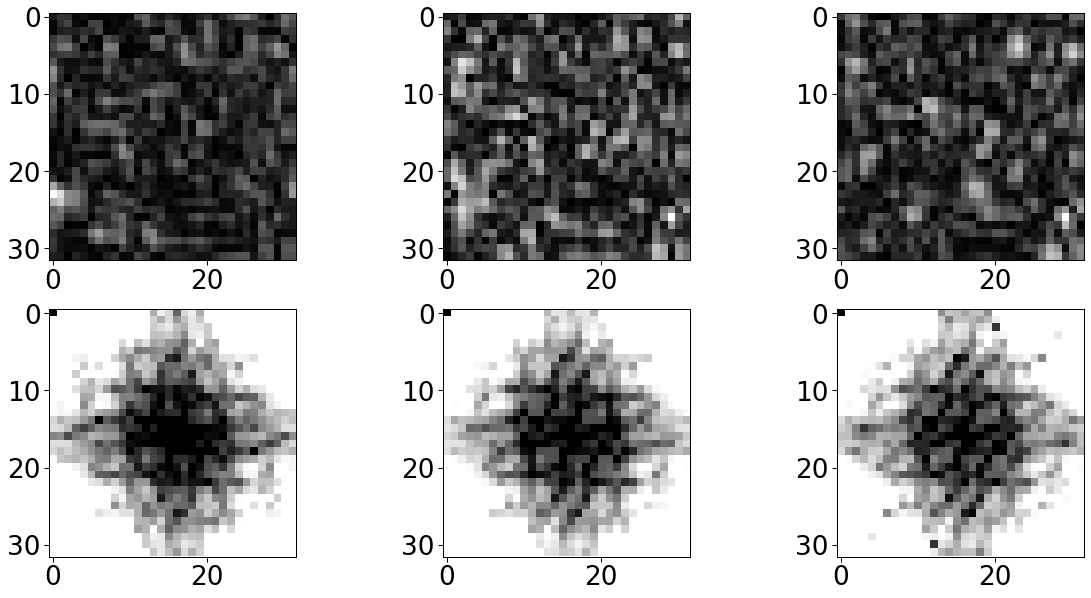

8 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 241/512 (47%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.194809973, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.047745485, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021290541, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012624124, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008635254, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005011276, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003416582, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002548553, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002010888, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001648672, Accuracy: 512/512 (100%)

(tensor(67.), tensor(3.4394e+13))

Train set: Avg. loss: 0.000818416, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000528630, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000298556, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000204183, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000153713, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064392, A

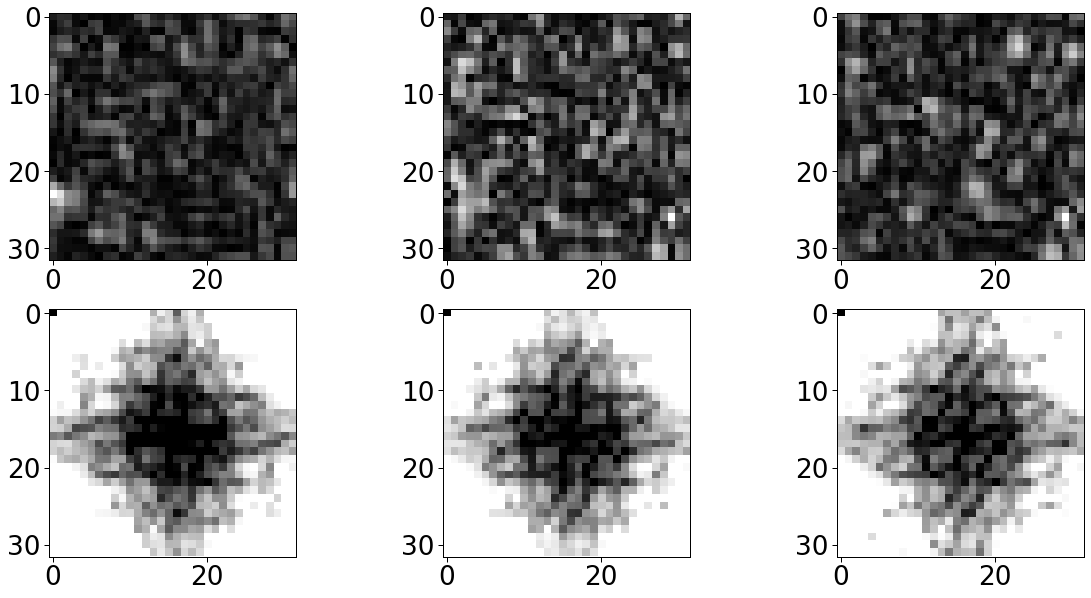

8 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 284/512 (55%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.194704220, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.047903508, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021397082, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012691093, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008680478, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005035911, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003432189, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002559363, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002018851, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001654804, Accuracy: 512/512 (100%)

(tensor(68.), tensor(5.3344e+13))

Train set: Avg. loss: 0.000820972, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000530109, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000299290, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000204647, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000154042, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064530, A

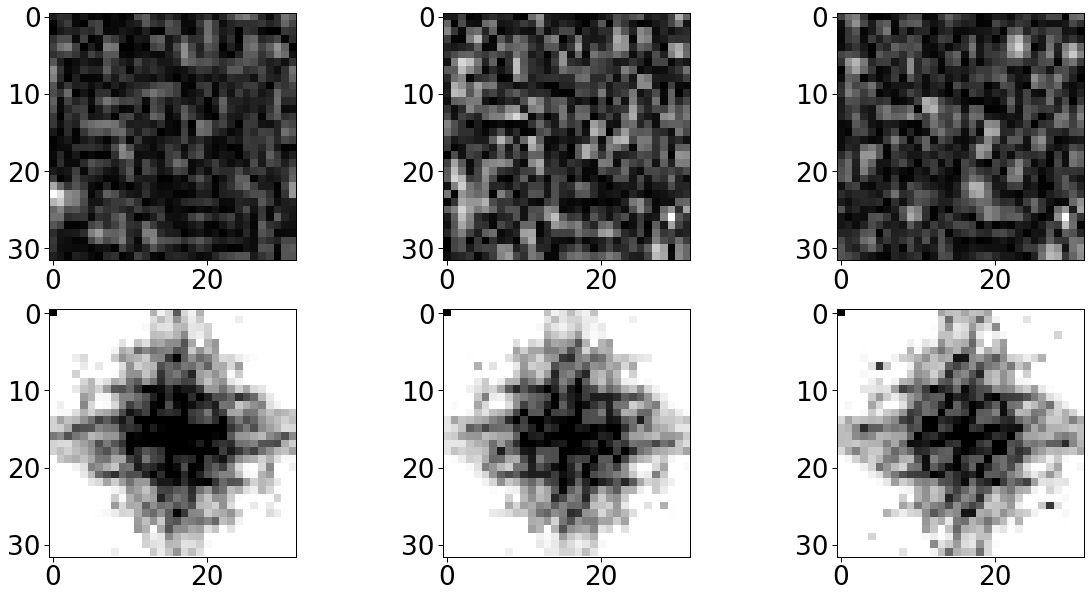

8 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 294/512 (57%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.194264472, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.047597852, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021244928, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012602656, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008622388, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005005007, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003412535, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002545539, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002008477, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001646656, Accuracy: 512/512 (100%)

(tensor(67.), tensor(4.3643e+13))

Train set: Avg. loss: 0.000817514, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000528065, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000298261, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000203989, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000153569, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064355, A

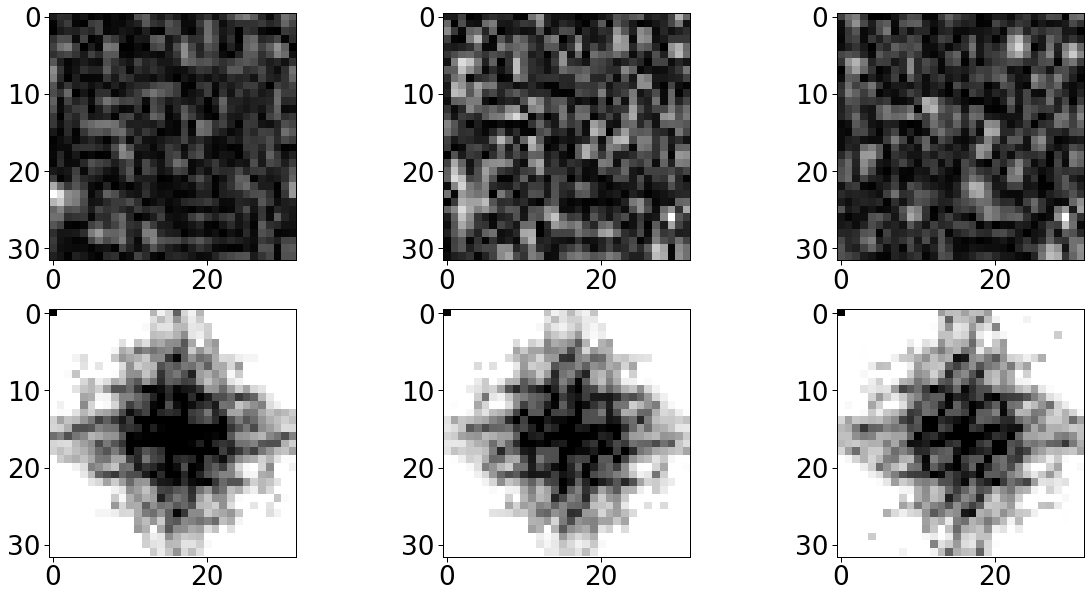

8 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 256/512 (50%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.194632828, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.047782794, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021298714, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012625888, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008635544, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005011005, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003416503, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002548615, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002011033, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001648857, Accuracy: 512/512 (100%)

(tensor(67.), tensor(3.6279e+13))

Train set: Avg. loss: 0.000818525, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000528725, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000298608, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000204219, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000153742, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064392, A

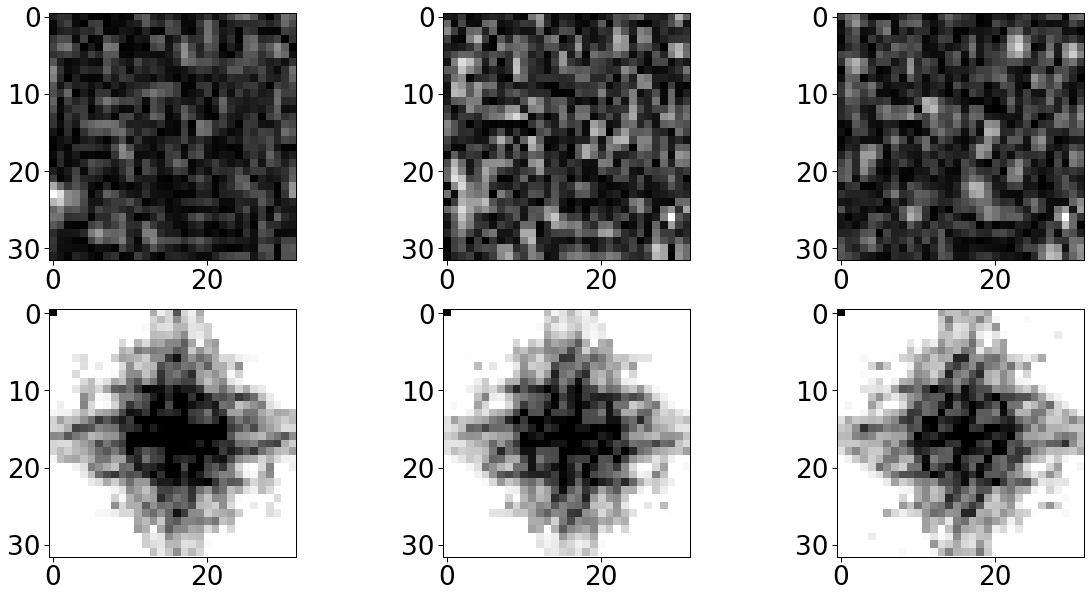

8 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 254/512 (50%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.191166505, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.047433536, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021179620, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012563227, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008595106, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004988794, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003401370, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002537268, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002002022, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001641428, Accuracy: 512/512 (100%)

(tensor(67.), tensor(4.4940e+13))

Train set: Avg. loss: 0.000814883, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000526351, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000297294, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000203324, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000153072, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064130, A

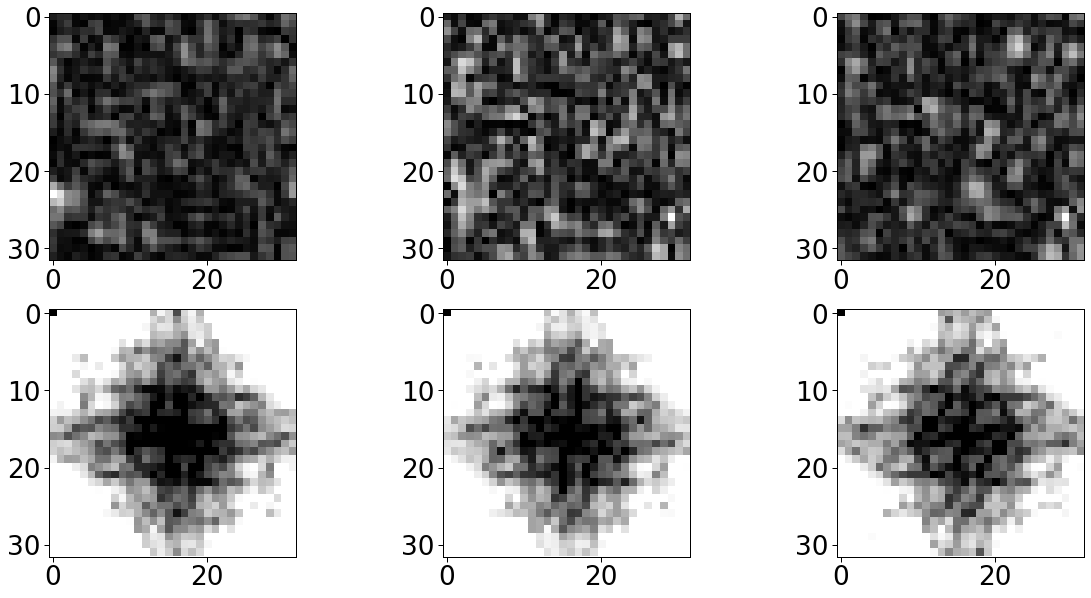

8 4
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 221/512 (43%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.195675641, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.047963064, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021374637, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012670130, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008665705, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005028409, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003428591, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002557760, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002018320, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001654876, Accuracy: 512/512 (100%)

(tensor(67.), tensor(3.4524e+13))

Train set: Avg. loss: 0.000821496, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000530676, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000299701, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000204970, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000154307, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064618, A

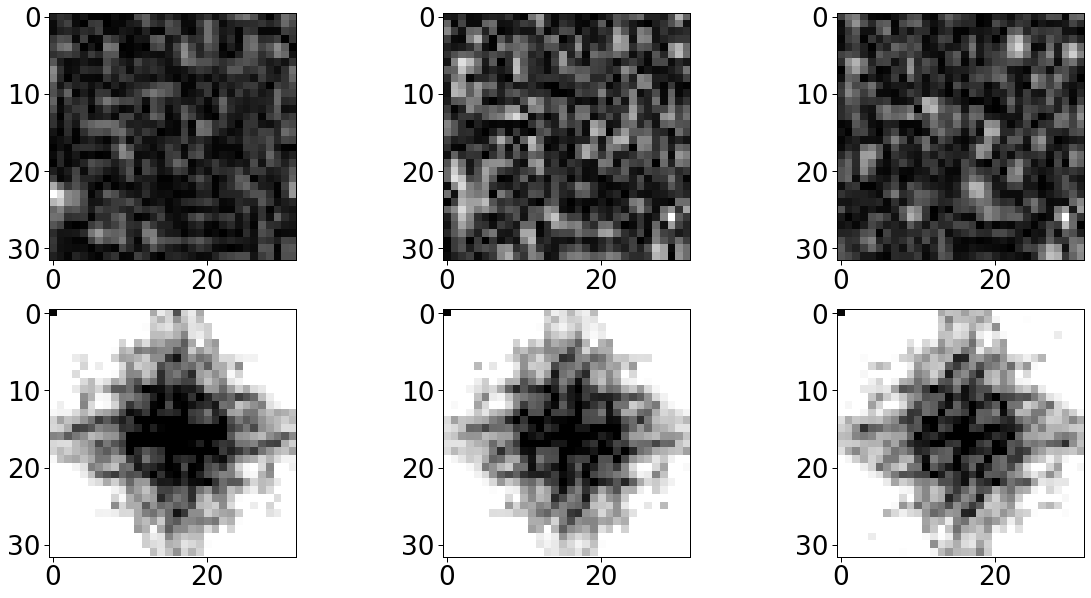

8 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 315/512 (62%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.192882746, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.047501788, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021200124, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012575544, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008604188, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.004994910, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003406169, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002541156, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002005267, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001644198, Accuracy: 512/512 (100%)

(tensor(67.), tensor(3.3095e+13))

Train set: Avg. loss: 0.000816433, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000527428, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000297919, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000203762, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000153403, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064270, A

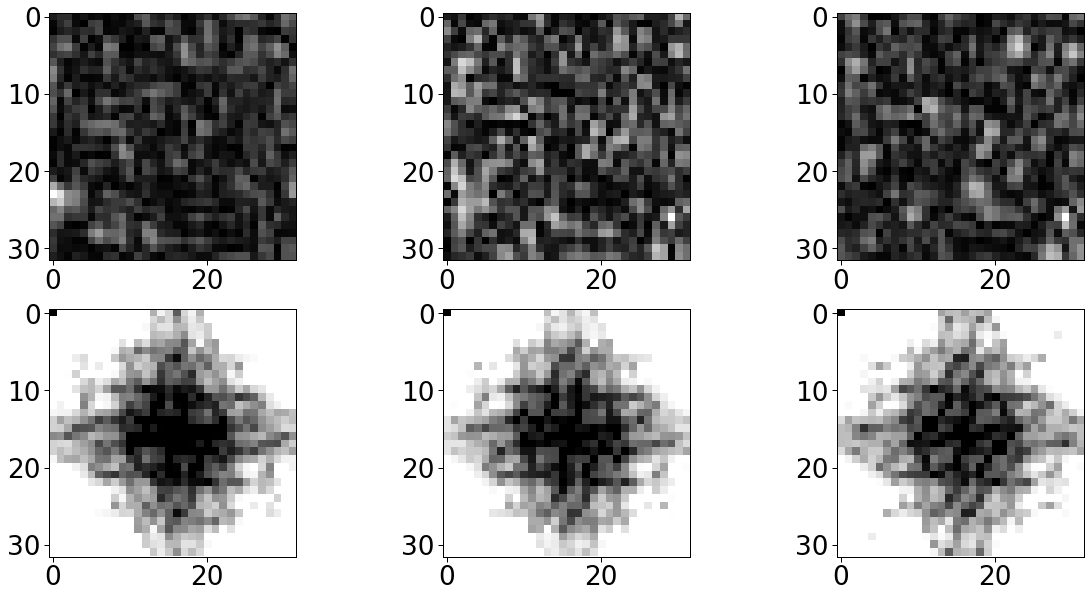

8 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 212/512 (41%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.194891736, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.047804572, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021334028, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012654781, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008658210, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005025799, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003427057, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002556646, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002017426, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001654121, Accuracy: 512/512 (100%)

(tensor(67.), tensor(3.4556e+13))

Train set: Avg. loss: 0.000821151, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000530420, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000299557, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000204865, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000154225, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064594, A

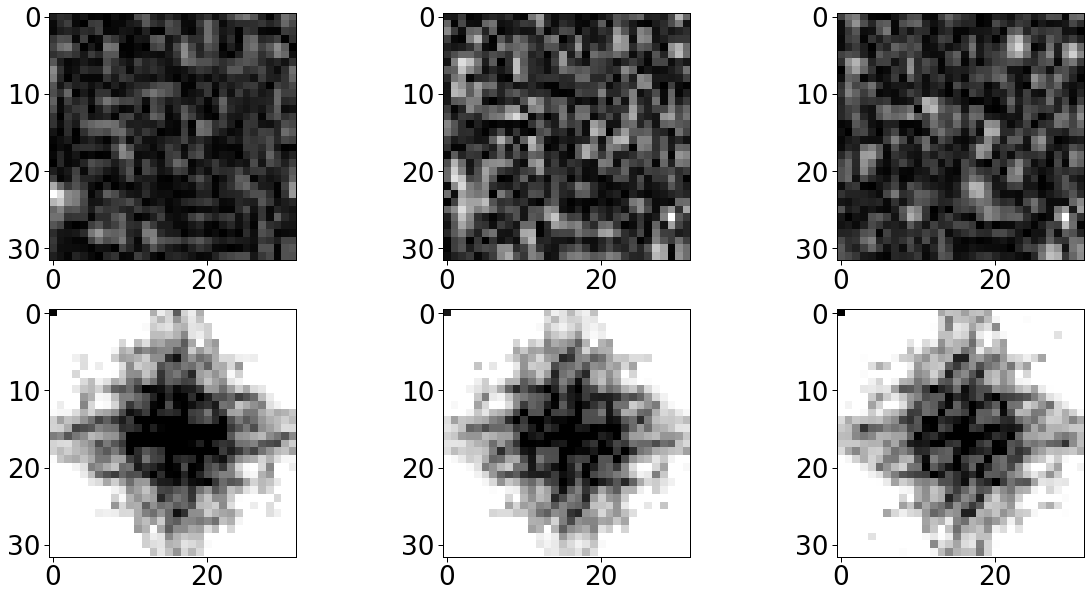

8 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 277/512 (54%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.194190785, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.047857657, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021336401, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012648462, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008651007, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005019927, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003422686, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002553242, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002014670, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001651821, Accuracy: 512/512 (100%)

(tensor(67.), tensor(3.8871e+13))

Train set: Avg. loss: 0.000819938, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000529633, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000299093, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000204545, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000153981, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064484, A

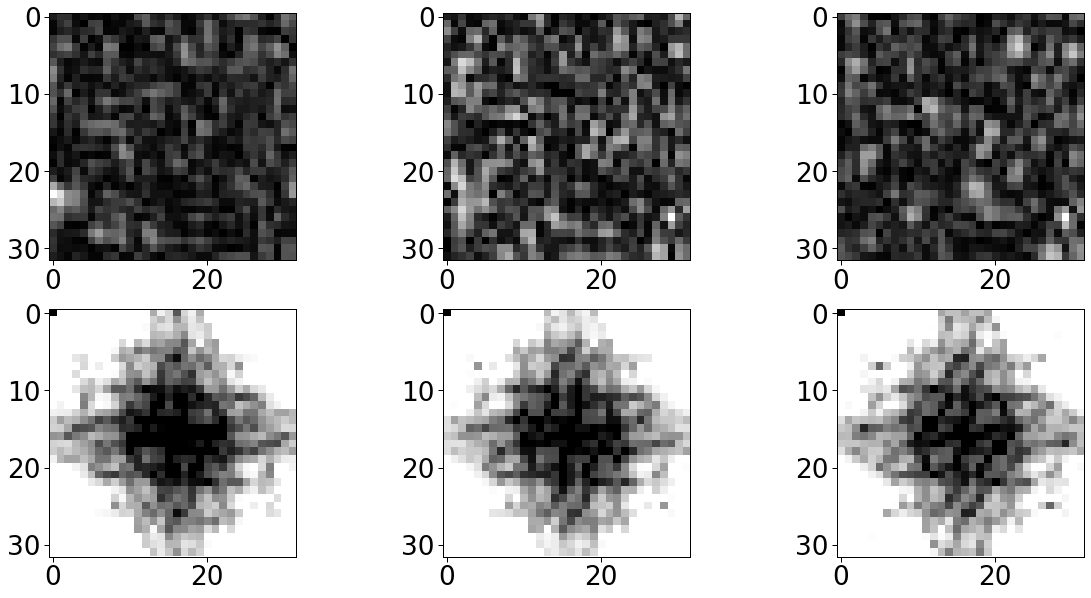

8 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 219/512 (43%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.193543851, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.047747571, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021321163, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012649400, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008655367, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005024451, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003426277, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002556176, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002017133, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001653931, Accuracy: 512/512 (100%)

(tensor(67.), tensor(2.7391e+13))

Train set: Avg. loss: 0.000820991, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000530303, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000299481, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000204811, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000154186, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064565, A

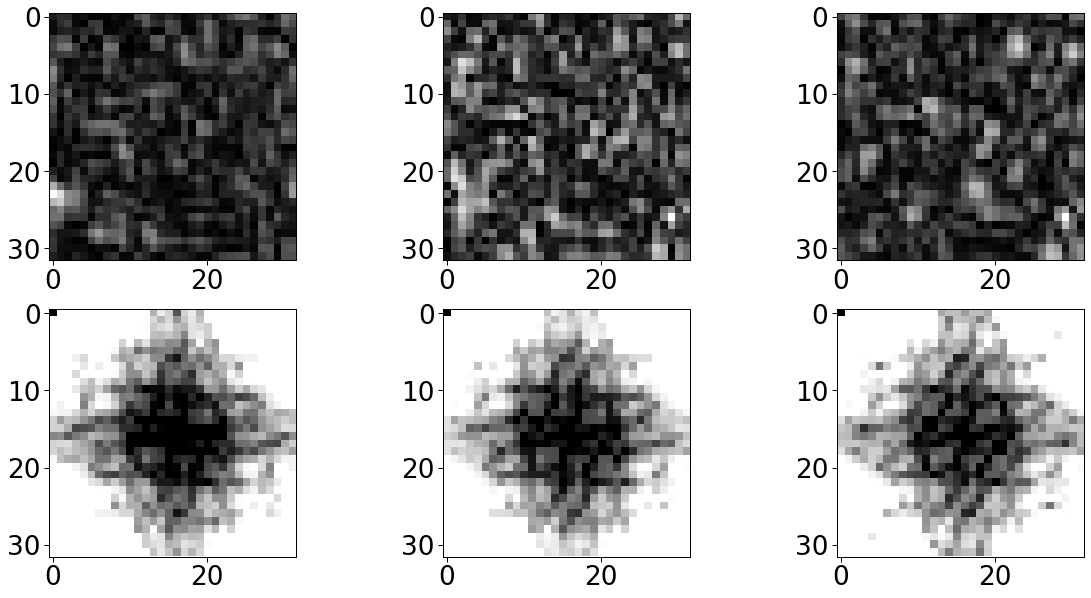

8 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 291/512 (57%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.191716492, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.047765538, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021324446, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012643410, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008646490, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005015414, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003417974, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002548800, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002010598, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001648114, Accuracy: 512/512 (100%)

(tensor(67.), tensor(6.0039e+13))

Train set: Avg. loss: 0.000817611, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000527925, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000298068, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000203815, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000153423, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064259, A

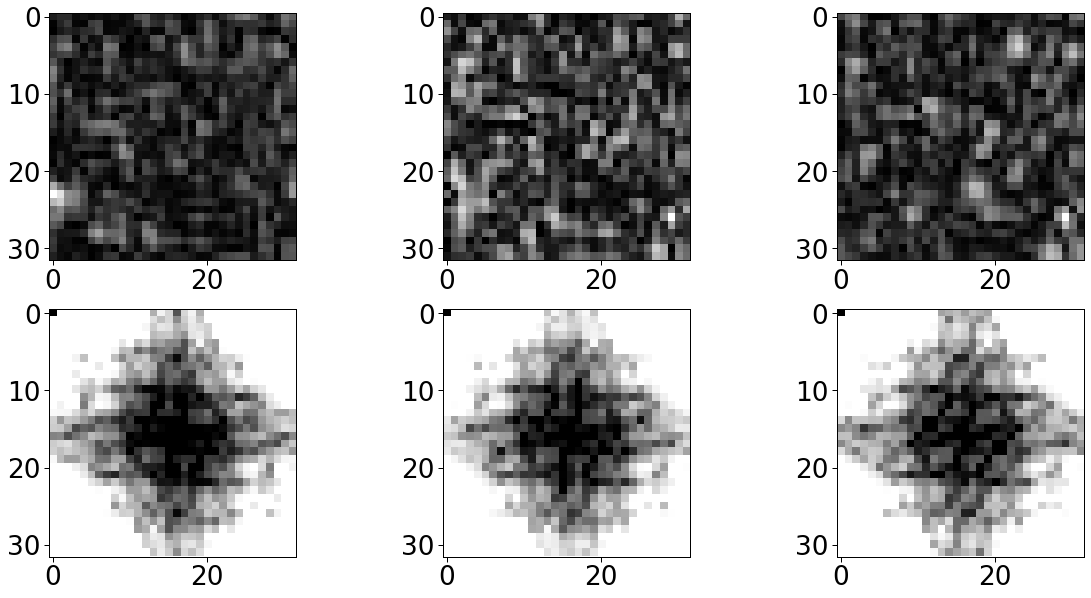

8 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 243/512 (47%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.193886653, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.047864348, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021348089, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012653703, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008652635, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005018677, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003420450, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002550859, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002012380, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001649688, Accuracy: 512/512 (100%)

(tensor(67.), tensor(4.4284e+13))

Train set: Avg. loss: 0.000818512, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000528574, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000298460, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000204095, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000153639, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064344, A

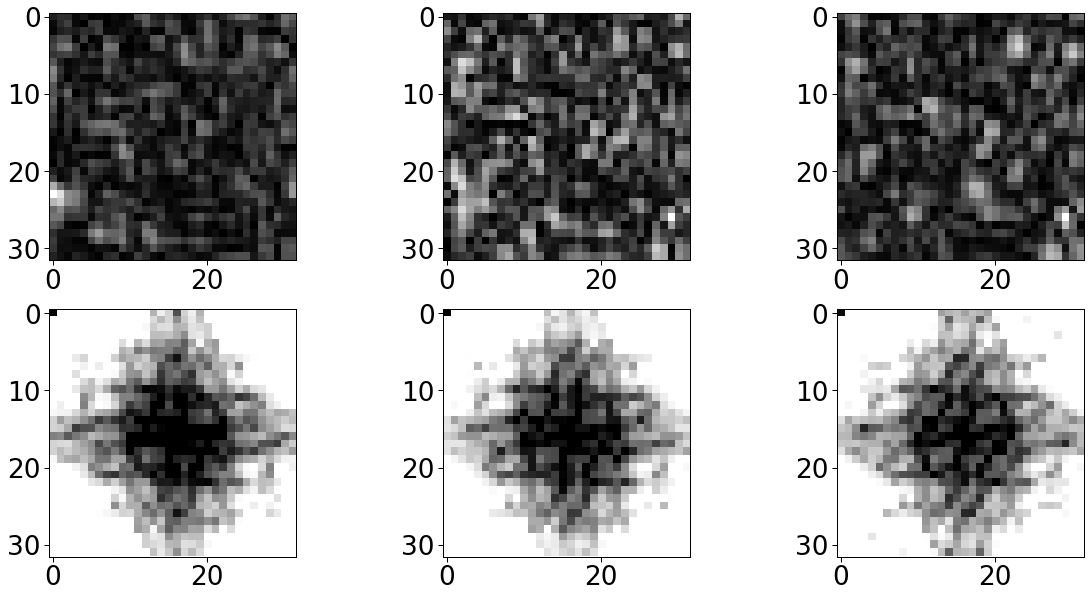

8 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 244/512 (48%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.192390859, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.047930423, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021400666, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012686862, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008675082, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005030968, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003428244, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002556320, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002016465, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001652886, Accuracy: 512/512 (100%)

(tensor(67.), tensor(7.0765e+13))

Train set: Avg. loss: 0.000819872, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000529357, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000298851, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000204340, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000153814, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064409, A

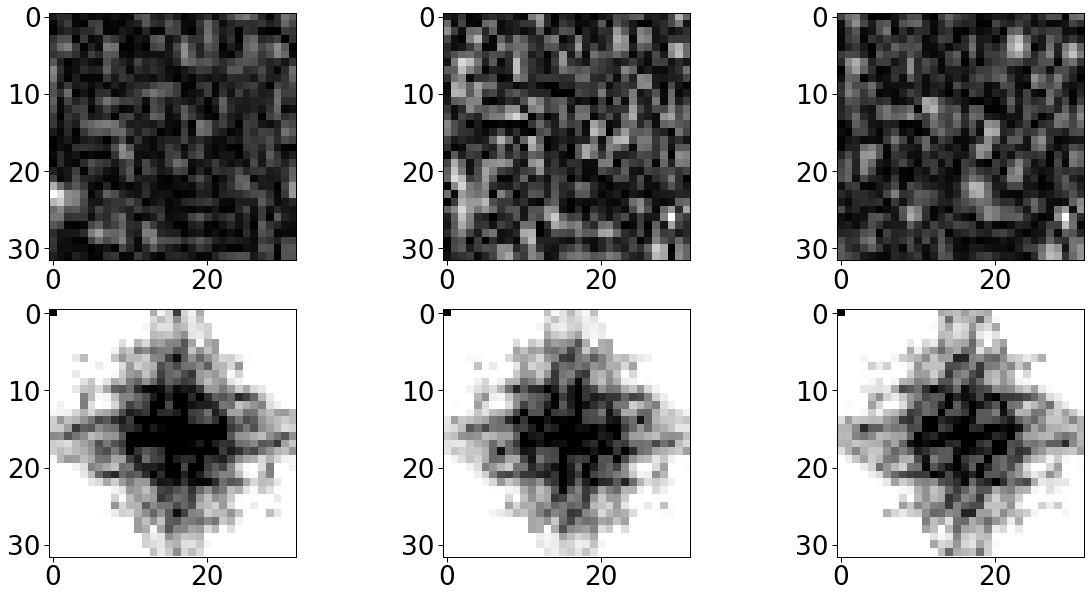

8 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 233/512 (46%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.193307489, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.047697369, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021290345, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012628632, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008640060, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005015062, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003419478, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002550901, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002012855, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001650356, Accuracy: 512/512 (100%)

(tensor(67.), tensor(3.6344e+13))

Train set: Avg. loss: 0.000819264, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000529171, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000298859, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000204387, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000153868, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064447, A

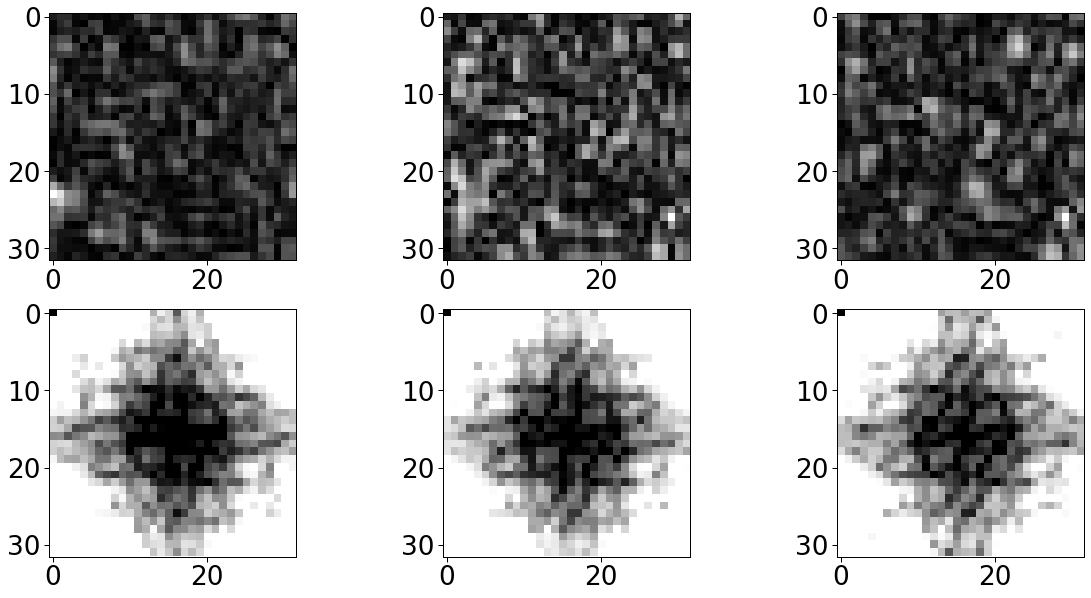

8 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 255/512 (50%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.194460735, Accuracy: 496/512 (97%)


Train set: Avg. loss: 0.047839791, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021338020, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012649671, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008650776, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005018309, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003420506, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002551018, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002012556, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001649862, Accuracy: 512/512 (100%)

(tensor(68.), tensor(2.9920e+13))

Train set: Avg. loss: 0.000818714, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000528747, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000298578, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000204183, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000153708, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064383, A

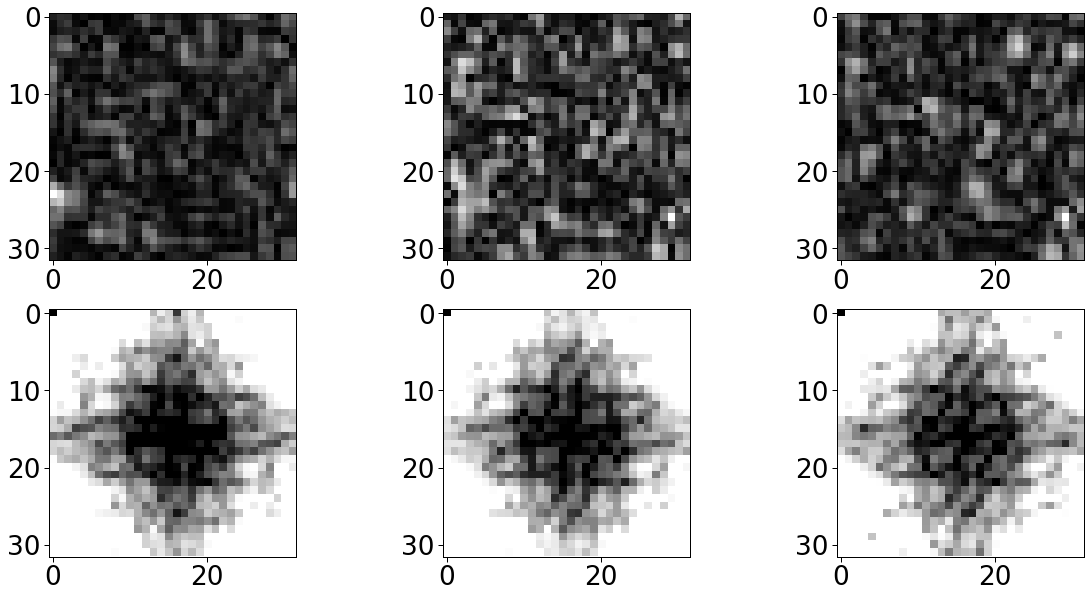

8 8
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 246/512 (48%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.194448739, Accuracy: 495/512 (97%)


Train set: Avg. loss: 0.047809418, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.021321215, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.012640897, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008645753, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005016444, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003419770, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002550735, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002012490, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001649904, Accuracy: 512/512 (100%)

(tensor(67.), tensor(3.1335e+13))

Train set: Avg. loss: 0.000818921, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000528942, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000298716, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000204289, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000153790, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000064423, A

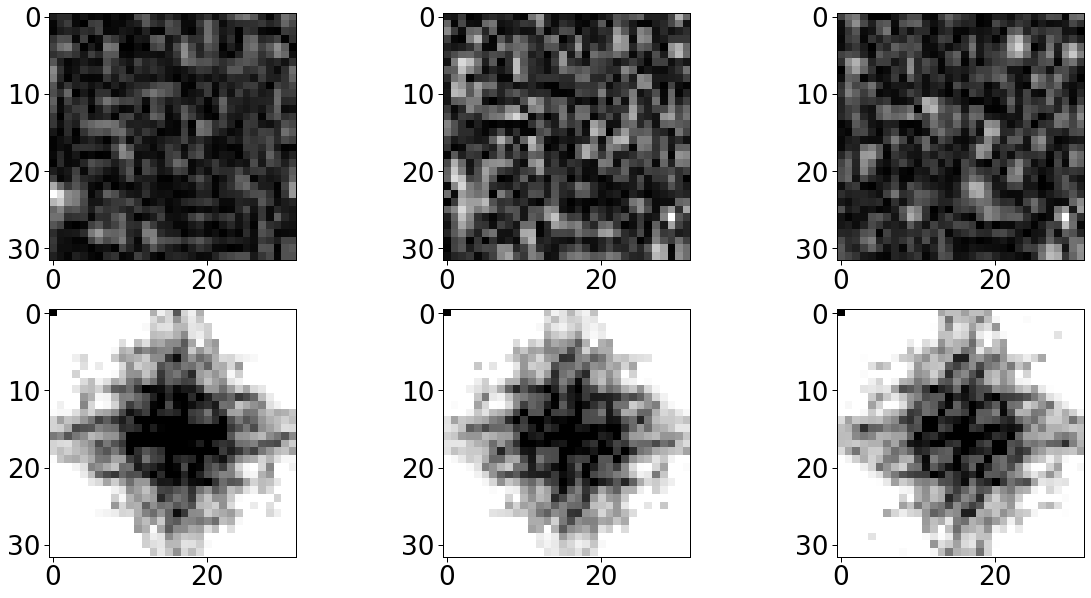

(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 1)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 2)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 3)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)

  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.147078544, Accuracy: 503/512 (98%)


Train set: Avg. loss: 0.029929593, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013941282, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008570688, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.006012004, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003609660, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002505479, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001892004, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001506349, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001243595, Accuracy: 512/512 (100%)

(tensor(65.), tensor(3.6268e+11))

Train set: Avg. loss: 0.000631332, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000410427, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000234170, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000160701, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000121331, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000051337, A

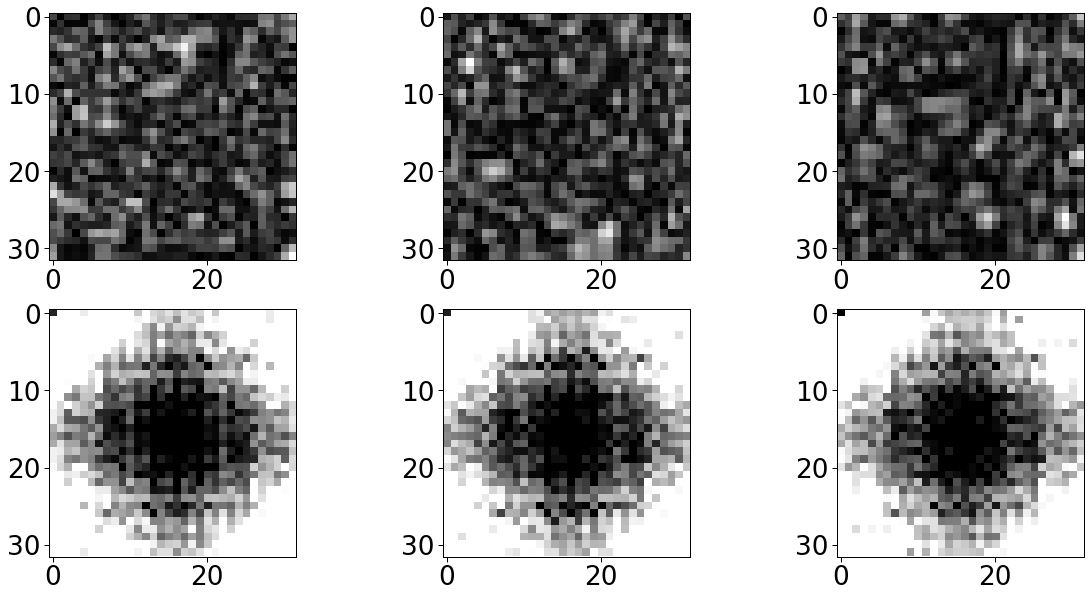

20 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 296/512 (58%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.146665186, Accuracy: 500/512 (98%)


Train set: Avg. loss: 0.028936213, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013455324, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008270211, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005800801, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003480250, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002416182, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001824761, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001452864, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001199436, Accuracy: 512/512 (100%)

(tensor(66.), tensor(1.7954e+12))

Train set: Avg. loss: 0.000608032, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000395614, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000225570, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000154864, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000116924, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000049360, A

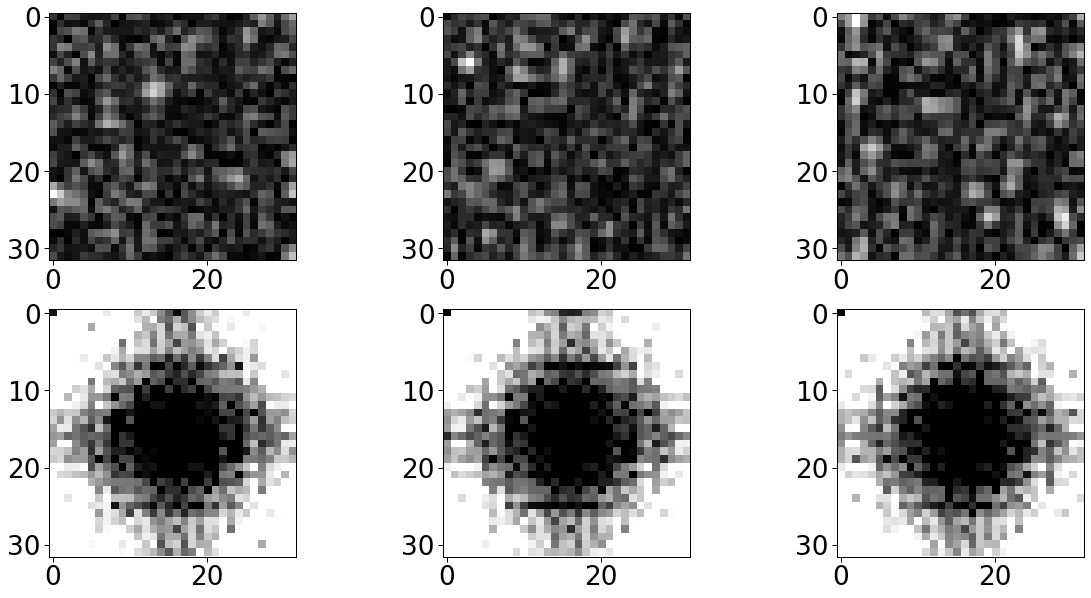

20 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 272/512 (53%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.133779287, Accuracy: 503/512 (98%)


Train set: Avg. loss: 0.028444901, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013442724, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008309811, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005846745, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003521079, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002450578, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001853376, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001477029, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001220196, Accuracy: 512/512 (100%)

(tensor(67.), tensor(3.2989e+12))

Train set: Avg. loss: 0.000619811, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000403632, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000230217, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000158077, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000119346, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000050350, A

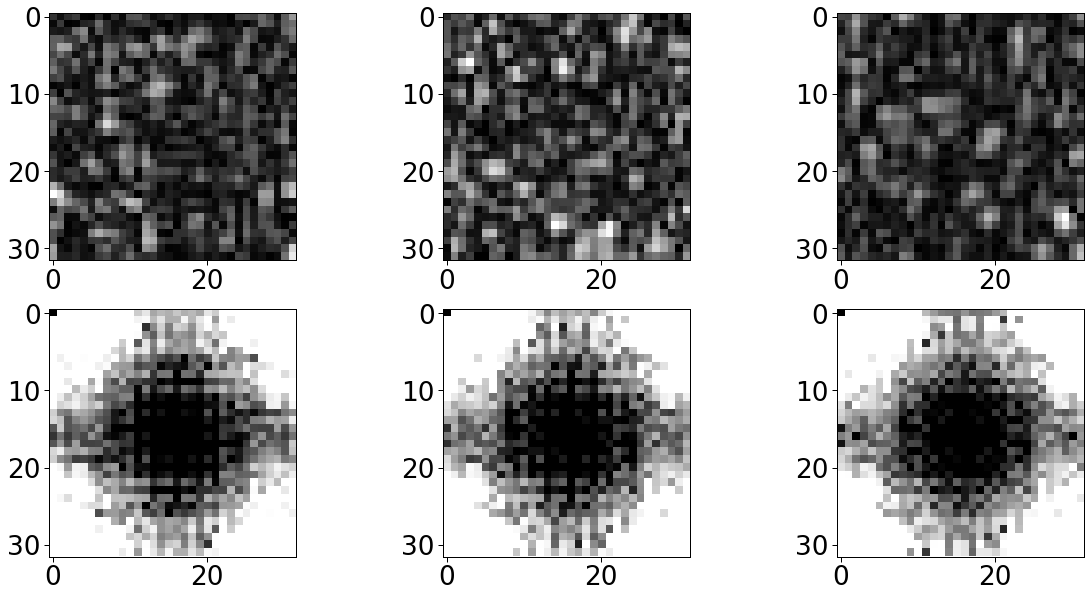

20 1
init
Before training:

Train set: Avg. loss: 1.000000000, Accuracy: 287/512 (56%)

Start training:


  0%|          | 0/100000 [00:00<?, ?it/s]


Train set: Avg. loss: 0.143684581, Accuracy: 503/512 (98%)


Train set: Avg. loss: 0.029042637, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.013453262, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.008257569, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.005790753, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.003475007, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.002415349, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001825738, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001454706, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.001201713, Accuracy: 512/512 (100%)

(tensor(64.), tensor(7.8280e+11))

Train set: Avg. loss: 0.000609776, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000397322, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000226727, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000155812, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000117718, Accuracy: 512/512 (100%)


Train set: Avg. loss: 0.000049695, A

In [ ]:
# k_vals = [3, 16, 20, 32]
# k_vals = [1, 3, 8, 20, 32]
k_vals = [1, 3, 8, 20, 32]
for k in k_vals:
    run_experiment_series(k)